In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as f
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns 
from scipy import stats
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import h2o
from h2o.automl import H2OAutoML
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.neural_network import MLPRegressor
from scipy.stats import norm
import copy
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool, metrics, cv
import xgboost as xgb
from scipy.stats import gmean
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


In [3]:
train_df = pd.read_csv('./new_train.csv', parse_dates=["startdate"])
test_df = pd.read_csv('./new_test.csv', parse_dates=["startdate"])

In [4]:
exclude_cols = ['index', 'startdate']
temporal_attrs = ['year', 'month', 'day_of_year', 'season', 'day_of_year_sin', 'day_of_year_cos','month_sin', 'month_cos', 'season_sin', 'season_cos']
loc_attrs = ['lat', 'lon', 'loc_group']
embedding_attrs = ['climateregions__climateregion']
target=["contest-tmp2m-14d__tmp2m"]
main_attrs = [c for c in train_df.columns if c not in exclude_cols and c not in temporal_attrs and c not in loc_attrs and c not in target and c not in embedding_attrs]
print("Main features:", len(main_attrs))

Main features: 240


In [5]:
best_cols = ['contest-wind-h500-14d__wind-hgt-500',
 'contest-slp-14d__slp',
 'nmme-tmp2m-34w__ccsm3',
 'elevation__elevation',
 'lon',
 'contest-prwtr-eatm-14d__prwtr',
 'lat',
 'climateregions__climateregion',
 'contest-wind-h100-14d__wind-hgt-100',
 'contest-pres-sfc-gauss-14d__pres',
 'season_sin',
 'day_of_year_sin',
 'contest-precip-14d__precip',
 'contest-wind-uwnd-250-14d__wind-uwnd-250',
 'nmme-prate-34w__cfsv2',
 'nmme-prate-34w__nasa',
 'nmme-prate-56w__gfdlflora',
 'wind-uwnd-250-2010-7',
 'contest-wind-vwnd-925-14d__wind-vwnd-925',
 'nmme-prate-34w__nmmemean',
 'nmme0-prate-34w__ccsm30',
 'contest-wind-h850-14d__wind-hgt-850',
 'contest-wind-uwnd-925-14d__wind-uwnd-925',
 'nmme0-prate-56w__cfsv20',
 'month_sin',
 'nmme-prate-34w__cancm3',
 'contest-rhum-sig995-14d__rhum',
 'nmme-prate-34w__gfdlflorb',
 'wind-hgt-850-2010-4',
 'contest-wind-vwnd-250-14d__wind-vwnd-250',
 'wind-hgt-100-2010-2',
 'wind-uwnd-250-2010-18',
 'wind-hgt-10-2010-5',
 'wind-uwnd-250-2010-15',
 'wind-uwnd-250-2010-4',
 'nmme0-prate-56w__nasa0',
 'nmme0-prate-34w__cfsv20',
 'wind-vwnd-250-2010-10',
 'contest-wind-h10-14d__wind-hgt-10',
 'wind-uwnd-925-2010-15',
 'wind-vwnd-250-2010-3',
 'nmme-prate-34w__cancm4',
 'sst-2010-4',
 'nmme0-prate-56w__ccsm30',
 'wind-uwnd-250-2010-16',
 'nmme0-prate-34w__gfdl0',
 'nmme0-prate-56w__cancm40',
 'sst-2010-1',
 'sst-2010-3',
 'wind-uwnd-250-2010-14',
 'nmme0-prate-34w__gfdlflora0',
 'nmme-prate-34w__gfdl',
 'wind-hgt-850-2010-9',
 'wind-vwnd-250-2010-1',
 'nmme-prate-34w__gfdlflora',
 'sst-2010-5',
 'cancm30',
 'nmme-prate-34w__ccsm4',
 'nmme0-prate-34w__nasa0',
 'wind-hgt-500-2010-9',
 'nmme0-prate-34w__cancm30',
 'wind-vwnd-250-2010-13']

# important_cols = ['contest-wind-h500-14d__wind-hgt-500']

In [7]:
train_independent_corr = train_df[best_cols].corr()
train_seleted_corr_columns = np.full((train_independent_corr.shape[0],), True, dtype=bool)
for i in range(train_independent_corr.shape[0]):
    for j in range(i + 1, train_independent_corr.shape[0]):
        if train_independent_corr.iloc[i, j] >= 0.95:
            
            if train_seleted_corr_columns[j]:
                train_seleted_corr_columns[j] = False
train_selected_columns = train_df[best_cols].columns[train_seleted_corr_columns]
print(train_selected_columns.shape)

(59,)


In [11]:
train_selected_columns

Index(['contest-wind-h500-14d__wind-hgt-500', 'contest-slp-14d__slp',
       'nmme-tmp2m-34w__ccsm3', 'elevation__elevation', 'lon',
       'contest-prwtr-eatm-14d__prwtr', 'lat', 'climateregions__climateregion',
       'contest-pres-sfc-gauss-14d__pres', 'season_sin', 'day_of_year_sin',
       'contest-precip-14d__precip',
       'contest-wind-uwnd-250-14d__wind-uwnd-250', 'nmme-prate-34w__cfsv2',
       'nmme-prate-34w__nasa', 'nmme-prate-56w__gfdlflora',
       'wind-uwnd-250-2010-7', 'contest-wind-vwnd-925-14d__wind-vwnd-925',
       'nmme-prate-34w__nmmemean', 'nmme0-prate-34w__ccsm30',
       'contest-wind-h850-14d__wind-hgt-850',
       'contest-wind-uwnd-925-14d__wind-uwnd-925', 'nmme0-prate-56w__cfsv20',
       'nmme-prate-34w__cancm3', 'contest-rhum-sig995-14d__rhum',
       'nmme-prate-34w__gfdlflorb', 'wind-hgt-850-2010-4',
       'contest-wind-vwnd-250-14d__wind-vwnd-250', 'wind-hgt-100-2010-2',
       'wind-uwnd-250-2010-18', 'wind-hgt-10-2010-5', 'wind-uwnd-250-2010-15',

/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.
/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """


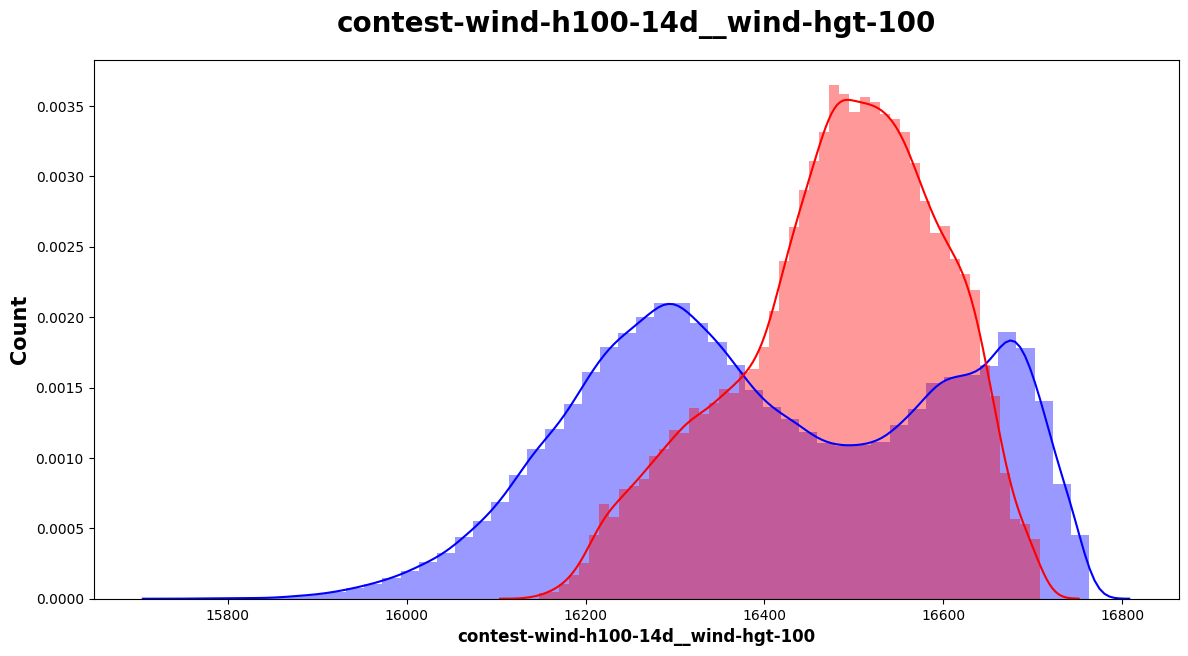

/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.
/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """


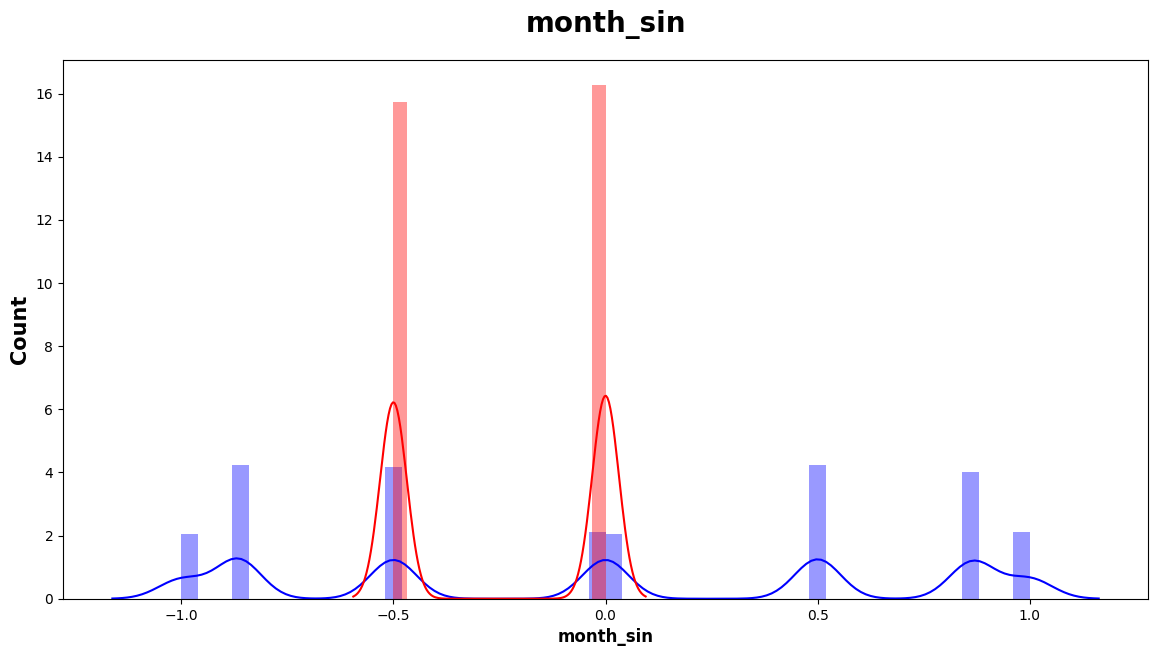

/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.
/data/hieunm/anaconda3/envs/action-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """


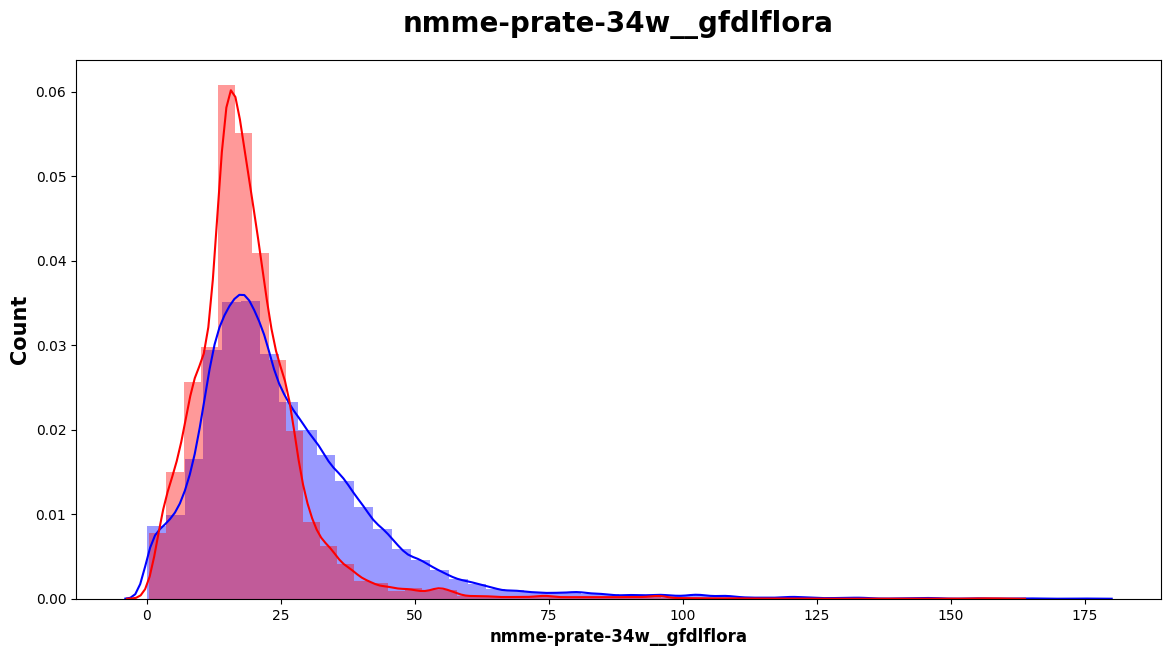

In [9]:
import seaborn as sns
def plot_distribution(var):
    plt.subplots(figsize=(14,7))
    sns.distplot(x=train_df[var], color='blue', kde=True)
    sns.distplot(x=test_df[var], color='red', kde=True)
    plt.title(var, weight="bold",fontsize=20, pad=20)
    plt.ylabel("Count", weight="bold", fontsize=15)
    plt.xlabel(var, weight="bold", fontsize=12)
    plt.show()

for c in best_cols:
    if c not in train_selected_columns:
        plot_distribution(c)

In [10]:
X = train_df[train_selected_columns].values
y = train_df[target[0]].values

skf = KFold(n_splits=5, random_state=2048, shuffle=True)
skf.get_n_splits(X, y)

train_index_list = []
test_index_list = []
train_x_list = []
val_x_list = []
train_y_list = []
val_y_list = []

for i, (train_index, test_index) in tqdm(enumerate(skf.split(X, y))):
    train_index_list.append(train_index)
    test_index_list.append(test_index)

    train_x_list.append(X[train_index, :])
    val_x_list.append(X[test_index, :])
    train_y_list.append(y[train_index])
    val_y_list.append(y[test_index])    
def train_catboost(x, y):
    print(x.shape, y.shape)
    
    cat_models = []
    for i in tqdm(range(5)):
        train_x, val_x = train_x_list[i], val_x_list[i]
        train_y, val_y = train_y_list[i], val_y_list[i]
        clf = CatBoostRegressor(iterations=5000, verbose=200, task_type="GPU",
                           devices='0:1')
        clf.fit(train_x, train_y, eval_set=[(val_x, val_y)], verbose=True, early_stopping_rounds=100)
        cat_models.append(clf)
    
    return cat_models
cat_models = train_catboost(X, y)

preds = []
for cat_model in tqdm(cat_models):
    preds.append(cat_model.predict(test_df[train_selected_columns].values))
s = 0
for pred in preds:
    s += pred
s = s/5
df = pd.read_csv('./sample_solution.csv')
df['contest-tmp2m-14d__tmp2m'] = s
df.to_csv('submission_corr_important_v6.csv', index=False)

best_df = pd.read_csv('best_sub.csv')
y_best = best_df[target[0]].values

from numpy import dot
from numpy.linalg import norm

cos_sim = dot(y_best, s)/(norm(y_best)*norm(s))
print("cos_sim with best submission:", cos_sim)

5it [00:00,  7.91it/s]


(375734, 59) (375734,)


  0%|                                                                                                | 0/5 [00:00<?, ?it/s]Warning: less than 75% gpu memory available for training. Free: 8394.5625 Total: 24268.3125


Learning rate set to 0.072699
0:	learn: 9.2589355	test: 9.2381618	best: 9.2381618 (0)	total: 13.4ms	remaining: 1m 6s
1:	learn: 8.6935018	test: 8.6739373	best: 8.6739373 (1)	total: 17.5ms	remaining: 43.7s
2:	learn: 8.1706683	test: 8.1523634	best: 8.1523634 (2)	total: 21.5ms	remaining: 35.8s
3:	learn: 7.6821667	test: 7.6654605	best: 7.6654605 (3)	total: 25.3ms	remaining: 31.6s
4:	learn: 7.2385158	test: 7.2236877	best: 7.2236877 (4)	total: 29.2ms	remaining: 29.1s
5:	learn: 6.8258626	test: 6.8128653	best: 6.8128653 (5)	total: 33ms	remaining: 27.5s
6:	learn: 6.4361474	test: 6.4241227	best: 6.4241227 (6)	total: 36.9ms	remaining: 26.3s
7:	learn: 6.0835301	test: 6.0722821	best: 6.0722821 (7)	total: 40.7ms	remaining: 25.4s
8:	learn: 5.7500585	test: 5.7394212	best: 5.7394212 (8)	total: 44.5ms	remaining: 24.7s
9:	learn: 5.4521878	test: 5.4433426	best: 5.4433426 (9)	total: 48.4ms	remaining: 24.2s
10:	learn: 5.1668455	test: 5.1576188	best: 5.1576188 (10)	total: 52.3ms	remaining: 23.7s
11:	learn: 4.

130:	learn: 1.3761007	test: 1.3791056	best: 1.3791056 (130)	total: 624ms	remaining: 23.2s
131:	learn: 1.3734105	test: 1.3764036	best: 1.3764036 (131)	total: 628ms	remaining: 23.1s
132:	learn: 1.3694816	test: 1.3724728	best: 1.3724728 (132)	total: 631ms	remaining: 23.1s
133:	learn: 1.3659157	test: 1.3688818	best: 1.3688818 (133)	total: 635ms	remaining: 23.1s
134:	learn: 1.3636868	test: 1.3665864	best: 1.3665864 (134)	total: 639ms	remaining: 23s
135:	learn: 1.3611928	test: 1.3640507	best: 1.3640507 (135)	total: 642ms	remaining: 23s
136:	learn: 1.3587120	test: 1.3616197	best: 1.3616197 (136)	total: 646ms	remaining: 22.9s
137:	learn: 1.3564104	test: 1.3593102	best: 1.3593102 (137)	total: 650ms	remaining: 22.9s
138:	learn: 1.3537636	test: 1.3567345	best: 1.3567345 (138)	total: 653ms	remaining: 22.9s
139:	learn: 1.3510264	test: 1.3540213	best: 1.3540213 (139)	total: 657ms	remaining: 22.8s
140:	learn: 1.3484250	test: 1.3513698	best: 1.3513698 (140)	total: 661ms	remaining: 22.8s
141:	learn: 1.

257:	learn: 1.0970674	test: 1.1029036	best: 1.1029036 (257)	total: 1.22s	remaining: 22.5s
258:	learn: 1.0957116	test: 1.1015090	best: 1.1015090 (258)	total: 1.23s	remaining: 22.5s
259:	learn: 1.0937144	test: 1.0995370	best: 1.0995370 (259)	total: 1.23s	remaining: 22.5s
260:	learn: 1.0913781	test: 1.0972140	best: 1.0972140 (260)	total: 1.24s	remaining: 22.5s
261:	learn: 1.0901258	test: 1.0959854	best: 1.0959854 (261)	total: 1.24s	remaining: 22.5s
262:	learn: 1.0888802	test: 1.0947881	best: 1.0947881 (262)	total: 1.25s	remaining: 22.5s
263:	learn: 1.0879259	test: 1.0938786	best: 1.0938786 (263)	total: 1.25s	remaining: 22.5s
264:	learn: 1.0861312	test: 1.0921314	best: 1.0921314 (264)	total: 1.26s	remaining: 22.5s
265:	learn: 1.0835478	test: 1.0895606	best: 1.0895606 (265)	total: 1.27s	remaining: 22.6s
266:	learn: 1.0825389	test: 1.0885918	best: 1.0885918 (266)	total: 1.27s	remaining: 22.6s
267:	learn: 1.0815615	test: 1.0876147	best: 1.0876147 (267)	total: 1.28s	remaining: 22.6s
268:	learn

383:	learn: 0.9490621	test: 0.9569098	best: 0.9569098 (383)	total: 1.82s	remaining: 21.9s
384:	learn: 0.9476821	test: 0.9554726	best: 0.9554726 (384)	total: 1.83s	remaining: 21.9s
385:	learn: 0.9467407	test: 0.9546338	best: 0.9546338 (385)	total: 1.83s	remaining: 21.9s
386:	learn: 0.9459242	test: 0.9538120	best: 0.9538120 (386)	total: 1.83s	remaining: 21.9s
387:	learn: 0.9453038	test: 0.9532423	best: 0.9532423 (387)	total: 1.84s	remaining: 21.9s
388:	learn: 0.9447658	test: 0.9526826	best: 0.9526826 (388)	total: 1.84s	remaining: 21.8s
389:	learn: 0.9440691	test: 0.9519983	best: 0.9519983 (389)	total: 1.85s	remaining: 21.8s
390:	learn: 0.9431543	test: 0.9511480	best: 0.9511480 (390)	total: 1.85s	remaining: 21.8s
391:	learn: 0.9424853	test: 0.9504952	best: 0.9504952 (391)	total: 1.85s	remaining: 21.8s
392:	learn: 0.9417215	test: 0.9497662	best: 0.9497662 (392)	total: 1.86s	remaining: 21.8s
393:	learn: 0.9412261	test: 0.9492799	best: 0.9492799 (393)	total: 1.87s	remaining: 21.9s
394:	learn

475:	learn: 0.8702899	test: 0.8794766	best: 0.8794766 (475)	total: 2.22s	remaining: 21.1s
476:	learn: 0.8697170	test: 0.8789173	best: 0.8789173 (476)	total: 2.23s	remaining: 21.2s
477:	learn: 0.8683456	test: 0.8775557	best: 0.8775557 (477)	total: 2.24s	remaining: 21.2s
478:	learn: 0.8678789	test: 0.8770878	best: 0.8770878 (478)	total: 2.25s	remaining: 21.2s
479:	learn: 0.8668707	test: 0.8760842	best: 0.8760842 (479)	total: 2.25s	remaining: 21.2s
480:	learn: 0.8663978	test: 0.8756389	best: 0.8756389 (480)	total: 2.25s	remaining: 21.2s
481:	learn: 0.8658263	test: 0.8750464	best: 0.8750464 (481)	total: 2.26s	remaining: 21.2s
482:	learn: 0.8651862	test: 0.8744386	best: 0.8744386 (482)	total: 2.26s	remaining: 21.2s
483:	learn: 0.8646709	test: 0.8739623	best: 0.8739623 (483)	total: 2.27s	remaining: 21.1s
484:	learn: 0.8641604	test: 0.8734786	best: 0.8734786 (484)	total: 2.27s	remaining: 21.1s
485:	learn: 0.8638073	test: 0.8731033	best: 0.8731033 (485)	total: 2.27s	remaining: 21.1s
486:	learn

611:	learn: 0.7911261	test: 0.8018749	best: 0.8018749 (611)	total: 2.83s	remaining: 20.3s
612:	learn: 0.7907130	test: 0.8015006	best: 0.8015006 (612)	total: 2.84s	remaining: 20.3s
613:	learn: 0.7903904	test: 0.8011865	best: 0.8011865 (613)	total: 2.84s	remaining: 20.3s
614:	learn: 0.7899829	test: 0.8008172	best: 0.8008172 (614)	total: 2.84s	remaining: 20.3s
615:	learn: 0.7896463	test: 0.8004753	best: 0.8004753 (615)	total: 2.85s	remaining: 20.3s
616:	learn: 0.7892914	test: 0.8001635	best: 0.8001635 (616)	total: 2.85s	remaining: 20.3s
617:	learn: 0.7890115	test: 0.7998982	best: 0.7998982 (617)	total: 2.85s	remaining: 20.3s
618:	learn: 0.7886020	test: 0.7995327	best: 0.7995327 (618)	total: 2.86s	remaining: 20.2s
619:	learn: 0.7881802	test: 0.7991139	best: 0.7991139 (619)	total: 2.86s	remaining: 20.2s
620:	learn: 0.7876616	test: 0.7986105	best: 0.7986105 (620)	total: 2.87s	remaining: 20.2s
621:	learn: 0.7871346	test: 0.7980839	best: 0.7980839 (621)	total: 2.87s	remaining: 20.2s
622:	learn

732:	learn: 0.7372259	test: 0.7493438	best: 0.7493438 (732)	total: 3.44s	remaining: 20s
733:	learn: 0.7368645	test: 0.7489539	best: 0.7489539 (733)	total: 3.44s	remaining: 20s
734:	learn: 0.7366113	test: 0.7486873	best: 0.7486873 (734)	total: 3.45s	remaining: 20s
735:	learn: 0.7362381	test: 0.7483068	best: 0.7483068 (735)	total: 3.45s	remaining: 20s
736:	learn: 0.7359559	test: 0.7480323	best: 0.7480323 (736)	total: 3.46s	remaining: 20s
737:	learn: 0.7354748	test: 0.7475727	best: 0.7475727 (737)	total: 3.46s	remaining: 20s
738:	learn: 0.7347769	test: 0.7469109	best: 0.7469109 (738)	total: 3.46s	remaining: 20s
739:	learn: 0.7340119	test: 0.7461412	best: 0.7461412 (739)	total: 3.47s	remaining: 20s
740:	learn: 0.7334823	test: 0.7456158	best: 0.7456158 (740)	total: 3.47s	remaining: 19.9s
741:	learn: 0.7332881	test: 0.7454339	best: 0.7454339 (741)	total: 3.48s	remaining: 19.9s
742:	learn: 0.7329327	test: 0.7450778	best: 0.7450778 (742)	total: 3.48s	remaining: 19.9s
743:	learn: 0.7326787	test

858:	learn: 0.6921980	test: 0.7052734	best: 0.7052734 (858)	total: 4.04s	remaining: 19.5s
859:	learn: 0.6914813	test: 0.7045812	best: 0.7045812 (859)	total: 4.05s	remaining: 19.5s
860:	learn: 0.6911994	test: 0.7043111	best: 0.7043111 (860)	total: 4.05s	remaining: 19.5s
861:	learn: 0.6909191	test: 0.7040598	best: 0.7040598 (861)	total: 4.05s	remaining: 19.5s
862:	learn: 0.6906252	test: 0.7037923	best: 0.7037923 (862)	total: 4.06s	remaining: 19.5s
863:	learn: 0.6904423	test: 0.7035685	best: 0.7035685 (863)	total: 4.06s	remaining: 19.4s
864:	learn: 0.6898678	test: 0.7030469	best: 0.7030469 (864)	total: 4.07s	remaining: 19.4s
865:	learn: 0.6892892	test: 0.7024852	best: 0.7024852 (865)	total: 4.07s	remaining: 19.4s
866:	learn: 0.6884847	test: 0.7016587	best: 0.7016587 (866)	total: 4.07s	remaining: 19.4s
867:	learn: 0.6882054	test: 0.7013777	best: 0.7013777 (867)	total: 4.08s	remaining: 19.4s
868:	learn: 0.6879563	test: 0.7010967	best: 0.7010967 (868)	total: 4.08s	remaining: 19.4s
869:	learn

987:	learn: 0.6529194	test: 0.6671934	best: 0.6671934 (987)	total: 4.64s	remaining: 18.8s
988:	learn: 0.6527656	test: 0.6670385	best: 0.6670385 (988)	total: 4.64s	remaining: 18.8s
989:	learn: 0.6521662	test: 0.6664286	best: 0.6664286 (989)	total: 4.65s	remaining: 18.8s
990:	learn: 0.6519716	test: 0.6662320	best: 0.6662320 (990)	total: 4.65s	remaining: 18.8s
991:	learn: 0.6517444	test: 0.6660373	best: 0.6660373 (991)	total: 4.66s	remaining: 18.8s
992:	learn: 0.6515110	test: 0.6657978	best: 0.6657978 (992)	total: 4.66s	remaining: 18.8s
993:	learn: 0.6512196	test: 0.6655212	best: 0.6655212 (993)	total: 4.66s	remaining: 18.8s
994:	learn: 0.6510364	test: 0.6653402	best: 0.6653402 (994)	total: 4.67s	remaining: 18.8s
995:	learn: 0.6507654	test: 0.6650251	best: 0.6650251 (995)	total: 4.67s	remaining: 18.8s
996:	learn: 0.6505542	test: 0.6648337	best: 0.6648337 (996)	total: 4.67s	remaining: 18.8s
997:	learn: 0.6504266	test: 0.6647202	best: 0.6647202 (997)	total: 4.68s	remaining: 18.8s
998:	learn

1082:	learn: 0.6267215	test: 0.6416076	best: 0.6416076 (1082)	total: 5.05s	remaining: 18.3s
1083:	learn: 0.6265447	test: 0.6414507	best: 0.6414507 (1083)	total: 5.05s	remaining: 18.2s
1084:	learn: 0.6262642	test: 0.6411619	best: 0.6411619 (1084)	total: 5.05s	remaining: 18.2s
1085:	learn: 0.6259334	test: 0.6408648	best: 0.6408648 (1085)	total: 5.06s	remaining: 18.2s
1086:	learn: 0.6256813	test: 0.6406547	best: 0.6406547 (1086)	total: 5.06s	remaining: 18.2s
1087:	learn: 0.6254358	test: 0.6404222	best: 0.6404222 (1087)	total: 5.07s	remaining: 18.2s
1088:	learn: 0.6252606	test: 0.6402647	best: 0.6402647 (1088)	total: 5.07s	remaining: 18.2s
1089:	learn: 0.6250036	test: 0.6400147	best: 0.6400147 (1089)	total: 5.07s	remaining: 18.2s
1090:	learn: 0.6248569	test: 0.6398767	best: 0.6398767 (1090)	total: 5.08s	remaining: 18.2s
1091:	learn: 0.6246179	test: 0.6396219	best: 0.6396219 (1091)	total: 5.08s	remaining: 18.2s
1092:	learn: 0.6244962	test: 0.6394892	best: 0.6394892 (1092)	total: 5.08s	remai

1211:	learn: 0.5988134	test: 0.6142918	best: 0.6142918 (1211)	total: 5.65s	remaining: 17.6s
1212:	learn: 0.5986703	test: 0.6141474	best: 0.6141474 (1212)	total: 5.65s	remaining: 17.6s
1213:	learn: 0.5985541	test: 0.6140289	best: 0.6140289 (1213)	total: 5.66s	remaining: 17.6s
1214:	learn: 0.5984027	test: 0.6139065	best: 0.6139065 (1214)	total: 5.66s	remaining: 17.6s
1215:	learn: 0.5981205	test: 0.6136317	best: 0.6136317 (1215)	total: 5.67s	remaining: 17.6s
1216:	learn: 0.5978876	test: 0.6133890	best: 0.6133890 (1216)	total: 5.67s	remaining: 17.6s
1217:	learn: 0.5977550	test: 0.6132593	best: 0.6132593 (1217)	total: 5.67s	remaining: 17.6s
1218:	learn: 0.5975289	test: 0.6130121	best: 0.6130121 (1218)	total: 5.68s	remaining: 17.6s
1219:	learn: 0.5970711	test: 0.6125599	best: 0.6125599 (1219)	total: 5.68s	remaining: 17.6s
1220:	learn: 0.5968134	test: 0.6123039	best: 0.6123039 (1220)	total: 5.68s	remaining: 17.6s
1221:	learn: 0.5965931	test: 0.6121080	best: 0.6121080 (1221)	total: 5.69s	remai

1341:	learn: 0.5756634	test: 0.5917935	best: 0.5917935 (1341)	total: 6.25s	remaining: 17s
1342:	learn: 0.5755225	test: 0.5916582	best: 0.5916582 (1342)	total: 6.26s	remaining: 17s
1343:	learn: 0.5752742	test: 0.5914134	best: 0.5914134 (1343)	total: 6.26s	remaining: 17s
1344:	learn: 0.5751195	test: 0.5912400	best: 0.5912400 (1344)	total: 6.27s	remaining: 17s
1345:	learn: 0.5749987	test: 0.5911011	best: 0.5911011 (1345)	total: 6.28s	remaining: 17s
1346:	learn: 0.5748406	test: 0.5909577	best: 0.5909577 (1346)	total: 6.28s	remaining: 17s
1347:	learn: 0.5747185	test: 0.5908429	best: 0.5908429 (1347)	total: 6.29s	remaining: 17s
1348:	learn: 0.5745555	test: 0.5906754	best: 0.5906754 (1348)	total: 6.29s	remaining: 17s
1349:	learn: 0.5744355	test: 0.5905462	best: 0.5905462 (1349)	total: 6.29s	remaining: 17s
1350:	learn: 0.5742239	test: 0.5903672	best: 0.5903672 (1350)	total: 6.3s	remaining: 17s
1351:	learn: 0.5740501	test: 0.5901893	best: 0.5901893 (1351)	total: 6.3s	remaining: 17s
1352:	learn:

1462:	learn: 0.5546280	test: 0.5713904	best: 0.5713904 (1462)	total: 6.85s	remaining: 16.6s
1463:	learn: 0.5544562	test: 0.5712415	best: 0.5712415 (1463)	total: 6.86s	remaining: 16.6s
1464:	learn: 0.5543322	test: 0.5711280	best: 0.5711280 (1464)	total: 6.86s	remaining: 16.6s
1465:	learn: 0.5540338	test: 0.5708188	best: 0.5708188 (1465)	total: 6.86s	remaining: 16.5s
1466:	learn: 0.5539530	test: 0.5707413	best: 0.5707413 (1466)	total: 6.87s	remaining: 16.5s
1467:	learn: 0.5538673	test: 0.5706598	best: 0.5706598 (1467)	total: 6.87s	remaining: 16.5s
1468:	learn: 0.5537509	test: 0.5705128	best: 0.5705128 (1468)	total: 6.88s	remaining: 16.5s
1469:	learn: 0.5536446	test: 0.5703977	best: 0.5703977 (1469)	total: 6.88s	remaining: 16.5s
1470:	learn: 0.5534832	test: 0.5702496	best: 0.5702496 (1470)	total: 6.89s	remaining: 16.5s
1471:	learn: 0.5534187	test: 0.5701742	best: 0.5701742 (1471)	total: 6.9s	remaining: 16.5s
1472:	learn: 0.5532505	test: 0.5700044	best: 0.5700044 (1472)	total: 6.9s	remaini

1555:	learn: 0.5405175	test: 0.5576327	best: 0.5576327 (1555)	total: 7.26s	remaining: 16.1s
1556:	learn: 0.5404010	test: 0.5575159	best: 0.5575159 (1556)	total: 7.26s	remaining: 16.1s
1557:	learn: 0.5402643	test: 0.5573789	best: 0.5573789 (1557)	total: 7.26s	remaining: 16s
1558:	learn: 0.5401326	test: 0.5572507	best: 0.5572507 (1558)	total: 7.27s	remaining: 16s
1559:	learn: 0.5400325	test: 0.5571517	best: 0.5571517 (1559)	total: 7.27s	remaining: 16s
1560:	learn: 0.5398082	test: 0.5569290	best: 0.5569290 (1560)	total: 7.28s	remaining: 16s
1561:	learn: 0.5397343	test: 0.5568552	best: 0.5568552 (1561)	total: 7.28s	remaining: 16s
1562:	learn: 0.5395631	test: 0.5566988	best: 0.5566988 (1562)	total: 7.28s	remaining: 16s
1563:	learn: 0.5391991	test: 0.5563377	best: 0.5563377 (1563)	total: 7.29s	remaining: 16s
1564:	learn: 0.5391119	test: 0.5562551	best: 0.5562551 (1564)	total: 7.29s	remaining: 16s
1565:	learn: 0.5389991	test: 0.5561577	best: 0.5561577 (1565)	total: 7.29s	remaining: 16s
1566:	

1645:	learn: 0.5283723	test: 0.5458335	best: 0.5458335 (1645)	total: 7.67s	remaining: 15.6s
1646:	learn: 0.5282455	test: 0.5457396	best: 0.5457396 (1646)	total: 7.67s	remaining: 15.6s
1647:	learn: 0.5281316	test: 0.5456443	best: 0.5456443 (1647)	total: 7.68s	remaining: 15.6s
1648:	learn: 0.5280243	test: 0.5455578	best: 0.5455578 (1648)	total: 7.68s	remaining: 15.6s
1649:	learn: 0.5278555	test: 0.5453861	best: 0.5453861 (1649)	total: 7.69s	remaining: 15.6s
1650:	learn: 0.5277458	test: 0.5452807	best: 0.5452807 (1650)	total: 7.69s	remaining: 15.6s
1651:	learn: 0.5275767	test: 0.5451184	best: 0.5451184 (1651)	total: 7.7s	remaining: 15.6s
1652:	learn: 0.5274822	test: 0.5450352	best: 0.5450352 (1652)	total: 7.71s	remaining: 15.6s
1653:	learn: 0.5273257	test: 0.5448838	best: 0.5448838 (1653)	total: 7.72s	remaining: 15.6s
1654:	learn: 0.5272067	test: 0.5447649	best: 0.5447649 (1654)	total: 7.73s	remaining: 15.6s
1655:	learn: 0.5271034	test: 0.5446580	best: 0.5446580 (1655)	total: 7.74s	remain

1765:	learn: 0.5134727	test: 0.5314870	best: 0.5314870 (1765)	total: 8.27s	remaining: 15.1s
1766:	learn: 0.5133681	test: 0.5313976	best: 0.5313976 (1766)	total: 8.27s	remaining: 15.1s
1767:	learn: 0.5130595	test: 0.5310903	best: 0.5310903 (1767)	total: 8.28s	remaining: 15.1s
1768:	learn: 0.5125826	test: 0.5306251	best: 0.5306251 (1768)	total: 8.28s	remaining: 15.1s
1769:	learn: 0.5124879	test: 0.5305346	best: 0.5305346 (1769)	total: 8.28s	remaining: 15.1s
1770:	learn: 0.5123559	test: 0.5303946	best: 0.5303946 (1770)	total: 8.29s	remaining: 15.1s
1771:	learn: 0.5122633	test: 0.5303104	best: 0.5303104 (1771)	total: 8.29s	remaining: 15.1s
1772:	learn: 0.5118521	test: 0.5299181	best: 0.5299181 (1772)	total: 8.29s	remaining: 15.1s
1773:	learn: 0.5117251	test: 0.5298026	best: 0.5298026 (1773)	total: 8.3s	remaining: 15.1s
1774:	learn: 0.5116466	test: 0.5297345	best: 0.5297345 (1774)	total: 8.3s	remaining: 15.1s
1775:	learn: 0.5114927	test: 0.5295689	best: 0.5295689 (1775)	total: 8.3s	remainin

1861:	learn: 0.5019123	test: 0.5203968	best: 0.5203968 (1861)	total: 8.67s	remaining: 14.6s
1862:	learn: 0.5017679	test: 0.5202434	best: 0.5202434 (1862)	total: 8.67s	remaining: 14.6s
1863:	learn: 0.5016521	test: 0.5201362	best: 0.5201362 (1863)	total: 8.68s	remaining: 14.6s
1864:	learn: 0.5015192	test: 0.5199977	best: 0.5199977 (1864)	total: 8.68s	remaining: 14.6s
1865:	learn: 0.5014048	test: 0.5198881	best: 0.5198881 (1865)	total: 8.68s	remaining: 14.6s
1866:	learn: 0.5012520	test: 0.5197405	best: 0.5197405 (1866)	total: 8.69s	remaining: 14.6s
1867:	learn: 0.5011427	test: 0.5196114	best: 0.5196114 (1867)	total: 8.69s	remaining: 14.6s
1868:	learn: 0.5010672	test: 0.5195367	best: 0.5195367 (1868)	total: 8.69s	remaining: 14.6s
1869:	learn: 0.5009606	test: 0.5194405	best: 0.5194405 (1869)	total: 8.7s	remaining: 14.6s
1870:	learn: 0.5008662	test: 0.5193488	best: 0.5193488 (1870)	total: 8.71s	remaining: 14.6s
1871:	learn: 0.5007094	test: 0.5191824	best: 0.5191824 (1871)	total: 8.72s	remain

1955:	learn: 0.4924403	test: 0.5112966	best: 0.5112966 (1955)	total: 9.07s	remaining: 14.1s
1956:	learn: 0.4922258	test: 0.5110694	best: 0.5110694 (1956)	total: 9.07s	remaining: 14.1s
1957:	learn: 0.4920247	test: 0.5108490	best: 0.5108490 (1957)	total: 9.08s	remaining: 14.1s
1958:	learn: 0.4918916	test: 0.5107193	best: 0.5107193 (1958)	total: 9.08s	remaining: 14.1s
1959:	learn: 0.4918401	test: 0.5106713	best: 0.5106713 (1959)	total: 9.08s	remaining: 14.1s
1960:	learn: 0.4917372	test: 0.5105766	best: 0.5105766 (1960)	total: 9.09s	remaining: 14.1s
1961:	learn: 0.4916470	test: 0.5104894	best: 0.5104894 (1961)	total: 9.09s	remaining: 14.1s
1962:	learn: 0.4915703	test: 0.5104112	best: 0.5104112 (1962)	total: 9.09s	remaining: 14.1s
1963:	learn: 0.4915021	test: 0.5103533	best: 0.5103533 (1963)	total: 9.1s	remaining: 14.1s
1964:	learn: 0.4914036	test: 0.5102590	best: 0.5102590 (1964)	total: 9.1s	remaining: 14.1s
1965:	learn: 0.4912934	test: 0.5101601	best: 0.5101601 (1965)	total: 9.1s	remainin

2050:	learn: 0.4824238	test: 0.5015837	best: 0.5015837 (2050)	total: 9.47s	remaining: 13.6s
2051:	learn: 0.4822812	test: 0.5014236	best: 0.5014236 (2051)	total: 9.48s	remaining: 13.6s
2052:	learn: 0.4821902	test: 0.5013379	best: 0.5013379 (2052)	total: 9.48s	remaining: 13.6s
2053:	learn: 0.4820841	test: 0.5012253	best: 0.5012253 (2053)	total: 9.49s	remaining: 13.6s
2054:	learn: 0.4820072	test: 0.5011444	best: 0.5011444 (2054)	total: 9.49s	remaining: 13.6s
2055:	learn: 0.4818932	test: 0.5010235	best: 0.5010235 (2055)	total: 9.5s	remaining: 13.6s
2056:	learn: 0.4818084	test: 0.5009445	best: 0.5009445 (2056)	total: 9.51s	remaining: 13.6s
2057:	learn: 0.4817260	test: 0.5008696	best: 0.5008696 (2057)	total: 9.52s	remaining: 13.6s
2058:	learn: 0.4813115	test: 0.5004367	best: 0.5004367 (2058)	total: 9.52s	remaining: 13.6s
2059:	learn: 0.4812250	test: 0.5003538	best: 0.5003538 (2059)	total: 9.52s	remaining: 13.6s
2060:	learn: 0.4811251	test: 0.5002600	best: 0.5002600 (2060)	total: 9.53s	remain

2177:	learn: 0.4703754	test: 0.4900096	best: 0.4900096 (2177)	total: 10.1s	remaining: 13.1s
2178:	learn: 0.4703020	test: 0.4899301	best: 0.4899301 (2178)	total: 10.1s	remaining: 13s
2179:	learn: 0.4702020	test: 0.4898331	best: 0.4898331 (2179)	total: 10.1s	remaining: 13s
2180:	learn: 0.4701100	test: 0.4897447	best: 0.4897447 (2180)	total: 10.1s	remaining: 13s
2181:	learn: 0.4700377	test: 0.4896763	best: 0.4896763 (2181)	total: 10.1s	remaining: 13s
2182:	learn: 0.4699537	test: 0.4896013	best: 0.4896013 (2182)	total: 10.1s	remaining: 13s
2183:	learn: 0.4698683	test: 0.4895398	best: 0.4895398 (2183)	total: 10.1s	remaining: 13s
2184:	learn: 0.4697991	test: 0.4894869	best: 0.4894869 (2184)	total: 10.1s	remaining: 13s
2185:	learn: 0.4697287	test: 0.4894221	best: 0.4894221 (2185)	total: 10.1s	remaining: 13s
2186:	learn: 0.4696291	test: 0.4893127	best: 0.4893127 (2186)	total: 10.1s	remaining: 13s
2187:	learn: 0.4694818	test: 0.4891776	best: 0.4891776 (2187)	total: 10.1s	remaining: 13s
2188:	le

2268:	learn: 0.4624351	test: 0.4824991	best: 0.4824991 (2268)	total: 10.5s	remaining: 12.6s
2269:	learn: 0.4621853	test: 0.4822486	best: 0.4822486 (2269)	total: 10.5s	remaining: 12.6s
2270:	learn: 0.4621160	test: 0.4821889	best: 0.4821889 (2270)	total: 10.5s	remaining: 12.6s
2271:	learn: 0.4620507	test: 0.4821378	best: 0.4821378 (2271)	total: 10.5s	remaining: 12.6s
2272:	learn: 0.4619522	test: 0.4820395	best: 0.4820395 (2272)	total: 10.5s	remaining: 12.6s
2273:	learn: 0.4618771	test: 0.4819715	best: 0.4819715 (2273)	total: 10.5s	remaining: 12.6s
2274:	learn: 0.4617939	test: 0.4819035	best: 0.4819035 (2274)	total: 10.5s	remaining: 12.6s
2275:	learn: 0.4617297	test: 0.4818421	best: 0.4818421 (2275)	total: 10.5s	remaining: 12.6s
2276:	learn: 0.4616292	test: 0.4817519	best: 0.4817519 (2276)	total: 10.5s	remaining: 12.6s
2277:	learn: 0.4615557	test: 0.4816937	best: 0.4816937 (2277)	total: 10.5s	remaining: 12.6s
2278:	learn: 0.4614444	test: 0.4815845	best: 0.4815845 (2278)	total: 10.5s	remai

2358:	learn: 0.4540707	test: 0.4745447	best: 0.4745447 (2358)	total: 10.9s	remaining: 12.2s
2359:	learn: 0.4539720	test: 0.4744573	best: 0.4744573 (2359)	total: 10.9s	remaining: 12.2s
2360:	learn: 0.4538956	test: 0.4743802	best: 0.4743802 (2360)	total: 10.9s	remaining: 12.2s
2361:	learn: 0.4538386	test: 0.4743250	best: 0.4743250 (2361)	total: 10.9s	remaining: 12.2s
2362:	learn: 0.4537808	test: 0.4742702	best: 0.4742702 (2362)	total: 10.9s	remaining: 12.2s
2363:	learn: 0.4534754	test: 0.4739847	best: 0.4739847 (2363)	total: 10.9s	remaining: 12.2s
2364:	learn: 0.4534190	test: 0.4739254	best: 0.4739254 (2364)	total: 10.9s	remaining: 12.2s
2365:	learn: 0.4533206	test: 0.4738298	best: 0.4738298 (2365)	total: 10.9s	remaining: 12.2s
2366:	learn: 0.4532578	test: 0.4737760	best: 0.4737760 (2366)	total: 10.9s	remaining: 12.2s
2367:	learn: 0.4532009	test: 0.4737135	best: 0.4737135 (2367)	total: 10.9s	remaining: 12.2s
2368:	learn: 0.4531160	test: 0.4736364	best: 0.4736364 (2368)	total: 10.9s	remai

2494:	learn: 0.4437942	test: 0.4645993	best: 0.4645993 (2494)	total: 11.5s	remaining: 11.5s
2495:	learn: 0.4437086	test: 0.4645110	best: 0.4645110 (2495)	total: 11.5s	remaining: 11.5s
2496:	learn: 0.4436462	test: 0.4644469	best: 0.4644469 (2496)	total: 11.5s	remaining: 11.5s
2497:	learn: 0.4434832	test: 0.4642825	best: 0.4642825 (2497)	total: 11.5s	remaining: 11.5s
2498:	learn: 0.4433955	test: 0.4641848	best: 0.4641848 (2498)	total: 11.5s	remaining: 11.5s
2499:	learn: 0.4433391	test: 0.4641275	best: 0.4641275 (2499)	total: 11.5s	remaining: 11.5s
2500:	learn: 0.4432349	test: 0.4640254	best: 0.4640254 (2500)	total: 11.5s	remaining: 11.5s
2501:	learn: 0.4431538	test: 0.4639371	best: 0.4639371 (2501)	total: 11.5s	remaining: 11.5s
2502:	learn: 0.4430833	test: 0.4638764	best: 0.4638764 (2502)	total: 11.5s	remaining: 11.5s
2503:	learn: 0.4430000	test: 0.4637927	best: 0.4637927 (2503)	total: 11.5s	remaining: 11.5s
2504:	learn: 0.4429483	test: 0.4637420	best: 0.4637420 (2504)	total: 11.5s	remai

2626:	learn: 0.4340176	test: 0.4552530	best: 0.4552530 (2626)	total: 12.1s	remaining: 10.9s
2627:	learn: 0.4339478	test: 0.4551973	best: 0.4551973 (2627)	total: 12.1s	remaining: 10.9s
2628:	learn: 0.4338602	test: 0.4551234	best: 0.4551234 (2628)	total: 12.1s	remaining: 10.9s
2629:	learn: 0.4337852	test: 0.4550518	best: 0.4550518 (2629)	total: 12.1s	remaining: 10.9s
2630:	learn: 0.4337292	test: 0.4550049	best: 0.4550049 (2630)	total: 12.1s	remaining: 10.9s
2631:	learn: 0.4336826	test: 0.4549497	best: 0.4549497 (2631)	total: 12.1s	remaining: 10.9s
2632:	learn: 0.4336163	test: 0.4548879	best: 0.4548879 (2632)	total: 12.1s	remaining: 10.9s
2633:	learn: 0.4335526	test: 0.4548287	best: 0.4548287 (2633)	total: 12.1s	remaining: 10.9s
2634:	learn: 0.4334978	test: 0.4547730	best: 0.4547730 (2634)	total: 12.1s	remaining: 10.9s
2635:	learn: 0.4334406	test: 0.4547150	best: 0.4547150 (2635)	total: 12.1s	remaining: 10.9s
2636:	learn: 0.4333787	test: 0.4546607	best: 0.4546607 (2636)	total: 12.1s	remai

2718:	learn: 0.4277365	test: 0.4492964	best: 0.4492964 (2718)	total: 12.5s	remaining: 10.5s
2719:	learn: 0.4276168	test: 0.4491821	best: 0.4491821 (2719)	total: 12.5s	remaining: 10.5s
2720:	learn: 0.4275551	test: 0.4491217	best: 0.4491217 (2720)	total: 12.5s	remaining: 10.5s
2721:	learn: 0.4274805	test: 0.4490549	best: 0.4490549 (2721)	total: 12.5s	remaining: 10.5s
2722:	learn: 0.4274077	test: 0.4489916	best: 0.4489916 (2722)	total: 12.5s	remaining: 10.5s
2723:	learn: 0.4273503	test: 0.4489236	best: 0.4489236 (2723)	total: 12.5s	remaining: 10.4s
2724:	learn: 0.4271605	test: 0.4487194	best: 0.4487194 (2724)	total: 12.5s	remaining: 10.4s
2725:	learn: 0.4271189	test: 0.4486758	best: 0.4486758 (2725)	total: 12.5s	remaining: 10.4s
2726:	learn: 0.4270684	test: 0.4486223	best: 0.4486223 (2726)	total: 12.5s	remaining: 10.4s
2727:	learn: 0.4270148	test: 0.4485814	best: 0.4485814 (2727)	total: 12.5s	remaining: 10.4s
2728:	learn: 0.4269038	test: 0.4484575	best: 0.4484575 (2728)	total: 12.5s	remai

2808:	learn: 0.4218753	test: 0.4437415	best: 0.4437415 (2808)	total: 12.9s	remaining: 10.1s
2809:	learn: 0.4218217	test: 0.4436966	best: 0.4436966 (2809)	total: 12.9s	remaining: 10s
2810:	learn: 0.4217419	test: 0.4436207	best: 0.4436207 (2810)	total: 12.9s	remaining: 10s
2811:	learn: 0.4216749	test: 0.4435617	best: 0.4435617 (2811)	total: 12.9s	remaining: 10s
2812:	learn: 0.4216089	test: 0.4434955	best: 0.4434955 (2812)	total: 12.9s	remaining: 10s
2813:	learn: 0.4215459	test: 0.4434361	best: 0.4434361 (2813)	total: 12.9s	remaining: 10s
2814:	learn: 0.4214861	test: 0.4433841	best: 0.4433841 (2814)	total: 12.9s	remaining: 10s
2815:	learn: 0.4214044	test: 0.4433120	best: 0.4433120 (2815)	total: 12.9s	remaining: 10s
2816:	learn: 0.4212878	test: 0.4432008	best: 0.4432008 (2816)	total: 12.9s	remaining: 10s
2817:	learn: 0.4212179	test: 0.4431298	best: 0.4431298 (2817)	total: 12.9s	remaining: 10s
2818:	learn: 0.4211561	test: 0.4430736	best: 0.4430736 (2818)	total: 12.9s	remaining: 10s
2819:	le

2943:	learn: 0.4137207	test: 0.4360996	best: 0.4360996 (2943)	total: 13.5s	remaining: 9.42s
2944:	learn: 0.4136581	test: 0.4360489	best: 0.4360489 (2944)	total: 13.5s	remaining: 9.41s
2945:	learn: 0.4136197	test: 0.4360077	best: 0.4360077 (2945)	total: 13.5s	remaining: 9.41s
2946:	learn: 0.4135717	test: 0.4359599	best: 0.4359599 (2946)	total: 13.5s	remaining: 9.4s
2947:	learn: 0.4135320	test: 0.4359188	best: 0.4359188 (2947)	total: 13.5s	remaining: 9.4s
2948:	learn: 0.4134686	test: 0.4358621	best: 0.4358621 (2948)	total: 13.5s	remaining: 9.39s
2949:	learn: 0.4133996	test: 0.4358065	best: 0.4358065 (2949)	total: 13.5s	remaining: 9.39s
2950:	learn: 0.4133633	test: 0.4357731	best: 0.4357731 (2950)	total: 13.5s	remaining: 9.38s
2951:	learn: 0.4133140	test: 0.4357234	best: 0.4357234 (2951)	total: 13.5s	remaining: 9.38s
2952:	learn: 0.4132575	test: 0.4356654	best: 0.4356654 (2952)	total: 13.5s	remaining: 9.37s
2953:	learn: 0.4132155	test: 0.4356227	best: 0.4356227 (2953)	total: 13.5s	remaini

3076:	learn: 0.4057134	test: 0.4285128	best: 0.4285128 (3076)	total: 14.1s	remaining: 8.8s
3077:	learn: 0.4056677	test: 0.4284745	best: 0.4284745 (3077)	total: 14.1s	remaining: 8.8s
3078:	learn: 0.4055975	test: 0.4284198	best: 0.4284198 (3078)	total: 14.1s	remaining: 8.8s
3079:	learn: 0.4055453	test: 0.4283638	best: 0.4283638 (3079)	total: 14.1s	remaining: 8.8s
3080:	learn: 0.4054934	test: 0.4283202	best: 0.4283202 (3080)	total: 14.1s	remaining: 8.79s
3081:	learn: 0.4054435	test: 0.4282728	best: 0.4282728 (3081)	total: 14.1s	remaining: 8.79s
3082:	learn: 0.4054084	test: 0.4282440	best: 0.4282440 (3082)	total: 14.1s	remaining: 8.78s
3083:	learn: 0.4053335	test: 0.4281616	best: 0.4281616 (3083)	total: 14.1s	remaining: 8.78s
3084:	learn: 0.4052974	test: 0.4281362	best: 0.4281362 (3084)	total: 14.1s	remaining: 8.77s
3085:	learn: 0.4052576	test: 0.4280919	best: 0.4280919 (3085)	total: 14.1s	remaining: 8.77s
3086:	learn: 0.4052078	test: 0.4280500	best: 0.4280500 (3086)	total: 14.1s	remaining

3168:	learn: 0.4006327	test: 0.4236589	best: 0.4236589 (3168)	total: 14.5s	remaining: 8.37s
3169:	learn: 0.4006008	test: 0.4236262	best: 0.4236262 (3169)	total: 14.5s	remaining: 8.37s
3170:	learn: 0.4005582	test: 0.4235945	best: 0.4235945 (3170)	total: 14.5s	remaining: 8.36s
3171:	learn: 0.4004805	test: 0.4235355	best: 0.4235355 (3171)	total: 14.5s	remaining: 8.36s
3172:	learn: 0.4004039	test: 0.4234622	best: 0.4234622 (3172)	total: 14.5s	remaining: 8.36s
3173:	learn: 0.4003550	test: 0.4234109	best: 0.4234109 (3173)	total: 14.5s	remaining: 8.35s
3174:	learn: 0.4002977	test: 0.4233592	best: 0.4233592 (3174)	total: 14.5s	remaining: 8.35s
3175:	learn: 0.4002287	test: 0.4232833	best: 0.4232833 (3175)	total: 14.5s	remaining: 8.34s
3176:	learn: 0.4001411	test: 0.4231861	best: 0.4231861 (3176)	total: 14.5s	remaining: 8.33s
3177:	learn: 0.4000982	test: 0.4231427	best: 0.4231427 (3177)	total: 14.5s	remaining: 8.33s
3178:	learn: 0.4000703	test: 0.4231163	best: 0.4231163 (3178)	total: 14.5s	remai

3304:	learn: 0.3931342	test: 0.4166243	best: 0.4166243 (3304)	total: 15.1s	remaining: 7.74s
3305:	learn: 0.3930838	test: 0.4165767	best: 0.4165767 (3305)	total: 15.1s	remaining: 7.73s
3306:	learn: 0.3930018	test: 0.4165050	best: 0.4165050 (3306)	total: 15.1s	remaining: 7.73s
3307:	learn: 0.3929475	test: 0.4164597	best: 0.4164597 (3307)	total: 15.1s	remaining: 7.72s
3308:	learn: 0.3929048	test: 0.4164207	best: 0.4164207 (3308)	total: 15.1s	remaining: 7.72s
3309:	learn: 0.3928323	test: 0.4163496	best: 0.4163496 (3309)	total: 15.1s	remaining: 7.71s
3310:	learn: 0.3927839	test: 0.4163055	best: 0.4163055 (3310)	total: 15.1s	remaining: 7.71s
3311:	learn: 0.3927060	test: 0.4162359	best: 0.4162359 (3311)	total: 15.1s	remaining: 7.71s
3312:	learn: 0.3926667	test: 0.4161940	best: 0.4161940 (3312)	total: 15.1s	remaining: 7.7s
3313:	learn: 0.3926095	test: 0.4161330	best: 0.4161330 (3313)	total: 15.1s	remaining: 7.7s
3314:	learn: 0.3925635	test: 0.4160852	best: 0.4160852 (3314)	total: 15.1s	remaini

3397:	learn: 0.3882248	test: 0.4119148	best: 0.4119148 (3397)	total: 15.5s	remaining: 7.3s
3398:	learn: 0.3881888	test: 0.4118825	best: 0.4118825 (3398)	total: 15.5s	remaining: 7.3s
3399:	learn: 0.3881597	test: 0.4118620	best: 0.4118620 (3399)	total: 15.5s	remaining: 7.29s
3400:	learn: 0.3881336	test: 0.4118390	best: 0.4118390 (3400)	total: 15.5s	remaining: 7.29s
3401:	learn: 0.3880711	test: 0.4117806	best: 0.4117806 (3401)	total: 15.5s	remaining: 7.28s
3402:	learn: 0.3880292	test: 0.4117490	best: 0.4117490 (3402)	total: 15.5s	remaining: 7.28s
3403:	learn: 0.3879454	test: 0.4116674	best: 0.4116674 (3403)	total: 15.5s	remaining: 7.27s
3404:	learn: 0.3878529	test: 0.4115748	best: 0.4115748 (3404)	total: 15.5s	remaining: 7.27s
3405:	learn: 0.3878234	test: 0.4115492	best: 0.4115492 (3405)	total: 15.5s	remaining: 7.26s
3406:	learn: 0.3877226	test: 0.4114450	best: 0.4114450 (3406)	total: 15.5s	remaining: 7.26s
3407:	learn: 0.3876102	test: 0.4113344	best: 0.4113344 (3407)	total: 15.5s	remaini

3519:	learn: 0.3822247	test: 0.4063150	best: 0.4063150 (3519)	total: 16.1s	remaining: 6.77s
3520:	learn: 0.3821680	test: 0.4062566	best: 0.4062566 (3520)	total: 16.1s	remaining: 6.76s
3521:	learn: 0.3821201	test: 0.4062014	best: 0.4062014 (3521)	total: 16.1s	remaining: 6.76s
3522:	learn: 0.3820779	test: 0.4061668	best: 0.4061668 (3522)	total: 16.1s	remaining: 6.75s
3523:	learn: 0.3820248	test: 0.4061169	best: 0.4061169 (3523)	total: 16.1s	remaining: 6.75s
3524:	learn: 0.3819894	test: 0.4060861	best: 0.4060861 (3524)	total: 16.1s	remaining: 6.74s
3525:	learn: 0.3819633	test: 0.4060626	best: 0.4060626 (3525)	total: 16.1s	remaining: 6.74s
3526:	learn: 0.3819220	test: 0.4060248	best: 0.4060248 (3526)	total: 16.1s	remaining: 6.73s
3527:	learn: 0.3818812	test: 0.4059917	best: 0.4059917 (3527)	total: 16.1s	remaining: 6.73s
3528:	learn: 0.3818379	test: 0.4059557	best: 0.4059557 (3528)	total: 16.1s	remaining: 6.72s
3529:	learn: 0.3818125	test: 0.4059328	best: 0.4059328 (3529)	total: 16.1s	remai

3656:	learn: 0.3755689	test: 0.3999993	best: 0.3999993 (3656)	total: 16.7s	remaining: 6.13s
3657:	learn: 0.3755201	test: 0.3999550	best: 0.3999550 (3657)	total: 16.7s	remaining: 6.13s
3658:	learn: 0.3754870	test: 0.3999255	best: 0.3999255 (3658)	total: 16.7s	remaining: 6.12s
3659:	learn: 0.3754551	test: 0.3998894	best: 0.3998894 (3659)	total: 16.7s	remaining: 6.12s
3660:	learn: 0.3754249	test: 0.3998648	best: 0.3998648 (3660)	total: 16.7s	remaining: 6.11s
3661:	learn: 0.3753917	test: 0.3998286	best: 0.3998286 (3661)	total: 16.7s	remaining: 6.11s
3662:	learn: 0.3753546	test: 0.3997962	best: 0.3997962 (3662)	total: 16.7s	remaining: 6.1s
3663:	learn: 0.3753327	test: 0.3997776	best: 0.3997776 (3663)	total: 16.7s	remaining: 6.1s
3664:	learn: 0.3753041	test: 0.3997551	best: 0.3997551 (3664)	total: 16.7s	remaining: 6.09s
3665:	learn: 0.3752710	test: 0.3997249	best: 0.3997249 (3665)	total: 16.7s	remaining: 6.09s
3666:	learn: 0.3752407	test: 0.3997005	best: 0.3997005 (3666)	total: 16.7s	remaini

3791:	learn: 0.3693480	test: 0.3941960	best: 0.3941960 (3791)	total: 17.3s	remaining: 5.51s
3792:	learn: 0.3693130	test: 0.3941700	best: 0.3941700 (3792)	total: 17.3s	remaining: 5.51s
3793:	learn: 0.3692778	test: 0.3941397	best: 0.3941397 (3793)	total: 17.3s	remaining: 5.5s
3794:	learn: 0.3692222	test: 0.3940871	best: 0.3940871 (3794)	total: 17.3s	remaining: 5.5s
3795:	learn: 0.3691898	test: 0.3940518	best: 0.3940518 (3795)	total: 17.3s	remaining: 5.5s
3796:	learn: 0.3691439	test: 0.3940082	best: 0.3940082 (3796)	total: 17.3s	remaining: 5.49s
3797:	learn: 0.3691116	test: 0.3939819	best: 0.3939819 (3797)	total: 17.3s	remaining: 5.49s
3798:	learn: 0.3690763	test: 0.3939355	best: 0.3939355 (3798)	total: 17.3s	remaining: 5.48s
3799:	learn: 0.3690335	test: 0.3938958	best: 0.3938958 (3799)	total: 17.4s	remaining: 5.48s
3800:	learn: 0.3689862	test: 0.3938436	best: 0.3938436 (3800)	total: 17.4s	remaining: 5.47s
3801:	learn: 0.3689179	test: 0.3937859	best: 0.3937859 (3801)	total: 17.4s	remainin

3881:	learn: 0.3655365	test: 0.3906363	best: 0.3906363 (3881)	total: 17.7s	remaining: 5.1s
3882:	learn: 0.3655007	test: 0.3905983	best: 0.3905983 (3882)	total: 17.7s	remaining: 5.09s
3883:	learn: 0.3654646	test: 0.3905653	best: 0.3905653 (3883)	total: 17.7s	remaining: 5.09s
3884:	learn: 0.3654311	test: 0.3905331	best: 0.3905331 (3884)	total: 17.7s	remaining: 5.08s
3885:	learn: 0.3653491	test: 0.3904472	best: 0.3904472 (3885)	total: 17.7s	remaining: 5.08s
3886:	learn: 0.3652947	test: 0.3903879	best: 0.3903879 (3886)	total: 17.7s	remaining: 5.07s
3887:	learn: 0.3652478	test: 0.3903480	best: 0.3903480 (3887)	total: 17.7s	remaining: 5.07s
3888:	learn: 0.3651775	test: 0.3902913	best: 0.3902913 (3888)	total: 17.7s	remaining: 5.06s
3889:	learn: 0.3651409	test: 0.3902627	best: 0.3902627 (3889)	total: 17.7s	remaining: 5.06s
3890:	learn: 0.3650939	test: 0.3902122	best: 0.3902122 (3890)	total: 17.7s	remaining: 5.05s
3891:	learn: 0.3650411	test: 0.3901572	best: 0.3901572 (3891)	total: 17.7s	remain

4000:	learn: 0.3605980	test: 0.3860387	best: 0.3860387 (4000)	total: 18.3s	remaining: 4.57s
4001:	learn: 0.3605518	test: 0.3859913	best: 0.3859913 (4001)	total: 18.3s	remaining: 4.56s
4002:	learn: 0.3605173	test: 0.3859626	best: 0.3859626 (4002)	total: 18.3s	remaining: 4.56s
4003:	learn: 0.3604926	test: 0.3859366	best: 0.3859366 (4003)	total: 18.3s	remaining: 4.56s
4004:	learn: 0.3604217	test: 0.3858575	best: 0.3858575 (4004)	total: 18.3s	remaining: 4.55s
4005:	learn: 0.3603779	test: 0.3858079	best: 0.3858079 (4005)	total: 18.3s	remaining: 4.55s
4006:	learn: 0.3603404	test: 0.3857697	best: 0.3857697 (4006)	total: 18.3s	remaining: 4.54s
4007:	learn: 0.3602921	test: 0.3857298	best: 0.3857298 (4007)	total: 18.3s	remaining: 4.54s
4008:	learn: 0.3602632	test: 0.3857087	best: 0.3857087 (4008)	total: 18.3s	remaining: 4.53s
4009:	learn: 0.3602266	test: 0.3856848	best: 0.3856848 (4009)	total: 18.4s	remaining: 4.53s
4010:	learn: 0.3602029	test: 0.3856688	best: 0.3856688 (4010)	total: 18.4s	remai

4128:	learn: 0.3555287	test: 0.3813162	best: 0.3813162 (4128)	total: 18.9s	remaining: 3.98s
4129:	learn: 0.3555031	test: 0.3812980	best: 0.3812980 (4129)	total: 18.9s	remaining: 3.98s
4130:	learn: 0.3554722	test: 0.3812756	best: 0.3812756 (4130)	total: 18.9s	remaining: 3.98s
4131:	learn: 0.3554269	test: 0.3812286	best: 0.3812286 (4131)	total: 18.9s	remaining: 3.97s
4132:	learn: 0.3553867	test: 0.3811878	best: 0.3811878 (4132)	total: 18.9s	remaining: 3.97s
4133:	learn: 0.3553548	test: 0.3811557	best: 0.3811557 (4133)	total: 18.9s	remaining: 3.96s
4134:	learn: 0.3553124	test: 0.3811181	best: 0.3811181 (4134)	total: 18.9s	remaining: 3.96s
4135:	learn: 0.3552806	test: 0.3811002	best: 0.3811002 (4135)	total: 18.9s	remaining: 3.95s
4136:	learn: 0.3552446	test: 0.3810684	best: 0.3810684 (4136)	total: 18.9s	remaining: 3.95s
4137:	learn: 0.3552207	test: 0.3810460	best: 0.3810460 (4137)	total: 18.9s	remaining: 3.94s
4138:	learn: 0.3551772	test: 0.3810051	best: 0.3810051 (4138)	total: 18.9s	remai

4221:	learn: 0.3519131	test: 0.3779148	best: 0.3779148 (4221)	total: 19.3s	remaining: 3.56s
4222:	learn: 0.3518633	test: 0.3778706	best: 0.3778706 (4222)	total: 19.3s	remaining: 3.55s
4223:	learn: 0.3518289	test: 0.3778357	best: 0.3778357 (4223)	total: 19.3s	remaining: 3.55s
4224:	learn: 0.3517971	test: 0.3778054	best: 0.3778054 (4224)	total: 19.3s	remaining: 3.54s
4225:	learn: 0.3517511	test: 0.3777654	best: 0.3777654 (4225)	total: 19.3s	remaining: 3.54s
4226:	learn: 0.3517089	test: 0.3777318	best: 0.3777318 (4226)	total: 19.3s	remaining: 3.53s
4227:	learn: 0.3516834	test: 0.3777086	best: 0.3777086 (4227)	total: 19.3s	remaining: 3.53s
4228:	learn: 0.3516535	test: 0.3776812	best: 0.3776812 (4228)	total: 19.3s	remaining: 3.52s
4229:	learn: 0.3516119	test: 0.3776501	best: 0.3776501 (4229)	total: 19.3s	remaining: 3.52s
4230:	learn: 0.3515904	test: 0.3776304	best: 0.3776304 (4230)	total: 19.3s	remaining: 3.51s
4231:	learn: 0.3515687	test: 0.3776135	best: 0.3776135 (4231)	total: 19.3s	remai

4353:	learn: 0.3471533	test: 0.3735645	best: 0.3735645 (4353)	total: 19.9s	remaining: 2.95s
4354:	learn: 0.3470948	test: 0.3735072	best: 0.3735072 (4354)	total: 19.9s	remaining: 2.95s
4355:	learn: 0.3470599	test: 0.3734734	best: 0.3734734 (4355)	total: 19.9s	remaining: 2.94s
4356:	learn: 0.3470326	test: 0.3734489	best: 0.3734489 (4356)	total: 19.9s	remaining: 2.94s
4357:	learn: 0.3469970	test: 0.3734099	best: 0.3734099 (4357)	total: 19.9s	remaining: 2.93s
4358:	learn: 0.3469612	test: 0.3733745	best: 0.3733745 (4358)	total: 19.9s	remaining: 2.93s
4359:	learn: 0.3469433	test: 0.3733578	best: 0.3733578 (4359)	total: 19.9s	remaining: 2.92s
4360:	learn: 0.3469142	test: 0.3733279	best: 0.3733279 (4360)	total: 19.9s	remaining: 2.92s
4361:	learn: 0.3468848	test: 0.3733051	best: 0.3733051 (4361)	total: 19.9s	remaining: 2.92s
4362:	learn: 0.3468434	test: 0.3732706	best: 0.3732706 (4362)	total: 19.9s	remaining: 2.91s
4363:	learn: 0.3468132	test: 0.3732427	best: 0.3732427 (4363)	total: 19.9s	remai

4443:	learn: 0.3437631	test: 0.3702995	best: 0.3702995 (4443)	total: 20.3s	remaining: 2.54s
4444:	learn: 0.3437355	test: 0.3702771	best: 0.3702771 (4444)	total: 20.3s	remaining: 2.54s
4445:	learn: 0.3437070	test: 0.3702483	best: 0.3702483 (4445)	total: 20.3s	remaining: 2.53s
4446:	learn: 0.3436701	test: 0.3702134	best: 0.3702134 (4446)	total: 20.3s	remaining: 2.53s
4447:	learn: 0.3436348	test: 0.3701726	best: 0.3701726 (4447)	total: 20.3s	remaining: 2.52s
4448:	learn: 0.3435988	test: 0.3701388	best: 0.3701388 (4448)	total: 20.3s	remaining: 2.52s
4449:	learn: 0.3435660	test: 0.3701159	best: 0.3701159 (4449)	total: 20.3s	remaining: 2.51s
4450:	learn: 0.3435387	test: 0.3700832	best: 0.3700832 (4450)	total: 20.3s	remaining: 2.51s
4451:	learn: 0.3434996	test: 0.3700515	best: 0.3700515 (4451)	total: 20.4s	remaining: 2.5s
4452:	learn: 0.3434594	test: 0.3700114	best: 0.3700114 (4452)	total: 20.4s	remaining: 2.5s
4453:	learn: 0.3434338	test: 0.3699865	best: 0.3699865 (4453)	total: 20.4s	remaini

4572:	learn: 0.3394288	test: 0.3662891	best: 0.3662891 (4572)	total: 20.9s	remaining: 1.95s
4573:	learn: 0.3394057	test: 0.3662645	best: 0.3662645 (4573)	total: 20.9s	remaining: 1.95s
4574:	learn: 0.3393736	test: 0.3662372	best: 0.3662372 (4574)	total: 20.9s	remaining: 1.94s
4575:	learn: 0.3393398	test: 0.3662029	best: 0.3662029 (4575)	total: 20.9s	remaining: 1.94s
4576:	learn: 0.3393176	test: 0.3661812	best: 0.3661812 (4576)	total: 20.9s	remaining: 1.93s
4577:	learn: 0.3392882	test: 0.3661506	best: 0.3661506 (4577)	total: 20.9s	remaining: 1.93s
4578:	learn: 0.3392752	test: 0.3661339	best: 0.3661339 (4578)	total: 21s	remaining: 1.93s
4579:	learn: 0.3392481	test: 0.3661148	best: 0.3661148 (4579)	total: 21s	remaining: 1.92s
4580:	learn: 0.3391503	test: 0.3660251	best: 0.3660251 (4580)	total: 21s	remaining: 1.92s
4581:	learn: 0.3391234	test: 0.3659983	best: 0.3659983 (4581)	total: 21s	remaining: 1.91s
4582:	learn: 0.3390899	test: 0.3659712	best: 0.3659712 (4582)	total: 21s	remaining: 1.91

4704:	learn: 0.3349676	test: 0.3621038	best: 0.3621038 (4704)	total: 21.5s	remaining: 1.35s
4705:	learn: 0.3349501	test: 0.3620882	best: 0.3620882 (4705)	total: 21.5s	remaining: 1.34s
4706:	learn: 0.3349299	test: 0.3620746	best: 0.3620746 (4706)	total: 21.5s	remaining: 1.34s
4707:	learn: 0.3349089	test: 0.3620488	best: 0.3620488 (4707)	total: 21.5s	remaining: 1.33s
4708:	learn: 0.3348928	test: 0.3620306	best: 0.3620306 (4708)	total: 21.5s	remaining: 1.33s
4709:	learn: 0.3348491	test: 0.3619874	best: 0.3619874 (4709)	total: 21.5s	remaining: 1.33s
4710:	learn: 0.3348095	test: 0.3619557	best: 0.3619557 (4710)	total: 21.5s	remaining: 1.32s
4711:	learn: 0.3347640	test: 0.3619167	best: 0.3619167 (4711)	total: 21.6s	remaining: 1.32s
4712:	learn: 0.3347421	test: 0.3618918	best: 0.3618918 (4712)	total: 21.6s	remaining: 1.31s
4713:	learn: 0.3347220	test: 0.3618751	best: 0.3618751 (4713)	total: 21.6s	remaining: 1.31s
4714:	learn: 0.3346873	test: 0.3618406	best: 0.3618406 (4714)	total: 21.6s	remai

4834:	learn: 0.3310572	test: 0.3584873	best: 0.3584873 (4834)	total: 22.1s	remaining: 755ms
4835:	learn: 0.3310232	test: 0.3584564	best: 0.3584564 (4835)	total: 22.1s	remaining: 750ms
4836:	learn: 0.3309767	test: 0.3584146	best: 0.3584146 (4836)	total: 22.1s	remaining: 746ms
4837:	learn: 0.3309366	test: 0.3583776	best: 0.3583776 (4837)	total: 22.1s	remaining: 741ms
4838:	learn: 0.3309054	test: 0.3583509	best: 0.3583509 (4838)	total: 22.1s	remaining: 737ms
4839:	learn: 0.3308826	test: 0.3583284	best: 0.3583284 (4839)	total: 22.1s	remaining: 732ms
4840:	learn: 0.3308564	test: 0.3583097	best: 0.3583097 (4840)	total: 22.1s	remaining: 727ms
4841:	learn: 0.3308174	test: 0.3582706	best: 0.3582706 (4841)	total: 22.2s	remaining: 723ms
4842:	learn: 0.3307921	test: 0.3582450	best: 0.3582450 (4842)	total: 22.2s	remaining: 718ms
4843:	learn: 0.3307722	test: 0.3582255	best: 0.3582255 (4843)	total: 22.2s	remaining: 714ms
4844:	learn: 0.3307457	test: 0.3582020	best: 0.3582020 (4844)	total: 22.2s	remai

4961:	learn: 0.3271880	test: 0.3549249	best: 0.3549249 (4961)	total: 22.7s	remaining: 174ms
4962:	learn: 0.3271422	test: 0.3548850	best: 0.3548850 (4962)	total: 22.7s	remaining: 169ms
4963:	learn: 0.3271169	test: 0.3548553	best: 0.3548553 (4963)	total: 22.7s	remaining: 165ms
4964:	learn: 0.3270909	test: 0.3548332	best: 0.3548332 (4964)	total: 22.7s	remaining: 160ms
4965:	learn: 0.3270509	test: 0.3547913	best: 0.3547913 (4965)	total: 22.7s	remaining: 156ms
4966:	learn: 0.3270257	test: 0.3547721	best: 0.3547721 (4966)	total: 22.7s	remaining: 151ms
4967:	learn: 0.3269933	test: 0.3547478	best: 0.3547478 (4967)	total: 22.7s	remaining: 147ms
4968:	learn: 0.3269560	test: 0.3547189	best: 0.3547189 (4968)	total: 22.8s	remaining: 142ms
4969:	learn: 0.3269293	test: 0.3547031	best: 0.3547031 (4969)	total: 22.8s	remaining: 137ms
4970:	learn: 0.3269034	test: 0.3546793	best: 0.3546793 (4970)	total: 22.8s	remaining: 133ms
4971:	learn: 0.3268740	test: 0.3546533	best: 0.3546533 (4971)	total: 22.8s	remai

 20%|█████████████████▌                                                                      | 1/5 [00:31<02:05, 31.29s/it]Warning: less than 75% gpu memory available for training. Free: 8394.5625 Total: 24268.3125


Learning rate set to 0.072699
0:	learn: 9.2521715	test: 9.2693331	best: 9.2693331 (0)	total: 5.47ms	remaining: 27.3s
1:	learn: 8.6871348	test: 8.7032754	best: 8.7032754 (1)	total: 9.33ms	remaining: 23.3s
2:	learn: 8.1658024	test: 8.1814240	best: 8.1814240 (2)	total: 13.4ms	remaining: 22.4s
3:	learn: 7.6829376	test: 7.6976651	best: 7.6976651 (3)	total: 17.5ms	remaining: 21.8s
4:	learn: 7.2370707	test: 7.2510010	best: 7.2510010 (4)	total: 21.8ms	remaining: 21.8s
5:	learn: 6.8242965	test: 6.8376723	best: 6.8376723 (5)	total: 26.2ms	remaining: 21.8s
6:	learn: 6.4419898	test: 6.4545664	best: 6.4545664 (6)	total: 35.8ms	remaining: 25.6s
7:	learn: 6.0863091	test: 6.0982817	best: 6.0982817 (7)	total: 42.6ms	remaining: 26.6s
8:	learn: 5.7622061	test: 5.7733500	best: 5.7733500 (8)	total: 46.5ms	remaining: 25.8s
9:	learn: 5.4662855	test: 5.4760180	best: 5.4760180 (9)	total: 50.5ms	remaining: 25.2s
10:	learn: 5.1794873	test: 5.1888004	best: 5.1888004 (10)	total: 54.6ms	remaining: 24.7s
11:	learn: 

98:	learn: 1.5093433	test: 1.5110474	best: 1.5110474 (98)	total: 446ms	remaining: 22.1s
99:	learn: 1.5062403	test: 1.5079019	best: 1.5079019 (99)	total: 450ms	remaining: 22.1s
100:	learn: 1.5021973	test: 1.5039549	best: 1.5039549 (100)	total: 454ms	remaining: 22s
101:	learn: 1.4963906	test: 1.4980498	best: 1.4980498 (101)	total: 458ms	remaining: 22s
102:	learn: 1.4932702	test: 1.4948444	best: 1.4948444 (102)	total: 462ms	remaining: 22s
103:	learn: 1.4885719	test: 1.4900821	best: 1.4900821 (103)	total: 466ms	remaining: 21.9s
104:	learn: 1.4841104	test: 1.4855015	best: 1.4855015 (104)	total: 470ms	remaining: 21.9s
105:	learn: 1.4808559	test: 1.4821083	best: 1.4821083 (105)	total: 487ms	remaining: 22.5s
106:	learn: 1.4755091	test: 1.4767207	best: 1.4767207 (106)	total: 491ms	remaining: 22.4s
107:	learn: 1.4719404	test: 1.4731472	best: 1.4731472 (107)	total: 495ms	remaining: 22.4s
108:	learn: 1.4682484	test: 1.4694487	best: 1.4694487 (108)	total: 499ms	remaining: 22.4s
109:	learn: 1.464978

192:	learn: 1.2194310	test: 1.2197649	best: 1.2197649 (192)	total: 846ms	remaining: 21.1s
193:	learn: 1.2173997	test: 1.2176940	best: 1.2176940 (193)	total: 849ms	remaining: 21s
194:	learn: 1.2148594	test: 1.2152551	best: 1.2152551 (194)	total: 853ms	remaining: 21s
195:	learn: 1.2127645	test: 1.2131424	best: 1.2131424 (195)	total: 857ms	remaining: 21s
196:	learn: 1.2104567	test: 1.2108116	best: 1.2108116 (196)	total: 860ms	remaining: 21s
197:	learn: 1.2087826	test: 1.2091493	best: 1.2091493 (197)	total: 864ms	remaining: 21s
198:	learn: 1.2039348	test: 1.2042519	best: 1.2042519 (198)	total: 868ms	remaining: 20.9s
199:	learn: 1.2025931	test: 1.2029474	best: 1.2029474 (199)	total: 872ms	remaining: 20.9s
200:	learn: 1.2008605	test: 1.2012610	best: 1.2012610 (200)	total: 875ms	remaining: 20.9s
201:	learn: 1.1985910	test: 1.1990376	best: 1.1990376 (201)	total: 879ms	remaining: 20.9s
202:	learn: 1.1959857	test: 1.1962608	best: 1.1962608 (202)	total: 886ms	remaining: 20.9s
203:	learn: 1.193734

328:	learn: 1.0031188	test: 1.0042222	best: 1.0042222 (328)	total: 1.45s	remaining: 20.6s
329:	learn: 1.0019770	test: 1.0030842	best: 1.0030842 (329)	total: 1.46s	remaining: 20.7s
330:	learn: 1.0010988	test: 1.0022246	best: 1.0022246 (330)	total: 1.47s	remaining: 20.7s
331:	learn: 1.0004390	test: 1.0016017	best: 1.0016017 (331)	total: 1.47s	remaining: 20.7s
332:	learn: 0.9996970	test: 1.0008805	best: 1.0008805 (332)	total: 1.48s	remaining: 20.7s
333:	learn: 0.9991185	test: 1.0003209	best: 1.0003209 (333)	total: 1.48s	remaining: 20.7s
334:	learn: 0.9983064	test: 0.9994143	best: 0.9994143 (334)	total: 1.49s	remaining: 20.7s
335:	learn: 0.9967636	test: 0.9979559	best: 0.9979559 (335)	total: 1.49s	remaining: 20.7s
336:	learn: 0.9958094	test: 0.9970115	best: 0.9970115 (336)	total: 1.49s	remaining: 20.6s
337:	learn: 0.9947523	test: 0.9959196	best: 0.9959196 (337)	total: 1.5s	remaining: 20.6s
338:	learn: 0.9930538	test: 0.9944458	best: 0.9944458 (338)	total: 1.5s	remaining: 20.6s
339:	learn: 

465:	learn: 0.8792214	test: 0.8826234	best: 0.8826234 (465)	total: 2.06s	remaining: 20s
466:	learn: 0.8788837	test: 0.8822866	best: 0.8822866 (466)	total: 2.06s	remaining: 20s
467:	learn: 0.8780670	test: 0.8815017	best: 0.8815017 (467)	total: 2.06s	remaining: 20s
468:	learn: 0.8773145	test: 0.8807766	best: 0.8807766 (468)	total: 2.07s	remaining: 20s
469:	learn: 0.8766590	test: 0.8801500	best: 0.8801500 (469)	total: 2.07s	remaining: 20s
470:	learn: 0.8760393	test: 0.8795717	best: 0.8795717 (470)	total: 2.08s	remaining: 20s
471:	learn: 0.8746696	test: 0.8783353	best: 0.8783353 (471)	total: 2.09s	remaining: 20s
472:	learn: 0.8740317	test: 0.8777139	best: 0.8777139 (472)	total: 2.09s	remaining: 20s
473:	learn: 0.8734314	test: 0.8771233	best: 0.8771233 (473)	total: 2.1s	remaining: 20s
474:	learn: 0.8727585	test: 0.8764745	best: 0.8764745 (474)	total: 2.1s	remaining: 20s
475:	learn: 0.8723448	test: 0.8760748	best: 0.8760748 (475)	total: 2.1s	remaining: 20s
476:	learn: 0.8717264	test: 0.87548

602:	learn: 0.7947910	test: 0.8003300	best: 0.8003300 (602)	total: 2.66s	remaining: 19.4s
603:	learn: 0.7942258	test: 0.7997703	best: 0.7997703 (603)	total: 2.67s	remaining: 19.4s
604:	learn: 0.7938893	test: 0.7994463	best: 0.7994463 (604)	total: 2.67s	remaining: 19.4s
605:	learn: 0.7935936	test: 0.7991750	best: 0.7991750 (605)	total: 2.67s	remaining: 19.4s
606:	learn: 0.7932251	test: 0.7987874	best: 0.7987874 (606)	total: 2.68s	remaining: 19.4s
607:	learn: 0.7927224	test: 0.7983166	best: 0.7983166 (607)	total: 2.68s	remaining: 19.4s
608:	learn: 0.7923266	test: 0.7979688	best: 0.7979688 (608)	total: 2.69s	remaining: 19.4s
609:	learn: 0.7919429	test: 0.7975932	best: 0.7975932 (609)	total: 2.7s	remaining: 19.4s
610:	learn: 0.7915215	test: 0.7972000	best: 0.7972000 (610)	total: 2.7s	remaining: 19.4s
611:	learn: 0.7910906	test: 0.7967966	best: 0.7967966 (611)	total: 2.7s	remaining: 19.4s
612:	learn: 0.7906077	test: 0.7963336	best: 0.7963336 (612)	total: 2.71s	remaining: 19.4s
613:	learn: 0

696:	learn: 0.7498710	test: 0.7567456	best: 0.7567456 (696)	total: 3.06s	remaining: 18.9s
697:	learn: 0.7495746	test: 0.7564232	best: 0.7564232 (697)	total: 3.07s	remaining: 18.9s
698:	learn: 0.7492591	test: 0.7561025	best: 0.7561025 (698)	total: 3.07s	remaining: 18.9s
699:	learn: 0.7488643	test: 0.7557518	best: 0.7557518 (699)	total: 3.08s	remaining: 18.9s
700:	learn: 0.7485371	test: 0.7554390	best: 0.7554390 (700)	total: 3.09s	remaining: 19s
701:	learn: 0.7481330	test: 0.7550515	best: 0.7550515 (701)	total: 3.1s	remaining: 19s
702:	learn: 0.7477553	test: 0.7546824	best: 0.7546824 (702)	total: 3.1s	remaining: 19s
703:	learn: 0.7472498	test: 0.7541995	best: 0.7541995 (703)	total: 3.1s	remaining: 18.9s
704:	learn: 0.7466123	test: 0.7535890	best: 0.7535890 (704)	total: 3.11s	remaining: 18.9s
705:	learn: 0.7464030	test: 0.7534087	best: 0.7534087 (705)	total: 3.11s	remaining: 18.9s
706:	learn: 0.7460412	test: 0.7530959	best: 0.7530959 (706)	total: 3.12s	remaining: 18.9s
707:	learn: 0.74563

831:	learn: 0.6968954	test: 0.7051518	best: 0.7051518 (831)	total: 3.68s	remaining: 18.4s
832:	learn: 0.6965875	test: 0.7048525	best: 0.7048525 (832)	total: 3.69s	remaining: 18.4s
833:	learn: 0.6963071	test: 0.7046323	best: 0.7046323 (833)	total: 3.69s	remaining: 18.4s
834:	learn: 0.6959131	test: 0.7042385	best: 0.7042385 (834)	total: 3.69s	remaining: 18.4s
835:	learn: 0.6955639	test: 0.7038905	best: 0.7038905 (835)	total: 3.71s	remaining: 18.5s
836:	learn: 0.6953121	test: 0.7036472	best: 0.7036472 (836)	total: 3.71s	remaining: 18.5s
837:	learn: 0.6949306	test: 0.7033080	best: 0.7033080 (837)	total: 3.72s	remaining: 18.5s
838:	learn: 0.6946301	test: 0.7029962	best: 0.7029962 (838)	total: 3.72s	remaining: 18.5s
839:	learn: 0.6940733	test: 0.7024774	best: 0.7024774 (839)	total: 3.72s	remaining: 18.4s
840:	learn: 0.6935720	test: 0.7019729	best: 0.7019729 (840)	total: 3.73s	remaining: 18.4s
841:	learn: 0.6932837	test: 0.7016675	best: 0.7016675 (841)	total: 3.73s	remaining: 18.4s
842:	learn

952:	learn: 0.6613236	test: 0.6707970	best: 0.6707970 (952)	total: 4.28s	remaining: 18.2s
953:	learn: 0.6610805	test: 0.6705600	best: 0.6705600 (953)	total: 4.29s	remaining: 18.2s
954:	learn: 0.6608866	test: 0.6703980	best: 0.6703980 (954)	total: 4.29s	remaining: 18.2s
955:	learn: 0.6606122	test: 0.6701183	best: 0.6701183 (955)	total: 4.29s	remaining: 18.2s
956:	learn: 0.6604194	test: 0.6699508	best: 0.6699508 (956)	total: 4.3s	remaining: 18.2s
957:	learn: 0.6601436	test: 0.6696649	best: 0.6696649 (957)	total: 4.3s	remaining: 18.1s
958:	learn: 0.6599477	test: 0.6694728	best: 0.6694728 (958)	total: 4.3s	remaining: 18.1s
959:	learn: 0.6597750	test: 0.6693174	best: 0.6693174 (959)	total: 4.31s	remaining: 18.1s
960:	learn: 0.6595800	test: 0.6691613	best: 0.6691613 (960)	total: 4.31s	remaining: 18.1s
961:	learn: 0.6592548	test: 0.6688713	best: 0.6688713 (961)	total: 4.32s	remaining: 18.1s
962:	learn: 0.6589030	test: 0.6685076	best: 0.6685076 (962)	total: 4.32s	remaining: 18.1s
963:	learn: 0

1090:	learn: 0.6271719	test: 0.6377040	best: 0.6377040 (1090)	total: 4.88s	remaining: 17.5s
1091:	learn: 0.6270380	test: 0.6375845	best: 0.6375845 (1091)	total: 4.9s	remaining: 17.5s
1092:	learn: 0.6267825	test: 0.6373604	best: 0.6373604 (1092)	total: 4.9s	remaining: 17.5s
1093:	learn: 0.6266121	test: 0.6372057	best: 0.6372057 (1093)	total: 4.9s	remaining: 17.5s
1094:	learn: 0.6264614	test: 0.6370610	best: 0.6370610 (1094)	total: 4.91s	remaining: 17.5s
1095:	learn: 0.6262701	test: 0.6368740	best: 0.6368740 (1095)	total: 4.91s	remaining: 17.5s
1096:	learn: 0.6261074	test: 0.6367043	best: 0.6367043 (1096)	total: 4.92s	remaining: 17.5s
1097:	learn: 0.6258897	test: 0.6364764	best: 0.6364764 (1097)	total: 4.92s	remaining: 17.5s
1098:	learn: 0.6253746	test: 0.6359390	best: 0.6359390 (1098)	total: 4.93s	remaining: 17.5s
1099:	learn: 0.6251562	test: 0.6357228	best: 0.6357228 (1099)	total: 4.93s	remaining: 17.5s
1100:	learn: 0.6249126	test: 0.6355059	best: 0.6355059 (1100)	total: 4.93s	remainin

1180:	learn: 0.6060727	test: 0.6170879	best: 0.6170879 (1180)	total: 5.29s	remaining: 17.1s
1181:	learn: 0.6057526	test: 0.6167851	best: 0.6167851 (1181)	total: 5.29s	remaining: 17.1s
1182:	learn: 0.6054989	test: 0.6165278	best: 0.6165278 (1182)	total: 5.3s	remaining: 17.1s
1183:	learn: 0.6053423	test: 0.6163674	best: 0.6163674 (1183)	total: 5.31s	remaining: 17.1s
1184:	learn: 0.6051624	test: 0.6162040	best: 0.6162040 (1184)	total: 5.31s	remaining: 17.1s
1185:	learn: 0.6050458	test: 0.6160808	best: 0.6160808 (1185)	total: 5.32s	remaining: 17.1s
1186:	learn: 0.6049663	test: 0.6159899	best: 0.6159899 (1186)	total: 5.32s	remaining: 17.1s
1187:	learn: 0.6048023	test: 0.6158287	best: 0.6158287 (1187)	total: 5.32s	remaining: 17.1s
1188:	learn: 0.6044796	test: 0.6155068	best: 0.6155068 (1188)	total: 5.33s	remaining: 17.1s
1189:	learn: 0.6043053	test: 0.6153125	best: 0.6153125 (1189)	total: 5.33s	remaining: 17.1s
1190:	learn: 0.6040746	test: 0.6150917	best: 0.6150917 (1190)	total: 5.33s	remain

1307:	learn: 0.5823392	test: 0.5942164	best: 0.5942164 (1307)	total: 5.88s	remaining: 16.6s
1308:	learn: 0.5821608	test: 0.5940424	best: 0.5940424 (1308)	total: 5.89s	remaining: 16.6s
1309:	learn: 0.5820224	test: 0.5939053	best: 0.5939053 (1309)	total: 5.89s	remaining: 16.6s
1310:	learn: 0.5816347	test: 0.5935031	best: 0.5935031 (1310)	total: 5.9s	remaining: 16.6s
1311:	learn: 0.5814630	test: 0.5933387	best: 0.5933387 (1311)	total: 5.9s	remaining: 16.6s
1312:	learn: 0.5813686	test: 0.5932351	best: 0.5932351 (1312)	total: 5.9s	remaining: 16.6s
1313:	learn: 0.5809678	test: 0.5928366	best: 0.5928366 (1313)	total: 5.91s	remaining: 16.6s
1314:	learn: 0.5808385	test: 0.5927371	best: 0.5927371 (1314)	total: 5.91s	remaining: 16.6s
1315:	learn: 0.5805840	test: 0.5924861	best: 0.5924861 (1315)	total: 5.92s	remaining: 16.6s
1316:	learn: 0.5804541	test: 0.5923689	best: 0.5923689 (1316)	total: 5.92s	remaining: 16.6s
1317:	learn: 0.5803134	test: 0.5922404	best: 0.5922404 (1317)	total: 5.93s	remainin

1399:	learn: 0.5658361	test: 0.5782792	best: 0.5782792 (1399)	total: 6.29s	remaining: 16.2s
1400:	learn: 0.5657173	test: 0.5781605	best: 0.5781605 (1400)	total: 6.29s	remaining: 16.2s
1401:	learn: 0.5655803	test: 0.5780241	best: 0.5780241 (1401)	total: 6.3s	remaining: 16.2s
1402:	learn: 0.5653529	test: 0.5777978	best: 0.5777978 (1402)	total: 6.31s	remaining: 16.2s
1403:	learn: 0.5652431	test: 0.5776844	best: 0.5776844 (1403)	total: 6.31s	remaining: 16.2s
1404:	learn: 0.5650500	test: 0.5775006	best: 0.5775006 (1404)	total: 6.32s	remaining: 16.2s
1405:	learn: 0.5649292	test: 0.5773911	best: 0.5773911 (1405)	total: 6.32s	remaining: 16.2s
1406:	learn: 0.5647512	test: 0.5772123	best: 0.5772123 (1406)	total: 6.32s	remaining: 16.1s
1407:	learn: 0.5645747	test: 0.5770429	best: 0.5770429 (1407)	total: 6.33s	remaining: 16.1s
1408:	learn: 0.5643618	test: 0.5768113	best: 0.5768113 (1408)	total: 6.33s	remaining: 16.1s
1409:	learn: 0.5639421	test: 0.5764293	best: 0.5764293 (1409)	total: 6.33s	remain

1529:	learn: 0.5449286	test: 0.5583836	best: 0.5583836 (1529)	total: 6.89s	remaining: 15.6s
1530:	learn: 0.5448393	test: 0.5583011	best: 0.5583011 (1530)	total: 6.9s	remaining: 15.6s
1531:	learn: 0.5447302	test: 0.5582042	best: 0.5582042 (1531)	total: 6.91s	remaining: 15.6s
1532:	learn: 0.5446084	test: 0.5580843	best: 0.5580843 (1532)	total: 6.91s	remaining: 15.6s
1533:	learn: 0.5445186	test: 0.5579841	best: 0.5579841 (1533)	total: 6.91s	remaining: 15.6s
1534:	learn: 0.5444270	test: 0.5578890	best: 0.5578890 (1534)	total: 6.92s	remaining: 15.6s
1535:	learn: 0.5442989	test: 0.5577581	best: 0.5577581 (1535)	total: 6.92s	remaining: 15.6s
1536:	learn: 0.5441735	test: 0.5576244	best: 0.5576244 (1536)	total: 6.92s	remaining: 15.6s
1537:	learn: 0.5440932	test: 0.5575337	best: 0.5575337 (1537)	total: 6.93s	remaining: 15.6s
1538:	learn: 0.5438430	test: 0.5572933	best: 0.5572933 (1538)	total: 6.93s	remaining: 15.6s
1539:	learn: 0.5437396	test: 0.5571854	best: 0.5571854 (1539)	total: 6.94s	remain

1655:	learn: 0.5271058	test: 0.5413178	best: 0.5413178 (1655)	total: 7.49s	remaining: 15.1s
1656:	learn: 0.5270043	test: 0.5412221	best: 0.5412221 (1656)	total: 7.5s	remaining: 15.1s
1657:	learn: 0.5269051	test: 0.5411294	best: 0.5411294 (1657)	total: 7.5s	remaining: 15.1s
1658:	learn: 0.5267818	test: 0.5410142	best: 0.5410142 (1658)	total: 7.5s	remaining: 15.1s
1659:	learn: 0.5266615	test: 0.5408877	best: 0.5408877 (1659)	total: 7.51s	remaining: 15.1s
1660:	learn: 0.5265598	test: 0.5407899	best: 0.5407899 (1660)	total: 7.51s	remaining: 15.1s
1661:	learn: 0.5264078	test: 0.5406357	best: 0.5406357 (1661)	total: 7.51s	remaining: 15.1s
1662:	learn: 0.5263279	test: 0.5405650	best: 0.5405650 (1662)	total: 7.52s	remaining: 15.1s
1663:	learn: 0.5262443	test: 0.5404906	best: 0.5404906 (1663)	total: 7.52s	remaining: 15.1s
1664:	learn: 0.5261582	test: 0.5404147	best: 0.5404147 (1664)	total: 7.53s	remaining: 15.1s
1665:	learn: 0.5260781	test: 0.5403422	best: 0.5403422 (1665)	total: 7.54s	remainin

1783:	learn: 0.5110508	test: 0.5261980	best: 0.5261980 (1783)	total: 8.1s	remaining: 14.6s
1784:	learn: 0.5109564	test: 0.5261074	best: 0.5261074 (1784)	total: 8.11s	remaining: 14.6s
1785:	learn: 0.5105811	test: 0.5257163	best: 0.5257163 (1785)	total: 8.11s	remaining: 14.6s
1786:	learn: 0.5104735	test: 0.5256210	best: 0.5256210 (1786)	total: 8.11s	remaining: 14.6s
1787:	learn: 0.5103773	test: 0.5255306	best: 0.5255306 (1787)	total: 8.12s	remaining: 14.6s
1788:	learn: 0.5101923	test: 0.5253493	best: 0.5253493 (1788)	total: 8.12s	remaining: 14.6s
1789:	learn: 0.5100426	test: 0.5251967	best: 0.5251967 (1789)	total: 8.13s	remaining: 14.6s
1790:	learn: 0.5099510	test: 0.5251180	best: 0.5251180 (1790)	total: 8.13s	remaining: 14.6s
1791:	learn: 0.5098143	test: 0.5249908	best: 0.5249908 (1791)	total: 8.13s	remaining: 14.6s
1792:	learn: 0.5097396	test: 0.5249241	best: 0.5249241 (1792)	total: 8.14s	remaining: 14.6s
1793:	learn: 0.5096352	test: 0.5248274	best: 0.5248274 (1793)	total: 8.14s	remain

1902:	learn: 0.4973084	test: 0.5129028	best: 0.5129028 (1902)	total: 8.7s	remaining: 14.2s
1903:	learn: 0.4972068	test: 0.5128121	best: 0.5128121 (1903)	total: 8.7s	remaining: 14.2s
1904:	learn: 0.4971449	test: 0.5127392	best: 0.5127392 (1904)	total: 8.71s	remaining: 14.1s
1905:	learn: 0.4970083	test: 0.5126320	best: 0.5126320 (1905)	total: 8.71s	remaining: 14.1s
1906:	learn: 0.4969419	test: 0.5125636	best: 0.5125636 (1906)	total: 8.71s	remaining: 14.1s
1907:	learn: 0.4968503	test: 0.5124854	best: 0.5124854 (1907)	total: 8.72s	remaining: 14.1s
1908:	learn: 0.4967737	test: 0.5124134	best: 0.5124134 (1908)	total: 8.72s	remaining: 14.1s
1909:	learn: 0.4966696	test: 0.5123195	best: 0.5123195 (1909)	total: 8.72s	remaining: 14.1s
1910:	learn: 0.4965838	test: 0.5122523	best: 0.5122523 (1910)	total: 8.73s	remaining: 14.1s
1911:	learn: 0.4964743	test: 0.5121323	best: 0.5121323 (1911)	total: 8.73s	remaining: 14.1s
1912:	learn: 0.4963608	test: 0.5120214	best: 0.5120214 (1912)	total: 8.74s	remaini

1998:	learn: 0.4871133	test: 0.5031648	best: 0.5031648 (1998)	total: 9.1s	remaining: 13.7s
1999:	learn: 0.4870105	test: 0.5030568	best: 0.5030568 (1999)	total: 9.11s	remaining: 13.7s
2000:	learn: 0.4867987	test: 0.5028695	best: 0.5028695 (2000)	total: 9.11s	remaining: 13.7s
2001:	learn: 0.4867352	test: 0.5028200	best: 0.5028200 (2001)	total: 9.11s	remaining: 13.6s
2002:	learn: 0.4866368	test: 0.5027115	best: 0.5027115 (2002)	total: 9.12s	remaining: 13.6s
2003:	learn: 0.4864857	test: 0.5025890	best: 0.5025890 (2003)	total: 9.12s	remaining: 13.6s
2004:	learn: 0.4863952	test: 0.5025102	best: 0.5025102 (2004)	total: 9.13s	remaining: 13.6s
2005:	learn: 0.4863206	test: 0.5024426	best: 0.5024426 (2005)	total: 9.13s	remaining: 13.6s
2006:	learn: 0.4860778	test: 0.5021884	best: 0.5021884 (2006)	total: 9.13s	remaining: 13.6s
2007:	learn: 0.4859707	test: 0.5020858	best: 0.5020858 (2007)	total: 9.14s	remaining: 13.6s
2008:	learn: 0.4858748	test: 0.5019908	best: 0.5019908 (2008)	total: 9.14s	remain

2094:	learn: 0.4778111	test: 0.4944242	best: 0.4944242 (2094)	total: 9.5s	remaining: 13.2s
2095:	learn: 0.4777479	test: 0.4943757	best: 0.4943757 (2095)	total: 9.51s	remaining: 13.2s
2096:	learn: 0.4776651	test: 0.4942992	best: 0.4942992 (2096)	total: 9.51s	remaining: 13.2s
2097:	learn: 0.4776001	test: 0.4942399	best: 0.4942399 (2097)	total: 9.52s	remaining: 13.2s
2098:	learn: 0.4775266	test: 0.4941780	best: 0.4941780 (2098)	total: 9.52s	remaining: 13.2s
2099:	learn: 0.4774097	test: 0.4940740	best: 0.4940740 (2099)	total: 9.53s	remaining: 13.2s
2100:	learn: 0.4773064	test: 0.4939706	best: 0.4939706 (2100)	total: 9.53s	remaining: 13.2s
2101:	learn: 0.4771440	test: 0.4937952	best: 0.4937952 (2101)	total: 9.54s	remaining: 13.1s
2102:	learn: 0.4770664	test: 0.4937290	best: 0.4937290 (2102)	total: 9.54s	remaining: 13.1s
2103:	learn: 0.4769128	test: 0.4935799	best: 0.4935799 (2103)	total: 9.54s	remaining: 13.1s
2104:	learn: 0.4768304	test: 0.4935112	best: 0.4935112 (2104)	total: 9.55s	remain

2213:	learn: 0.4672294	test: 0.4843757	best: 0.4843757 (2213)	total: 10.1s	remaining: 12.7s
2214:	learn: 0.4671635	test: 0.4843017	best: 0.4843017 (2214)	total: 10.1s	remaining: 12.7s
2215:	learn: 0.4670016	test: 0.4841178	best: 0.4841178 (2215)	total: 10.1s	remaining: 12.7s
2216:	learn: 0.4669450	test: 0.4840635	best: 0.4840635 (2216)	total: 10.1s	remaining: 12.7s
2217:	learn: 0.4668489	test: 0.4839721	best: 0.4839721 (2217)	total: 10.1s	remaining: 12.7s
2218:	learn: 0.4667696	test: 0.4838896	best: 0.4838896 (2218)	total: 10.1s	remaining: 12.7s
2219:	learn: 0.4667057	test: 0.4838214	best: 0.4838214 (2219)	total: 10.1s	remaining: 12.7s
2220:	learn: 0.4666267	test: 0.4837342	best: 0.4837342 (2220)	total: 10.1s	remaining: 12.7s
2221:	learn: 0.4665220	test: 0.4836402	best: 0.4836402 (2221)	total: 10.1s	remaining: 12.7s
2222:	learn: 0.4664546	test: 0.4835930	best: 0.4835930 (2222)	total: 10.1s	remaining: 12.7s
2223:	learn: 0.4663543	test: 0.4834992	best: 0.4834992 (2223)	total: 10.1s	remai

2306:	learn: 0.4591498	test: 0.4767777	best: 0.4767777 (2306)	total: 10.5s	remaining: 12.3s
2307:	learn: 0.4590860	test: 0.4767148	best: 0.4767148 (2307)	total: 10.5s	remaining: 12.3s
2308:	learn: 0.4589683	test: 0.4766170	best: 0.4766170 (2308)	total: 10.5s	remaining: 12.3s
2309:	learn: 0.4588906	test: 0.4765568	best: 0.4765568 (2309)	total: 10.5s	remaining: 12.2s
2310:	learn: 0.4588073	test: 0.4764650	best: 0.4764650 (2310)	total: 10.5s	remaining: 12.2s
2311:	learn: 0.4587162	test: 0.4763807	best: 0.4763807 (2311)	total: 10.5s	remaining: 12.2s
2312:	learn: 0.4586495	test: 0.4763203	best: 0.4763203 (2312)	total: 10.5s	remaining: 12.2s
2313:	learn: 0.4585621	test: 0.4762376	best: 0.4762376 (2313)	total: 10.5s	remaining: 12.2s
2314:	learn: 0.4585019	test: 0.4761789	best: 0.4761789 (2314)	total: 10.5s	remaining: 12.2s
2315:	learn: 0.4584308	test: 0.4761125	best: 0.4761125 (2315)	total: 10.5s	remaining: 12.2s
2316:	learn: 0.4583301	test: 0.4760154	best: 0.4760154 (2316)	total: 10.6s	remai

2437:	learn: 0.4476895	test: 0.4658342	best: 0.4658342 (2437)	total: 11.1s	remaining: 11.7s
2438:	learn: 0.4476226	test: 0.4657724	best: 0.4657724 (2438)	total: 11.1s	remaining: 11.7s
2439:	learn: 0.4475572	test: 0.4657044	best: 0.4657044 (2439)	total: 11.1s	remaining: 11.7s
2440:	learn: 0.4474191	test: 0.4655577	best: 0.4655577 (2440)	total: 11.1s	remaining: 11.7s
2441:	learn: 0.4473661	test: 0.4655016	best: 0.4655016 (2441)	total: 11.1s	remaining: 11.7s
2442:	learn: 0.4473072	test: 0.4654367	best: 0.4654367 (2442)	total: 11.1s	remaining: 11.7s
2443:	learn: 0.4472219	test: 0.4653667	best: 0.4653667 (2443)	total: 11.1s	remaining: 11.7s
2444:	learn: 0.4471729	test: 0.4653273	best: 0.4653273 (2444)	total: 11.1s	remaining: 11.7s
2445:	learn: 0.4471237	test: 0.4652911	best: 0.4652911 (2445)	total: 11.2s	remaining: 11.6s
2446:	learn: 0.4470560	test: 0.4652281	best: 0.4652281 (2446)	total: 11.2s	remaining: 11.6s
2447:	learn: 0.4469780	test: 0.4651539	best: 0.4651539 (2447)	total: 11.2s	remai

2528:	learn: 0.4406651	test: 0.4590603	best: 0.4590603 (2528)	total: 11.5s	remaining: 11.3s
2529:	learn: 0.4405899	test: 0.4589866	best: 0.4589866 (2529)	total: 11.5s	remaining: 11.2s
2530:	learn: 0.4404908	test: 0.4588859	best: 0.4588859 (2530)	total: 11.5s	remaining: 11.2s
2531:	learn: 0.4404336	test: 0.4588339	best: 0.4588339 (2531)	total: 11.5s	remaining: 11.2s
2532:	learn: 0.4403583	test: 0.4587672	best: 0.4587672 (2532)	total: 11.5s	remaining: 11.2s
2533:	learn: 0.4403159	test: 0.4587332	best: 0.4587332 (2533)	total: 11.5s	remaining: 11.2s
2534:	learn: 0.4402319	test: 0.4586455	best: 0.4586455 (2534)	total: 11.5s	remaining: 11.2s
2535:	learn: 0.4401846	test: 0.4586035	best: 0.4586035 (2535)	total: 11.5s	remaining: 11.2s
2536:	learn: 0.4401267	test: 0.4585485	best: 0.4585485 (2536)	total: 11.5s	remaining: 11.2s
2537:	learn: 0.4400258	test: 0.4584520	best: 0.4584520 (2537)	total: 11.5s	remaining: 11.2s
2538:	learn: 0.4399700	test: 0.4584104	best: 0.4584104 (2538)	total: 11.6s	remai

2653:	learn: 0.4318858	test: 0.4507945	best: 0.4507945 (2653)	total: 12.1s	remaining: 10.7s
2654:	learn: 0.4318299	test: 0.4507391	best: 0.4507391 (2654)	total: 12.1s	remaining: 10.7s
2655:	learn: 0.4317484	test: 0.4506621	best: 0.4506621 (2655)	total: 12.1s	remaining: 10.7s
2656:	learn: 0.4316640	test: 0.4505790	best: 0.4505790 (2656)	total: 12.1s	remaining: 10.7s
2657:	learn: 0.4315942	test: 0.4505186	best: 0.4505186 (2657)	total: 12.1s	remaining: 10.7s
2658:	learn: 0.4313723	test: 0.4502855	best: 0.4502855 (2658)	total: 12.1s	remaining: 10.7s
2659:	learn: 0.4312936	test: 0.4502290	best: 0.4502290 (2659)	total: 12.2s	remaining: 10.7s
2660:	learn: 0.4312441	test: 0.4501813	best: 0.4501813 (2660)	total: 12.2s	remaining: 10.7s
2661:	learn: 0.4311546	test: 0.4500891	best: 0.4500891 (2661)	total: 12.2s	remaining: 10.7s
2662:	learn: 0.4310726	test: 0.4500064	best: 0.4500064 (2662)	total: 12.2s	remaining: 10.7s
2663:	learn: 0.4310185	test: 0.4499638	best: 0.4499638 (2663)	total: 12.2s	remai

2744:	learn: 0.4254381	test: 0.4446602	best: 0.4446602 (2744)	total: 12.5s	remaining: 10.3s
2745:	learn: 0.4253850	test: 0.4446095	best: 0.4446095 (2745)	total: 12.5s	remaining: 10.3s
2746:	learn: 0.4253231	test: 0.4445564	best: 0.4445564 (2746)	total: 12.5s	remaining: 10.3s
2747:	learn: 0.4252590	test: 0.4445004	best: 0.4445004 (2747)	total: 12.5s	remaining: 10.3s
2748:	learn: 0.4251210	test: 0.4443569	best: 0.4443569 (2748)	total: 12.5s	remaining: 10.3s
2749:	learn: 0.4250545	test: 0.4442980	best: 0.4442980 (2749)	total: 12.5s	remaining: 10.3s
2750:	learn: 0.4249873	test: 0.4442410	best: 0.4442410 (2750)	total: 12.5s	remaining: 10.3s
2751:	learn: 0.4249233	test: 0.4441838	best: 0.4441838 (2751)	total: 12.5s	remaining: 10.3s
2752:	learn: 0.4248624	test: 0.4441198	best: 0.4441198 (2752)	total: 12.6s	remaining: 10.2s
2753:	learn: 0.4247187	test: 0.4439682	best: 0.4439682 (2753)	total: 12.6s	remaining: 10.2s
2754:	learn: 0.4246288	test: 0.4438838	best: 0.4438838 (2754)	total: 12.6s	remai

2872:	learn: 0.4169443	test: 0.4366933	best: 0.4366933 (2872)	total: 13.1s	remaining: 9.71s
2873:	learn: 0.4168639	test: 0.4366126	best: 0.4366126 (2873)	total: 13.1s	remaining: 9.71s
2874:	learn: 0.4167903	test: 0.4365313	best: 0.4365313 (2874)	total: 13.1s	remaining: 9.7s
2875:	learn: 0.4166981	test: 0.4364426	best: 0.4364426 (2875)	total: 13.1s	remaining: 9.7s
2876:	learn: 0.4166482	test: 0.4364012	best: 0.4364012 (2876)	total: 13.1s	remaining: 9.69s
2877:	learn: 0.4165939	test: 0.4363536	best: 0.4363536 (2877)	total: 13.1s	remaining: 9.69s
2878:	learn: 0.4165277	test: 0.4362852	best: 0.4362852 (2878)	total: 13.1s	remaining: 9.68s
2879:	learn: 0.4164653	test: 0.4362410	best: 0.4362410 (2879)	total: 13.1s	remaining: 9.68s
2880:	learn: 0.4164110	test: 0.4361877	best: 0.4361877 (2880)	total: 13.2s	remaining: 9.67s
2881:	learn: 0.4163620	test: 0.4361294	best: 0.4361294 (2881)	total: 13.2s	remaining: 9.67s
2882:	learn: 0.4162882	test: 0.4360711	best: 0.4360711 (2882)	total: 13.2s	remaini

2967:	learn: 0.4110220	test: 0.4309722	best: 0.4309722 (2967)	total: 13.5s	remaining: 9.26s
2968:	learn: 0.4109350	test: 0.4308961	best: 0.4308961 (2968)	total: 13.5s	remaining: 9.26s
2969:	learn: 0.4108735	test: 0.4308395	best: 0.4308395 (2969)	total: 13.5s	remaining: 9.25s
2970:	learn: 0.4108280	test: 0.4307984	best: 0.4307984 (2970)	total: 13.5s	remaining: 9.25s
2971:	learn: 0.4107761	test: 0.4307519	best: 0.4307519 (2971)	total: 13.5s	remaining: 9.24s
2972:	learn: 0.4107264	test: 0.4306940	best: 0.4306940 (2972)	total: 13.6s	remaining: 9.24s
2973:	learn: 0.4106580	test: 0.4306302	best: 0.4306302 (2973)	total: 13.6s	remaining: 9.23s
2974:	learn: 0.4106139	test: 0.4305801	best: 0.4305801 (2974)	total: 13.6s	remaining: 9.23s
2975:	learn: 0.4105435	test: 0.4305184	best: 0.4305184 (2975)	total: 13.6s	remaining: 9.22s
2976:	learn: 0.4104798	test: 0.4304602	best: 0.4304602 (2976)	total: 13.6s	remaining: 9.22s
2977:	learn: 0.4104198	test: 0.4304161	best: 0.4304161 (2977)	total: 13.6s	remai

3089:	learn: 0.4036590	test: 0.4241902	best: 0.4241902 (3089)	total: 14.1s	remaining: 8.73s
3090:	learn: 0.4036221	test: 0.4241562	best: 0.4241562 (3090)	total: 14.1s	remaining: 8.73s
3091:	learn: 0.4035740	test: 0.4240971	best: 0.4240971 (3091)	total: 14.1s	remaining: 8.72s
3092:	learn: 0.4034729	test: 0.4240031	best: 0.4240031 (3092)	total: 14.1s	remaining: 8.72s
3093:	learn: 0.4034205	test: 0.4239507	best: 0.4239507 (3093)	total: 14.1s	remaining: 8.71s
3094:	learn: 0.4033707	test: 0.4239075	best: 0.4239075 (3094)	total: 14.1s	remaining: 8.71s
3095:	learn: 0.4033268	test: 0.4238588	best: 0.4238588 (3095)	total: 14.2s	remaining: 8.7s
3096:	learn: 0.4032157	test: 0.4237465	best: 0.4237465 (3096)	total: 14.2s	remaining: 8.7s
3097:	learn: 0.4031256	test: 0.4236578	best: 0.4236578 (3097)	total: 14.2s	remaining: 8.69s
3098:	learn: 0.4030906	test: 0.4236228	best: 0.4236228 (3098)	total: 14.2s	remaining: 8.69s
3099:	learn: 0.4030334	test: 0.4235693	best: 0.4235693 (3099)	total: 14.2s	remaini

3223:	learn: 0.3959319	test: 0.4168065	best: 0.4168065 (3223)	total: 14.7s	remaining: 8.11s
3224:	learn: 0.3958566	test: 0.4167338	best: 0.4167338 (3224)	total: 14.7s	remaining: 8.11s
3225:	learn: 0.3958010	test: 0.4166677	best: 0.4166677 (3225)	total: 14.7s	remaining: 8.1s
3226:	learn: 0.3957588	test: 0.4166281	best: 0.4166281 (3226)	total: 14.7s	remaining: 8.1s
3227:	learn: 0.3957032	test: 0.4165771	best: 0.4165771 (3227)	total: 14.7s	remaining: 8.09s
3228:	learn: 0.3956713	test: 0.4165495	best: 0.4165495 (3228)	total: 14.7s	remaining: 8.09s
3229:	learn: 0.3956019	test: 0.4164730	best: 0.4164730 (3229)	total: 14.8s	remaining: 8.08s
3230:	learn: 0.3955506	test: 0.4164278	best: 0.4164278 (3230)	total: 14.8s	remaining: 8.08s
3231:	learn: 0.3954987	test: 0.4163815	best: 0.4163815 (3231)	total: 14.8s	remaining: 8.07s
3232:	learn: 0.3954618	test: 0.4163434	best: 0.4163434 (3232)	total: 14.8s	remaining: 8.07s
3233:	learn: 0.3954154	test: 0.4162942	best: 0.4162942 (3233)	total: 14.8s	remaini

3348:	learn: 0.3892919	test: 0.4105643	best: 0.4105643 (3348)	total: 15.3s	remaining: 7.56s
3349:	learn: 0.3892509	test: 0.4105329	best: 0.4105329 (3349)	total: 15.3s	remaining: 7.55s
3350:	learn: 0.3891627	test: 0.4104507	best: 0.4104507 (3350)	total: 15.3s	remaining: 7.55s
3351:	learn: 0.3891103	test: 0.4104048	best: 0.4104048 (3351)	total: 15.3s	remaining: 7.54s
3352:	learn: 0.3890568	test: 0.4103594	best: 0.4103594 (3352)	total: 15.3s	remaining: 7.54s
3353:	learn: 0.3890097	test: 0.4103076	best: 0.4103076 (3353)	total: 15.3s	remaining: 7.53s
3354:	learn: 0.3889550	test: 0.4102616	best: 0.4102616 (3354)	total: 15.4s	remaining: 7.53s
3355:	learn: 0.3889104	test: 0.4102185	best: 0.4102185 (3355)	total: 15.4s	remaining: 7.52s
3356:	learn: 0.3888392	test: 0.4101502	best: 0.4101502 (3356)	total: 15.4s	remaining: 7.52s
3357:	learn: 0.3888020	test: 0.4101080	best: 0.4101080 (3357)	total: 15.4s	remaining: 7.51s
3358:	learn: 0.3887567	test: 0.4100726	best: 0.4100726 (3358)	total: 15.4s	remai

3443:	learn: 0.3845343	test: 0.4061645	best: 0.4061645 (3443)	total: 15.7s	remaining: 7.11s
3444:	learn: 0.3844882	test: 0.4061217	best: 0.4061217 (3444)	total: 15.7s	remaining: 7.1s
3445:	learn: 0.3844372	test: 0.4060797	best: 0.4060797 (3445)	total: 15.7s	remaining: 7.1s
3446:	learn: 0.3843928	test: 0.4060307	best: 0.4060307 (3446)	total: 15.7s	remaining: 7.09s
3447:	learn: 0.3843313	test: 0.4059696	best: 0.4059696 (3447)	total: 15.7s	remaining: 7.09s
3448:	learn: 0.3842931	test: 0.4059387	best: 0.4059387 (3448)	total: 15.8s	remaining: 7.08s
3449:	learn: 0.3842637	test: 0.4059072	best: 0.4059072 (3449)	total: 15.8s	remaining: 7.08s
3450:	learn: 0.3842257	test: 0.4058790	best: 0.4058790 (3450)	total: 15.8s	remaining: 7.07s
3451:	learn: 0.3841945	test: 0.4058528	best: 0.4058528 (3451)	total: 15.8s	remaining: 7.07s
3452:	learn: 0.3841555	test: 0.4058087	best: 0.4058087 (3452)	total: 15.8s	remaining: 7.06s
3453:	learn: 0.3841074	test: 0.4057645	best: 0.4057645 (3453)	total: 15.8s	remaini

3566:	learn: 0.3783331	test: 0.4003234	best: 0.4003234 (3566)	total: 16.3s	remaining: 6.56s
3567:	learn: 0.3782679	test: 0.4002762	best: 0.4002762 (3567)	total: 16.3s	remaining: 6.55s
3568:	learn: 0.3782340	test: 0.4002431	best: 0.4002431 (3568)	total: 16.3s	remaining: 6.55s
3569:	learn: 0.3782077	test: 0.4002212	best: 0.4002212 (3569)	total: 16.3s	remaining: 6.55s
3570:	learn: 0.3781719	test: 0.4001937	best: 0.4001937 (3570)	total: 16.3s	remaining: 6.54s
3571:	learn: 0.3780892	test: 0.4001223	best: 0.4001223 (3571)	total: 16.3s	remaining: 6.54s
3572:	learn: 0.3780480	test: 0.4000895	best: 0.4000895 (3572)	total: 16.4s	remaining: 6.53s
3573:	learn: 0.3779931	test: 0.4000332	best: 0.4000332 (3573)	total: 16.4s	remaining: 6.53s
3574:	learn: 0.3779395	test: 0.3999874	best: 0.3999874 (3574)	total: 16.4s	remaining: 6.52s
3575:	learn: 0.3779041	test: 0.3999519	best: 0.3999519 (3575)	total: 16.4s	remaining: 6.52s
3576:	learn: 0.3778607	test: 0.3999160	best: 0.3999160 (3576)	total: 16.4s	remai

3660:	learn: 0.3739540	test: 0.3962793	best: 0.3962793 (3660)	total: 16.7s	remaining: 6.12s
3661:	learn: 0.3739217	test: 0.3962547	best: 0.3962547 (3661)	total: 16.7s	remaining: 6.12s
3662:	learn: 0.3738758	test: 0.3962143	best: 0.3962143 (3662)	total: 16.7s	remaining: 6.11s
3663:	learn: 0.3738247	test: 0.3961639	best: 0.3961639 (3663)	total: 16.7s	remaining: 6.11s
3664:	learn: 0.3737855	test: 0.3961277	best: 0.3961277 (3664)	total: 16.8s	remaining: 6.1s
3665:	learn: 0.3737328	test: 0.3960611	best: 0.3960611 (3665)	total: 16.8s	remaining: 6.1s
3666:	learn: 0.3736997	test: 0.3960260	best: 0.3960260 (3666)	total: 16.8s	remaining: 6.09s
3667:	learn: 0.3736557	test: 0.3959823	best: 0.3959823 (3667)	total: 16.8s	remaining: 6.09s
3668:	learn: 0.3736323	test: 0.3959686	best: 0.3959686 (3668)	total: 16.8s	remaining: 6.08s
3669:	learn: 0.3735818	test: 0.3959242	best: 0.3959242 (3669)	total: 16.8s	remaining: 6.08s
3670:	learn: 0.3735494	test: 0.3958969	best: 0.3958969 (3670)	total: 16.8s	remaini

3791:	learn: 0.3680586	test: 0.3907855	best: 0.3907855 (3791)	total: 17.3s	remaining: 5.52s
3792:	learn: 0.3680177	test: 0.3907544	best: 0.3907544 (3792)	total: 17.3s	remaining: 5.52s
3793:	learn: 0.3679905	test: 0.3907223	best: 0.3907223 (3793)	total: 17.3s	remaining: 5.51s
3794:	learn: 0.3679561	test: 0.3906998	best: 0.3906998 (3794)	total: 17.3s	remaining: 5.51s
3795:	learn: 0.3679119	test: 0.3906579	best: 0.3906579 (3795)	total: 17.3s	remaining: 5.5s
3796:	learn: 0.3678618	test: 0.3906082	best: 0.3906082 (3796)	total: 17.4s	remaining: 5.5s
3797:	learn: 0.3678155	test: 0.3905663	best: 0.3905663 (3797)	total: 17.4s	remaining: 5.49s
3798:	learn: 0.3677772	test: 0.3905353	best: 0.3905353 (3798)	total: 17.4s	remaining: 5.49s
3799:	learn: 0.3677535	test: 0.3905134	best: 0.3905134 (3799)	total: 17.4s	remaining: 5.48s
3800:	learn: 0.3677227	test: 0.3904910	best: 0.3904910 (3800)	total: 17.4s	remaining: 5.48s
3801:	learn: 0.3676612	test: 0.3904282	best: 0.3904282 (3801)	total: 17.4s	remaini

3887:	learn: 0.3639451	test: 0.3870317	best: 0.3870317 (3887)	total: 17.7s	remaining: 5.07s
3888:	learn: 0.3638901	test: 0.3869886	best: 0.3869886 (3888)	total: 17.7s	remaining: 5.07s
3889:	learn: 0.3638507	test: 0.3869496	best: 0.3869496 (3889)	total: 17.7s	remaining: 5.06s
3890:	learn: 0.3638261	test: 0.3869262	best: 0.3869262 (3890)	total: 17.7s	remaining: 5.06s
3891:	learn: 0.3637943	test: 0.3868981	best: 0.3868981 (3891)	total: 17.7s	remaining: 5.05s
3892:	learn: 0.3637572	test: 0.3868672	best: 0.3868672 (3892)	total: 17.8s	remaining: 5.05s
3893:	learn: 0.3637301	test: 0.3868429	best: 0.3868429 (3893)	total: 17.8s	remaining: 5.04s
3894:	learn: 0.3636964	test: 0.3868056	best: 0.3868056 (3894)	total: 17.8s	remaining: 5.04s
3895:	learn: 0.3636572	test: 0.3867723	best: 0.3867723 (3895)	total: 17.8s	remaining: 5.03s
3896:	learn: 0.3636189	test: 0.3867274	best: 0.3867274 (3896)	total: 17.8s	remaining: 5.03s
3897:	learn: 0.3635847	test: 0.3866873	best: 0.3866873 (3897)	total: 17.8s	remai

4018:	learn: 0.3585455	test: 0.3820502	best: 0.3820502 (4018)	total: 18.3s	remaining: 4.48s
4019:	learn: 0.3585096	test: 0.3820204	best: 0.3820204 (4019)	total: 18.3s	remaining: 4.47s
4020:	learn: 0.3584856	test: 0.3819943	best: 0.3819943 (4020)	total: 18.4s	remaining: 4.47s
4021:	learn: 0.3584503	test: 0.3819637	best: 0.3819637 (4021)	total: 18.4s	remaining: 4.46s
4022:	learn: 0.3584072	test: 0.3819276	best: 0.3819276 (4022)	total: 18.4s	remaining: 4.46s
4023:	learn: 0.3583579	test: 0.3818794	best: 0.3818794 (4023)	total: 18.4s	remaining: 4.46s
4024:	learn: 0.3583248	test: 0.3818487	best: 0.3818487 (4024)	total: 18.4s	remaining: 4.45s
4025:	learn: 0.3582798	test: 0.3818032	best: 0.3818032 (4025)	total: 18.4s	remaining: 4.45s
4026:	learn: 0.3582458	test: 0.3817731	best: 0.3817731 (4026)	total: 18.4s	remaining: 4.44s
4027:	learn: 0.3582084	test: 0.3817418	best: 0.3817418 (4027)	total: 18.4s	remaining: 4.44s
4028:	learn: 0.3581593	test: 0.3816869	best: 0.3816869 (4028)	total: 18.4s	remai

4145:	learn: 0.3534701	test: 0.3773231	best: 0.3773231 (4145)	total: 18.9s	remaining: 3.9s
4146:	learn: 0.3534321	test: 0.3772903	best: 0.3772903 (4146)	total: 18.9s	remaining: 3.9s
4147:	learn: 0.3533932	test: 0.3772521	best: 0.3772521 (4147)	total: 19s	remaining: 3.89s
4148:	learn: 0.3533503	test: 0.3772095	best: 0.3772095 (4148)	total: 19s	remaining: 3.89s
4149:	learn: 0.3533144	test: 0.3771742	best: 0.3771742 (4149)	total: 19s	remaining: 3.88s
4150:	learn: 0.3532752	test: 0.3771414	best: 0.3771414 (4150)	total: 19s	remaining: 3.88s
4151:	learn: 0.3532423	test: 0.3771099	best: 0.3771099 (4151)	total: 19s	remaining: 3.87s
4152:	learn: 0.3531999	test: 0.3770625	best: 0.3770625 (4152)	total: 19s	remaining: 3.87s
4153:	learn: 0.3531755	test: 0.3770385	best: 0.3770385 (4153)	total: 19s	remaining: 3.87s
4154:	learn: 0.3531425	test: 0.3770141	best: 0.3770141 (4154)	total: 19s	remaining: 3.86s
4155:	learn: 0.3531114	test: 0.3769857	best: 0.3769857 (4155)	total: 19s	remaining: 3.86s
4156:	le

4272:	learn: 0.3487780	test: 0.3730345	best: 0.3730345 (4272)	total: 19.5s	remaining: 3.33s
4273:	learn: 0.3487467	test: 0.3730117	best: 0.3730117 (4273)	total: 19.6s	remaining: 3.32s
4274:	learn: 0.3487143	test: 0.3729815	best: 0.3729815 (4274)	total: 19.6s	remaining: 3.32s
4275:	learn: 0.3486768	test: 0.3729492	best: 0.3729492 (4275)	total: 19.6s	remaining: 3.31s
4276:	learn: 0.3486411	test: 0.3729146	best: 0.3729146 (4276)	total: 19.6s	remaining: 3.31s
4277:	learn: 0.3485962	test: 0.3728749	best: 0.3728749 (4277)	total: 19.6s	remaining: 3.3s
4278:	learn: 0.3485724	test: 0.3728580	best: 0.3728580 (4278)	total: 19.6s	remaining: 3.3s
4279:	learn: 0.3485451	test: 0.3728322	best: 0.3728322 (4279)	total: 19.6s	remaining: 3.29s
4280:	learn: 0.3485198	test: 0.3728134	best: 0.3728134 (4280)	total: 19.6s	remaining: 3.29s
4281:	learn: 0.3484908	test: 0.3727780	best: 0.3727780 (4281)	total: 19.6s	remaining: 3.29s
4282:	learn: 0.3484627	test: 0.3727473	best: 0.3727473 (4282)	total: 19.6s	remaini

4362:	learn: 0.3456309	test: 0.3701575	best: 0.3701575 (4362)	total: 19.9s	remaining: 2.91s
4363:	learn: 0.3455901	test: 0.3701208	best: 0.3701208 (4363)	total: 19.9s	remaining: 2.91s
4364:	learn: 0.3455560	test: 0.3700959	best: 0.3700959 (4364)	total: 19.9s	remaining: 2.9s
4365:	learn: 0.3455223	test: 0.3700661	best: 0.3700661 (4365)	total: 20s	remaining: 2.9s
4366:	learn: 0.3454867	test: 0.3700347	best: 0.3700347 (4366)	total: 20s	remaining: 2.89s
4367:	learn: 0.3454499	test: 0.3700051	best: 0.3700051 (4367)	total: 20s	remaining: 2.89s
4368:	learn: 0.3454092	test: 0.3699640	best: 0.3699640 (4368)	total: 20s	remaining: 2.88s
4369:	learn: 0.3453684	test: 0.3699261	best: 0.3699261 (4369)	total: 20s	remaining: 2.88s
4370:	learn: 0.3453203	test: 0.3698894	best: 0.3698894 (4370)	total: 20s	remaining: 2.87s
4371:	learn: 0.3452725	test: 0.3698472	best: 0.3698472 (4371)	total: 20s	remaining: 2.87s
4372:	learn: 0.3452367	test: 0.3698079	best: 0.3698079 (4372)	total: 20s	remaining: 2.87s
4373:	

4486:	learn: 0.3415787	test: 0.3664046	best: 0.3664046 (4486)	total: 20.5s	remaining: 2.35s
4487:	learn: 0.3415405	test: 0.3663604	best: 0.3663604 (4487)	total: 20.6s	remaining: 2.35s
4488:	learn: 0.3415210	test: 0.3663465	best: 0.3663465 (4488)	total: 20.6s	remaining: 2.34s
4489:	learn: 0.3414836	test: 0.3663129	best: 0.3663129 (4489)	total: 20.6s	remaining: 2.33s
4490:	learn: 0.3414434	test: 0.3662776	best: 0.3662776 (4490)	total: 20.6s	remaining: 2.33s
4491:	learn: 0.3414082	test: 0.3662499	best: 0.3662499 (4491)	total: 20.6s	remaining: 2.33s
4492:	learn: 0.3413583	test: 0.3662074	best: 0.3662074 (4492)	total: 20.6s	remaining: 2.32s
4493:	learn: 0.3413384	test: 0.3661880	best: 0.3661880 (4493)	total: 20.6s	remaining: 2.32s
4494:	learn: 0.3413134	test: 0.3661658	best: 0.3661658 (4494)	total: 20.6s	remaining: 2.31s
4495:	learn: 0.3412764	test: 0.3661329	best: 0.3661329 (4495)	total: 20.6s	remaining: 2.31s
4496:	learn: 0.3412358	test: 0.3660918	best: 0.3660918 (4496)	total: 20.6s	remai

4583:	learn: 0.3381183	test: 0.3632142	best: 0.3632142 (4583)	total: 20.9s	remaining: 1.9s
4584:	learn: 0.3380684	test: 0.3631683	best: 0.3631683 (4584)	total: 21s	remaining: 1.9s
4585:	learn: 0.3380334	test: 0.3631325	best: 0.3631325 (4585)	total: 21s	remaining: 1.89s
4586:	learn: 0.3380059	test: 0.3631133	best: 0.3631133 (4586)	total: 21s	remaining: 1.89s
4587:	learn: 0.3379706	test: 0.3630827	best: 0.3630827 (4587)	total: 21s	remaining: 1.88s
4588:	learn: 0.3379419	test: 0.3630512	best: 0.3630512 (4588)	total: 21s	remaining: 1.88s
4589:	learn: 0.3379154	test: 0.3630320	best: 0.3630320 (4589)	total: 21s	remaining: 1.87s
4590:	learn: 0.3378881	test: 0.3630106	best: 0.3630106 (4590)	total: 21s	remaining: 1.87s
4591:	learn: 0.3378497	test: 0.3629824	best: 0.3629824 (4591)	total: 21s	remaining: 1.86s
4592:	learn: 0.3378288	test: 0.3629626	best: 0.3629626 (4592)	total: 21s	remaining: 1.86s
4593:	learn: 0.3377974	test: 0.3629347	best: 0.3629347 (4593)	total: 21s	remaining: 1.85s
4594:	lear

4714:	learn: 0.3337494	test: 0.3592539	best: 0.3592539 (4714)	total: 21.5s	remaining: 1.3s
4715:	learn: 0.3337247	test: 0.3592315	best: 0.3592315 (4715)	total: 21.6s	remaining: 1.3s
4716:	learn: 0.3337020	test: 0.3591997	best: 0.3591997 (4716)	total: 21.6s	remaining: 1.29s
4717:	learn: 0.3336705	test: 0.3591725	best: 0.3591725 (4717)	total: 21.6s	remaining: 1.29s
4718:	learn: 0.3336515	test: 0.3591542	best: 0.3591542 (4718)	total: 21.6s	remaining: 1.28s
4719:	learn: 0.3336165	test: 0.3591159	best: 0.3591159 (4719)	total: 21.6s	remaining: 1.28s
4720:	learn: 0.3335955	test: 0.3590938	best: 0.3590938 (4720)	total: 21.6s	remaining: 1.27s
4721:	learn: 0.3335737	test: 0.3590774	best: 0.3590774 (4721)	total: 21.6s	remaining: 1.27s
4722:	learn: 0.3335524	test: 0.3590544	best: 0.3590544 (4722)	total: 21.6s	remaining: 1.26s
4723:	learn: 0.3335268	test: 0.3590293	best: 0.3590293 (4723)	total: 21.6s	remaining: 1.26s
4724:	learn: 0.3334953	test: 0.3589925	best: 0.3589925 (4724)	total: 21.6s	remaini

4809:	learn: 0.3307882	test: 0.3565822	best: 0.3565822 (4809)	total: 22s	remaining: 867ms
4810:	learn: 0.3307642	test: 0.3565638	best: 0.3565638 (4810)	total: 22s	remaining: 863ms
4811:	learn: 0.3307364	test: 0.3565368	best: 0.3565368 (4811)	total: 22s	remaining: 858ms
4812:	learn: 0.3307153	test: 0.3565174	best: 0.3565174 (4812)	total: 22s	remaining: 853ms
4813:	learn: 0.3306812	test: 0.3564875	best: 0.3564875 (4813)	total: 22s	remaining: 849ms
4814:	learn: 0.3306524	test: 0.3564633	best: 0.3564633 (4814)	total: 22s	remaining: 844ms
4815:	learn: 0.3306172	test: 0.3564289	best: 0.3564289 (4815)	total: 22s	remaining: 840ms
4816:	learn: 0.3305904	test: 0.3564066	best: 0.3564066 (4816)	total: 22s	remaining: 835ms
4817:	learn: 0.3305640	test: 0.3563893	best: 0.3563893 (4817)	total: 22s	remaining: 830ms
4818:	learn: 0.3305344	test: 0.3563655	best: 0.3563655 (4818)	total: 22s	remaining: 826ms
4819:	learn: 0.3305032	test: 0.3563375	best: 0.3563375 (4819)	total: 22s	remaining: 821ms
4820:	lear

4937:	learn: 0.3267174	test: 0.3528918	best: 0.3528918 (4937)	total: 22.6s	remaining: 283ms
4938:	learn: 0.3266865	test: 0.3528599	best: 0.3528599 (4938)	total: 22.6s	remaining: 279ms
4939:	learn: 0.3266262	test: 0.3528071	best: 0.3528071 (4939)	total: 22.6s	remaining: 274ms
4940:	learn: 0.3265693	test: 0.3527544	best: 0.3527544 (4940)	total: 22.6s	remaining: 269ms
4941:	learn: 0.3265434	test: 0.3527317	best: 0.3527317 (4941)	total: 22.6s	remaining: 265ms
4942:	learn: 0.3265137	test: 0.3527013	best: 0.3527013 (4942)	total: 22.6s	remaining: 260ms
4943:	learn: 0.3264840	test: 0.3526755	best: 0.3526755 (4943)	total: 22.6s	remaining: 256ms
4944:	learn: 0.3264558	test: 0.3526442	best: 0.3526442 (4944)	total: 22.6s	remaining: 251ms
4945:	learn: 0.3264170	test: 0.3526100	best: 0.3526100 (4945)	total: 22.6s	remaining: 247ms
4946:	learn: 0.3263957	test: 0.3525858	best: 0.3525858 (4946)	total: 22.6s	remaining: 242ms
4947:	learn: 0.3263551	test: 0.3525464	best: 0.3525464 (4947)	total: 22.6s	remai

 40%|███████████████████████████████████▏                                                    | 2/5 [01:00<01:30, 30.12s/it]Warning: less than 75% gpu memory available for training. Free: 8394.5625 Total: 24268.3125


Learning rate set to 0.072699
0:	learn: 9.2481240	test: 9.2814895	best: 9.2814895 (0)	total: 5.56ms	remaining: 27.8s
1:	learn: 8.6838170	test: 8.7152987	best: 8.7152987 (1)	total: 9.39ms	remaining: 23.5s
2:	learn: 8.1644921	test: 8.1944291	best: 8.1944291 (2)	total: 13.3ms	remaining: 22.2s
3:	learn: 7.6761158	test: 7.7040424	best: 7.7040424 (3)	total: 17.4ms	remaining: 21.7s
4:	learn: 7.2302799	test: 7.2563483	best: 7.2563483 (4)	total: 26ms	remaining: 26s
5:	learn: 6.8114423	test: 6.8359989	best: 6.8359989 (5)	total: 37.8ms	remaining: 31.5s
6:	learn: 6.4316292	test: 6.4538125	best: 6.4538125 (6)	total: 41.6ms	remaining: 29.7s
7:	learn: 6.0710103	test: 6.0917514	best: 6.0917514 (7)	total: 45.5ms	remaining: 28.4s
8:	learn: 5.7465148	test: 5.7660439	best: 5.7660439 (8)	total: 49.4ms	remaining: 27.4s
9:	learn: 5.4454485	test: 5.4639444	best: 5.4639444 (9)	total: 53.1ms	remaining: 26.5s
10:	learn: 5.1620287	test: 5.1797407	best: 5.1797407 (10)	total: 56.8ms	remaining: 25.8s
11:	learn: 4.90

137:	learn: 1.3430108	test: 1.3427088	best: 1.3427088 (137)	total: 643ms	remaining: 22.7s
138:	learn: 1.3406984	test: 1.3404747	best: 1.3404747 (138)	total: 647ms	remaining: 22.6s
139:	learn: 1.3383139	test: 1.3381450	best: 1.3381450 (139)	total: 651ms	remaining: 22.6s
140:	learn: 1.3360170	test: 1.3357766	best: 1.3357766 (140)	total: 655ms	remaining: 22.6s
141:	learn: 1.3315665	test: 1.3312775	best: 1.3312775 (141)	total: 658ms	remaining: 22.5s
142:	learn: 1.3285827	test: 1.3283337	best: 1.3283337 (142)	total: 662ms	remaining: 22.5s
143:	learn: 1.3264509	test: 1.3261607	best: 1.3261607 (143)	total: 666ms	remaining: 22.5s
144:	learn: 1.3238869	test: 1.3234982	best: 1.3234982 (144)	total: 670ms	remaining: 22.4s
145:	learn: 1.3215716	test: 1.3213219	best: 1.3213219 (145)	total: 674ms	remaining: 22.4s
146:	learn: 1.3192706	test: 1.3189752	best: 1.3189752 (146)	total: 678ms	remaining: 22.4s
147:	learn: 1.3161783	test: 1.3159676	best: 1.3159676 (147)	total: 682ms	remaining: 22.4s
148:	learn

269:	learn: 1.0722000	test: 1.0762354	best: 1.0762354 (269)	total: 1.25s	remaining: 21.8s
270:	learn: 1.0687747	test: 1.0728942	best: 1.0728942 (270)	total: 1.25s	remaining: 21.8s
271:	learn: 1.0675849	test: 1.0716349	best: 1.0716349 (271)	total: 1.25s	remaining: 21.8s
272:	learn: 1.0665114	test: 1.0705763	best: 1.0705763 (272)	total: 1.26s	remaining: 21.8s
273:	learn: 1.0658316	test: 1.0699469	best: 1.0699469 (273)	total: 1.26s	remaining: 21.8s
274:	learn: 1.0643602	test: 1.0685673	best: 1.0685673 (274)	total: 1.26s	remaining: 21.7s
275:	learn: 1.0617340	test: 1.0659326	best: 1.0659326 (275)	total: 1.27s	remaining: 21.7s
276:	learn: 1.0608366	test: 1.0650589	best: 1.0650589 (276)	total: 1.27s	remaining: 21.7s
277:	learn: 1.0588454	test: 1.0630237	best: 1.0630237 (277)	total: 1.28s	remaining: 21.7s
278:	learn: 1.0576111	test: 1.0617899	best: 1.0617899 (278)	total: 1.28s	remaining: 21.7s
279:	learn: 1.0566370	test: 1.0608696	best: 1.0608696 (279)	total: 1.28s	remaining: 21.6s
280:	learn

404:	learn: 0.9205830	test: 0.9273030	best: 0.9273030 (404)	total: 1.85s	remaining: 20.9s
405:	learn: 0.9199120	test: 0.9266044	best: 0.9266044 (405)	total: 1.85s	remaining: 20.9s
406:	learn: 0.9187325	test: 0.9254117	best: 0.9254117 (406)	total: 1.85s	remaining: 20.9s
407:	learn: 0.9179945	test: 0.9246852	best: 0.9246852 (407)	total: 1.86s	remaining: 20.9s
408:	learn: 0.9173275	test: 0.9240075	best: 0.9240075 (408)	total: 1.86s	remaining: 20.9s
409:	learn: 0.9168386	test: 0.9235627	best: 0.9235627 (409)	total: 1.87s	remaining: 21s
410:	learn: 0.9160270	test: 0.9228081	best: 0.9228081 (410)	total: 1.88s	remaining: 20.9s
411:	learn: 0.9154418	test: 0.9222330	best: 0.9222330 (411)	total: 1.88s	remaining: 20.9s
412:	learn: 0.9147053	test: 0.9215206	best: 0.9215206 (412)	total: 1.88s	remaining: 20.9s
413:	learn: 0.9139297	test: 0.9207016	best: 0.9207016 (413)	total: 1.89s	remaining: 20.9s
414:	learn: 0.9131521	test: 0.9199553	best: 0.9199553 (414)	total: 1.89s	remaining: 20.9s
415:	learn: 

540:	learn: 0.8283730	test: 0.8373749	best: 0.8373749 (540)	total: 2.45s	remaining: 20.2s
541:	learn: 0.8278358	test: 0.8368441	best: 0.8368441 (541)	total: 2.45s	remaining: 20.2s
542:	learn: 0.8266566	test: 0.8356607	best: 0.8356607 (542)	total: 2.45s	remaining: 20.1s
543:	learn: 0.8259470	test: 0.8349240	best: 0.8349240 (543)	total: 2.46s	remaining: 20.1s
544:	learn: 0.8253130	test: 0.8343108	best: 0.8343108 (544)	total: 2.47s	remaining: 20.2s
545:	learn: 0.8247155	test: 0.8337448	best: 0.8337448 (545)	total: 2.47s	remaining: 20.2s
546:	learn: 0.8240767	test: 0.8331271	best: 0.8331271 (546)	total: 2.48s	remaining: 20.2s
547:	learn: 0.8235995	test: 0.8327071	best: 0.8327071 (547)	total: 2.48s	remaining: 20.2s
548:	learn: 0.8227935	test: 0.8319629	best: 0.8319629 (548)	total: 2.48s	remaining: 20.1s
549:	learn: 0.8224205	test: 0.8316267	best: 0.8316267 (549)	total: 2.49s	remaining: 20.1s
550:	learn: 0.8221809	test: 0.8313726	best: 0.8313726 (550)	total: 2.49s	remaining: 20.1s
551:	learn

635:	learn: 0.7780848	test: 0.7881251	best: 0.7881251 (635)	total: 2.85s	remaining: 19.5s
636:	learn: 0.7776784	test: 0.7876955	best: 0.7876955 (636)	total: 2.85s	remaining: 19.5s
637:	learn: 0.7773324	test: 0.7873620	best: 0.7873620 (637)	total: 2.85s	remaining: 19.5s
638:	learn: 0.7768554	test: 0.7868895	best: 0.7868895 (638)	total: 2.86s	remaining: 19.5s
639:	learn: 0.7764543	test: 0.7864878	best: 0.7864878 (639)	total: 2.86s	remaining: 19.5s
640:	learn: 0.7760717	test: 0.7861124	best: 0.7861124 (640)	total: 2.86s	remaining: 19.5s
641:	learn: 0.7757388	test: 0.7858097	best: 0.7858097 (641)	total: 2.87s	remaining: 19.5s
642:	learn: 0.7751072	test: 0.7851639	best: 0.7851639 (642)	total: 2.87s	remaining: 19.5s
643:	learn: 0.7746187	test: 0.7847038	best: 0.7847038 (643)	total: 2.88s	remaining: 19.5s
644:	learn: 0.7741853	test: 0.7842972	best: 0.7842972 (644)	total: 2.88s	remaining: 19.4s
645:	learn: 0.7738660	test: 0.7839857	best: 0.7839857 (645)	total: 2.88s	remaining: 19.4s
646:	learn

763:	learn: 0.7220984	test: 0.7331840	best: 0.7331840 (763)	total: 3.44s	remaining: 19.1s
764:	learn: 0.7218128	test: 0.7328959	best: 0.7328959 (764)	total: 3.45s	remaining: 19.1s
765:	learn: 0.7208531	test: 0.7320328	best: 0.7320328 (765)	total: 3.45s	remaining: 19.1s
766:	learn: 0.7206012	test: 0.7318037	best: 0.7318037 (766)	total: 3.46s	remaining: 19.1s
767:	learn: 0.7202186	test: 0.7314368	best: 0.7314368 (767)	total: 3.46s	remaining: 19.1s
768:	learn: 0.7200533	test: 0.7312960	best: 0.7312960 (768)	total: 3.47s	remaining: 19.1s
769:	learn: 0.7198200	test: 0.7311015	best: 0.7311015 (769)	total: 3.48s	remaining: 19.1s
770:	learn: 0.7194877	test: 0.7308247	best: 0.7308247 (770)	total: 3.48s	remaining: 19.1s
771:	learn: 0.7191801	test: 0.7305317	best: 0.7305317 (771)	total: 3.48s	remaining: 19.1s
772:	learn: 0.7186824	test: 0.7300286	best: 0.7300286 (772)	total: 3.49s	remaining: 19.1s
773:	learn: 0.7183794	test: 0.7297418	best: 0.7297418 (773)	total: 3.49s	remaining: 19.1s
774:	learn

898:	learn: 0.6758959	test: 0.6886609	best: 0.6886609 (898)	total: 4.04s	remaining: 18.4s
899:	learn: 0.6752463	test: 0.6879797	best: 0.6879797 (899)	total: 4.05s	remaining: 18.4s
900:	learn: 0.6747533	test: 0.6874921	best: 0.6874921 (900)	total: 4.05s	remaining: 18.4s
901:	learn: 0.6740815	test: 0.6868612	best: 0.6868612 (901)	total: 4.05s	remaining: 18.4s
902:	learn: 0.6737014	test: 0.6864821	best: 0.6864821 (902)	total: 4.06s	remaining: 18.4s
903:	learn: 0.6733914	test: 0.6861771	best: 0.6861771 (903)	total: 4.06s	remaining: 18.4s
904:	learn: 0.6731375	test: 0.6859450	best: 0.6859450 (904)	total: 4.07s	remaining: 18.4s
905:	learn: 0.6729915	test: 0.6858113	best: 0.6858113 (905)	total: 4.08s	remaining: 18.4s
906:	learn: 0.6726392	test: 0.6855066	best: 0.6855066 (906)	total: 4.09s	remaining: 18.4s
907:	learn: 0.6719275	test: 0.6847527	best: 0.6847527 (907)	total: 4.09s	remaining: 18.4s
908:	learn: 0.6715998	test: 0.6844467	best: 0.6844467 (908)	total: 4.09s	remaining: 18.4s
909:	learn

1020:	learn: 0.6417137	test: 0.6557341	best: 0.6557341 (1020)	total: 4.65s	remaining: 18.1s
1021:	learn: 0.6414635	test: 0.6555116	best: 0.6555116 (1021)	total: 4.65s	remaining: 18.1s
1022:	learn: 0.6412675	test: 0.6552746	best: 0.6552746 (1022)	total: 4.65s	remaining: 18.1s
1023:	learn: 0.6410396	test: 0.6550596	best: 0.6550596 (1023)	total: 4.66s	remaining: 18.1s
1024:	learn: 0.6407783	test: 0.6547885	best: 0.6547885 (1024)	total: 4.66s	remaining: 18.1s
1025:	learn: 0.6405824	test: 0.6546138	best: 0.6546138 (1025)	total: 4.67s	remaining: 18.1s
1026:	learn: 0.6404411	test: 0.6544816	best: 0.6544816 (1026)	total: 4.67s	remaining: 18.1s
1027:	learn: 0.6397694	test: 0.6538102	best: 0.6538102 (1027)	total: 4.67s	remaining: 18.1s
1028:	learn: 0.6394783	test: 0.6535562	best: 0.6535562 (1028)	total: 4.68s	remaining: 18s
1029:	learn: 0.6392118	test: 0.6532756	best: 0.6532756 (1029)	total: 4.68s	remaining: 18s
1030:	learn: 0.6390441	test: 0.6531232	best: 0.6531232 (1030)	total: 4.68s	remaining

1113:	learn: 0.6184042	test: 0.6328714	best: 0.6328714 (1113)	total: 5.04s	remaining: 17.6s
1114:	learn: 0.6181659	test: 0.6326410	best: 0.6326410 (1114)	total: 5.05s	remaining: 17.6s
1115:	learn: 0.6179557	test: 0.6324561	best: 0.6324561 (1115)	total: 5.05s	remaining: 17.6s
1116:	learn: 0.6178084	test: 0.6323160	best: 0.6323160 (1116)	total: 5.06s	remaining: 17.6s
1117:	learn: 0.6176577	test: 0.6321669	best: 0.6321669 (1117)	total: 5.07s	remaining: 17.6s
1118:	learn: 0.6173931	test: 0.6319047	best: 0.6319047 (1118)	total: 5.07s	remaining: 17.6s
1119:	learn: 0.6171765	test: 0.6317075	best: 0.6317075 (1119)	total: 5.08s	remaining: 17.6s
1120:	learn: 0.6169763	test: 0.6315119	best: 0.6315119 (1120)	total: 5.08s	remaining: 17.6s
1121:	learn: 0.6167168	test: 0.6312709	best: 0.6312709 (1121)	total: 5.08s	remaining: 17.6s
1122:	learn: 0.6165398	test: 0.6311158	best: 0.6311158 (1122)	total: 5.09s	remaining: 17.6s
1123:	learn: 0.6160347	test: 0.6306339	best: 0.6306339 (1123)	total: 5.09s	remai

1235:	learn: 0.5933586	test: 0.6085106	best: 0.6085106 (1235)	total: 5.65s	remaining: 17.2s
1236:	learn: 0.5932007	test: 0.6083749	best: 0.6083749 (1236)	total: 5.65s	remaining: 17.2s
1237:	learn: 0.5930728	test: 0.6082370	best: 0.6082370 (1237)	total: 5.66s	remaining: 17.2s
1238:	learn: 0.5928995	test: 0.6080651	best: 0.6080651 (1238)	total: 5.66s	remaining: 17.2s
1239:	learn: 0.5923981	test: 0.6075698	best: 0.6075698 (1239)	total: 5.66s	remaining: 17.2s
1240:	learn: 0.5921723	test: 0.6073197	best: 0.6073197 (1240)	total: 5.67s	remaining: 17.2s
1241:	learn: 0.5917995	test: 0.6069056	best: 0.6069056 (1241)	total: 5.67s	remaining: 17.2s
1242:	learn: 0.5916225	test: 0.6067130	best: 0.6067130 (1242)	total: 5.67s	remaining: 17.2s
1243:	learn: 0.5914564	test: 0.6065759	best: 0.6065759 (1243)	total: 5.68s	remaining: 17.1s
1244:	learn: 0.5912699	test: 0.6063923	best: 0.6063923 (1244)	total: 5.68s	remaining: 17.1s
1245:	learn: 0.5910854	test: 0.6062116	best: 0.6062116 (1245)	total: 5.69s	remai

1328:	learn: 0.5756713	test: 0.5914056	best: 0.5914056 (1328)	total: 6.05s	remaining: 16.7s
1329:	learn: 0.5755656	test: 0.5913215	best: 0.5913215 (1329)	total: 6.05s	remaining: 16.7s
1330:	learn: 0.5754582	test: 0.5912253	best: 0.5912253 (1330)	total: 6.06s	remaining: 16.7s
1331:	learn: 0.5753341	test: 0.5911323	best: 0.5911323 (1331)	total: 6.07s	remaining: 16.7s
1332:	learn: 0.5751950	test: 0.5909955	best: 0.5909955 (1332)	total: 6.08s	remaining: 16.7s
1333:	learn: 0.5750080	test: 0.5908112	best: 0.5908112 (1333)	total: 6.08s	remaining: 16.7s
1334:	learn: 0.5748015	test: 0.5905889	best: 0.5905889 (1334)	total: 6.08s	remaining: 16.7s
1335:	learn: 0.5746774	test: 0.5904568	best: 0.5904568 (1335)	total: 6.09s	remaining: 16.7s
1336:	learn: 0.5745453	test: 0.5903397	best: 0.5903397 (1336)	total: 6.09s	remaining: 16.7s
1337:	learn: 0.5743579	test: 0.5901742	best: 0.5901742 (1337)	total: 6.09s	remaining: 16.7s
1338:	learn: 0.5741440	test: 0.5899745	best: 0.5899745 (1338)	total: 6.1s	remain

1461:	learn: 0.5521725	test: 0.5684674	best: 0.5684674 (1461)	total: 6.65s	remaining: 16.1s
1462:	learn: 0.5520616	test: 0.5683631	best: 0.5683631 (1462)	total: 6.66s	remaining: 16.1s
1463:	learn: 0.5519318	test: 0.5682459	best: 0.5682459 (1463)	total: 6.67s	remaining: 16.1s
1464:	learn: 0.5516738	test: 0.5679857	best: 0.5679857 (1464)	total: 6.68s	remaining: 16.1s
1465:	learn: 0.5515832	test: 0.5679259	best: 0.5679259 (1465)	total: 6.68s	remaining: 16.1s
1466:	learn: 0.5514513	test: 0.5678100	best: 0.5678100 (1466)	total: 6.68s	remaining: 16.1s
1467:	learn: 0.5513163	test: 0.5676677	best: 0.5676677 (1467)	total: 6.69s	remaining: 16.1s
1468:	learn: 0.5512077	test: 0.5675679	best: 0.5675679 (1468)	total: 6.69s	remaining: 16.1s
1469:	learn: 0.5510483	test: 0.5674187	best: 0.5674187 (1469)	total: 6.7s	remaining: 16.1s
1470:	learn: 0.5508634	test: 0.5672642	best: 0.5672642 (1470)	total: 6.7s	remaining: 16.1s
1471:	learn: 0.5506750	test: 0.5670814	best: 0.5670814 (1471)	total: 6.7s	remainin

1553:	learn: 0.5381057	test: 0.5548923	best: 0.5548923 (1553)	total: 7.06s	remaining: 15.7s
1554:	learn: 0.5380013	test: 0.5547945	best: 0.5547945 (1554)	total: 7.06s	remaining: 15.6s
1555:	learn: 0.5378873	test: 0.5546812	best: 0.5546812 (1555)	total: 7.07s	remaining: 15.6s
1556:	learn: 0.5377352	test: 0.5545292	best: 0.5545292 (1556)	total: 7.07s	remaining: 15.6s
1557:	learn: 0.5375666	test: 0.5543801	best: 0.5543801 (1557)	total: 7.07s	remaining: 15.6s
1558:	learn: 0.5374069	test: 0.5542228	best: 0.5542228 (1558)	total: 7.08s	remaining: 15.6s
1559:	learn: 0.5371435	test: 0.5539554	best: 0.5539554 (1559)	total: 7.08s	remaining: 15.6s
1560:	learn: 0.5370180	test: 0.5538325	best: 0.5538325 (1560)	total: 7.08s	remaining: 15.6s
1561:	learn: 0.5369429	test: 0.5537669	best: 0.5537669 (1561)	total: 7.09s	remaining: 15.6s
1562:	learn: 0.5368448	test: 0.5536775	best: 0.5536775 (1562)	total: 7.09s	remaining: 15.6s
1563:	learn: 0.5367500	test: 0.5535780	best: 0.5535780 (1563)	total: 7.09s	remai

1643:	learn: 0.5263187	test: 0.5434367	best: 0.5434367 (1643)	total: 7.46s	remaining: 15.2s
1644:	learn: 0.5262284	test: 0.5433448	best: 0.5433448 (1644)	total: 7.47s	remaining: 15.2s
1645:	learn: 0.5261281	test: 0.5432693	best: 0.5432693 (1645)	total: 7.48s	remaining: 15.2s
1646:	learn: 0.5260779	test: 0.5432239	best: 0.5432239 (1646)	total: 7.49s	remaining: 15.2s
1647:	learn: 0.5259839	test: 0.5431410	best: 0.5431410 (1647)	total: 7.49s	remaining: 15.2s
1648:	learn: 0.5258563	test: 0.5430335	best: 0.5430335 (1648)	total: 7.49s	remaining: 15.2s
1649:	learn: 0.5257391	test: 0.5429343	best: 0.5429343 (1649)	total: 7.5s	remaining: 15.2s
1650:	learn: 0.5256538	test: 0.5428492	best: 0.5428492 (1650)	total: 7.5s	remaining: 15.2s
1651:	learn: 0.5255274	test: 0.5427149	best: 0.5427149 (1651)	total: 7.5s	remaining: 15.2s
1652:	learn: 0.5253939	test: 0.5425846	best: 0.5425846 (1652)	total: 7.51s	remaining: 15.2s
1653:	learn: 0.5252928	test: 0.5424803	best: 0.5424803 (1653)	total: 7.51s	remainin

1759:	learn: 0.5126446	test: 0.5302464	best: 0.5302464 (1759)	total: 8.07s	remaining: 14.9s
1760:	learn: 0.5125074	test: 0.5301174	best: 0.5301174 (1760)	total: 8.08s	remaining: 14.9s
1761:	learn: 0.5123896	test: 0.5299967	best: 0.5299967 (1761)	total: 8.08s	remaining: 14.8s
1762:	learn: 0.5122969	test: 0.5298830	best: 0.5298830 (1762)	total: 8.08s	remaining: 14.8s
1763:	learn: 0.5121604	test: 0.5297399	best: 0.5297399 (1763)	total: 8.09s	remaining: 14.8s
1764:	learn: 0.5120438	test: 0.5296359	best: 0.5296359 (1764)	total: 8.09s	remaining: 14.8s
1765:	learn: 0.5119398	test: 0.5295141	best: 0.5295141 (1765)	total: 8.09s	remaining: 14.8s
1766:	learn: 0.5118222	test: 0.5294027	best: 0.5294027 (1766)	total: 8.1s	remaining: 14.8s
1767:	learn: 0.5117275	test: 0.5293125	best: 0.5293125 (1767)	total: 8.1s	remaining: 14.8s
1768:	learn: 0.5115956	test: 0.5291762	best: 0.5291762 (1768)	total: 8.11s	remaining: 14.8s
1769:	learn: 0.5114703	test: 0.5290722	best: 0.5290722 (1769)	total: 8.11s	remaini

1851:	learn: 0.5022061	test: 0.5200552	best: 0.5200552 (1851)	total: 8.47s	remaining: 14.4s
1852:	learn: 0.5021018	test: 0.5199431	best: 0.5199431 (1852)	total: 8.49s	remaining: 14.4s
1853:	learn: 0.5019817	test: 0.5198282	best: 0.5198282 (1853)	total: 8.49s	remaining: 14.4s
1854:	learn: 0.5018589	test: 0.5197122	best: 0.5197122 (1854)	total: 8.49s	remaining: 14.4s
1855:	learn: 0.5017660	test: 0.5196221	best: 0.5196221 (1855)	total: 8.5s	remaining: 14.4s
1856:	learn: 0.5016915	test: 0.5195574	best: 0.5195574 (1856)	total: 8.5s	remaining: 14.4s
1857:	learn: 0.5016253	test: 0.5195041	best: 0.5195041 (1857)	total: 8.51s	remaining: 14.4s
1858:	learn: 0.5015503	test: 0.5194314	best: 0.5194314 (1858)	total: 8.51s	remaining: 14.4s
1859:	learn: 0.5013977	test: 0.5192991	best: 0.5192991 (1859)	total: 8.52s	remaining: 14.4s
1860:	learn: 0.5012628	test: 0.5191749	best: 0.5191749 (1860)	total: 8.53s	remaining: 14.4s
1861:	learn: 0.5011980	test: 0.5191079	best: 0.5191079 (1861)	total: 8.53s	remaini

1976:	learn: 0.4891981	test: 0.5076149	best: 0.5076149 (1976)	total: 9.08s	remaining: 13.9s
1977:	learn: 0.4890107	test: 0.5074330	best: 0.5074330 (1977)	total: 9.09s	remaining: 13.9s
1978:	learn: 0.4889150	test: 0.5073383	best: 0.5073383 (1978)	total: 9.09s	remaining: 13.9s
1979:	learn: 0.4888258	test: 0.5072409	best: 0.5072409 (1979)	total: 9.1s	remaining: 13.9s
1980:	learn: 0.4886473	test: 0.5070615	best: 0.5070615 (1980)	total: 9.1s	remaining: 13.9s
1981:	learn: 0.4885324	test: 0.5069440	best: 0.5069440 (1981)	total: 9.1s	remaining: 13.9s
1982:	learn: 0.4884183	test: 0.5068421	best: 0.5068421 (1982)	total: 9.11s	remaining: 13.9s
1983:	learn: 0.4883369	test: 0.5067608	best: 0.5067608 (1983)	total: 9.11s	remaining: 13.8s
1984:	learn: 0.4881438	test: 0.5065663	best: 0.5065663 (1984)	total: 9.12s	remaining: 13.8s
1985:	learn: 0.4880024	test: 0.5064345	best: 0.5064345 (1985)	total: 9.12s	remaining: 13.8s
1986:	learn: 0.4879115	test: 0.5063609	best: 0.5063609 (1986)	total: 9.12s	remainin

2108:	learn: 0.4747664	test: 0.4936592	best: 0.4936592 (2108)	total: 9.69s	remaining: 13.3s
2109:	learn: 0.4744326	test: 0.4932852	best: 0.4932852 (2109)	total: 9.7s	remaining: 13.3s
2110:	learn: 0.4743261	test: 0.4931886	best: 0.4931886 (2110)	total: 9.7s	remaining: 13.3s
2111:	learn: 0.4741750	test: 0.4930397	best: 0.4930397 (2111)	total: 9.71s	remaining: 13.3s
2112:	learn: 0.4740606	test: 0.4929325	best: 0.4929325 (2112)	total: 9.72s	remaining: 13.3s
2113:	learn: 0.4739503	test: 0.4928090	best: 0.4928090 (2113)	total: 9.73s	remaining: 13.3s
2114:	learn: 0.4738512	test: 0.4927251	best: 0.4927251 (2114)	total: 9.75s	remaining: 13.3s
2115:	learn: 0.4737673	test: 0.4926282	best: 0.4926282 (2115)	total: 9.75s	remaining: 13.3s
2116:	learn: 0.4736905	test: 0.4925532	best: 0.4925532 (2116)	total: 9.75s	remaining: 13.3s
2117:	learn: 0.4735717	test: 0.4924412	best: 0.4924412 (2117)	total: 9.76s	remaining: 13.3s
2118:	learn: 0.4735046	test: 0.4923804	best: 0.4923804 (2118)	total: 9.76s	remaini

2237:	learn: 0.4623067	test: 0.4816486	best: 0.4816486 (2237)	total: 10.3s	remaining: 12.7s
2238:	learn: 0.4622527	test: 0.4815916	best: 0.4815916 (2238)	total: 10.3s	remaining: 12.7s
2239:	learn: 0.4621753	test: 0.4815304	best: 0.4815304 (2239)	total: 10.3s	remaining: 12.7s
2240:	learn: 0.4620672	test: 0.4814247	best: 0.4814247 (2240)	total: 10.3s	remaining: 12.7s
2241:	learn: 0.4619980	test: 0.4813490	best: 0.4813490 (2241)	total: 10.3s	remaining: 12.7s
2242:	learn: 0.4619132	test: 0.4812652	best: 0.4812652 (2242)	total: 10.3s	remaining: 12.7s
2243:	learn: 0.4618051	test: 0.4811761	best: 0.4811761 (2243)	total: 10.3s	remaining: 12.7s
2244:	learn: 0.4617393	test: 0.4811218	best: 0.4811218 (2244)	total: 10.3s	remaining: 12.7s
2245:	learn: 0.4614893	test: 0.4808692	best: 0.4808692 (2245)	total: 10.3s	remaining: 12.7s
2246:	learn: 0.4613445	test: 0.4807320	best: 0.4807320 (2246)	total: 10.3s	remaining: 12.6s
2247:	learn: 0.4612879	test: 0.4806861	best: 0.4806861 (2247)	total: 10.3s	remai

2329:	learn: 0.4545689	test: 0.4742737	best: 0.4742737 (2329)	total: 10.7s	remaining: 12.2s
2330:	learn: 0.4544980	test: 0.4742101	best: 0.4742101 (2330)	total: 10.7s	remaining: 12.2s
2331:	learn: 0.4544302	test: 0.4741566	best: 0.4741566 (2331)	total: 10.7s	remaining: 12.2s
2332:	learn: 0.4543301	test: 0.4740681	best: 0.4740681 (2332)	total: 10.7s	remaining: 12.3s
2333:	learn: 0.4542560	test: 0.4739959	best: 0.4739959 (2333)	total: 10.7s	remaining: 12.2s
2334:	learn: 0.4541998	test: 0.4739482	best: 0.4739482 (2334)	total: 10.7s	remaining: 12.2s
2335:	learn: 0.4541404	test: 0.4738916	best: 0.4738916 (2335)	total: 10.7s	remaining: 12.2s
2336:	learn: 0.4540539	test: 0.4737977	best: 0.4737977 (2336)	total: 10.7s	remaining: 12.2s
2337:	learn: 0.4539858	test: 0.4737240	best: 0.4737240 (2337)	total: 10.7s	remaining: 12.2s
2338:	learn: 0.4539179	test: 0.4736513	best: 0.4736513 (2338)	total: 10.7s	remaining: 12.2s
2339:	learn: 0.4538504	test: 0.4735868	best: 0.4735868 (2339)	total: 10.7s	remai

2464:	learn: 0.4442417	test: 0.4643434	best: 0.4643434 (2464)	total: 11.3s	remaining: 11.6s
2465:	learn: 0.4441595	test: 0.4642676	best: 0.4642676 (2465)	total: 11.3s	remaining: 11.6s
2466:	learn: 0.4440994	test: 0.4642185	best: 0.4642185 (2466)	total: 11.3s	remaining: 11.6s
2467:	learn: 0.4440094	test: 0.4641438	best: 0.4641438 (2467)	total: 11.3s	remaining: 11.6s
2468:	learn: 0.4439473	test: 0.4640821	best: 0.4640821 (2468)	total: 11.3s	remaining: 11.6s
2469:	learn: 0.4438915	test: 0.4640264	best: 0.4640264 (2469)	total: 11.3s	remaining: 11.6s
2470:	learn: 0.4438169	test: 0.4639600	best: 0.4639600 (2470)	total: 11.3s	remaining: 11.6s
2471:	learn: 0.4437471	test: 0.4638817	best: 0.4638817 (2471)	total: 11.3s	remaining: 11.6s
2472:	learn: 0.4436949	test: 0.4638374	best: 0.4638374 (2472)	total: 11.3s	remaining: 11.6s
2473:	learn: 0.4436603	test: 0.4638097	best: 0.4638097 (2473)	total: 11.3s	remaining: 11.6s
2474:	learn: 0.4436104	test: 0.4637605	best: 0.4637605 (2474)	total: 11.3s	remai

2587:	learn: 0.4354100	test: 0.4559866	best: 0.4559866 (2587)	total: 11.9s	remaining: 11.1s
2588:	learn: 0.4353576	test: 0.4559454	best: 0.4559454 (2588)	total: 11.9s	remaining: 11.1s
2589:	learn: 0.4352892	test: 0.4558831	best: 0.4558831 (2589)	total: 11.9s	remaining: 11.1s
2590:	learn: 0.4352344	test: 0.4558355	best: 0.4558355 (2590)	total: 11.9s	remaining: 11.1s
2591:	learn: 0.4351804	test: 0.4557925	best: 0.4557925 (2591)	total: 11.9s	remaining: 11.1s
2592:	learn: 0.4351189	test: 0.4557333	best: 0.4557333 (2592)	total: 11.9s	remaining: 11.1s
2593:	learn: 0.4350389	test: 0.4556563	best: 0.4556563 (2593)	total: 11.9s	remaining: 11.1s
2594:	learn: 0.4348407	test: 0.4554414	best: 0.4554414 (2594)	total: 11.9s	remaining: 11s
2595:	learn: 0.4347601	test: 0.4553673	best: 0.4553673 (2595)	total: 11.9s	remaining: 11s
2596:	learn: 0.4347230	test: 0.4553377	best: 0.4553377 (2596)	total: 11.9s	remaining: 11s
2597:	learn: 0.4346704	test: 0.4552944	best: 0.4552944 (2597)	total: 11.9s	remaining: 

2679:	learn: 0.4291740	test: 0.4500101	best: 0.4500101 (2679)	total: 12.3s	remaining: 10.6s
2680:	learn: 0.4291182	test: 0.4499581	best: 0.4499581 (2680)	total: 12.3s	remaining: 10.6s
2681:	learn: 0.4290169	test: 0.4498566	best: 0.4498566 (2681)	total: 12.3s	remaining: 10.6s
2682:	learn: 0.4289697	test: 0.4498081	best: 0.4498081 (2682)	total: 12.3s	remaining: 10.6s
2683:	learn: 0.4289162	test: 0.4497736	best: 0.4497736 (2683)	total: 12.3s	remaining: 10.6s
2684:	learn: 0.4288651	test: 0.4497175	best: 0.4497175 (2684)	total: 12.3s	remaining: 10.6s
2685:	learn: 0.4286801	test: 0.4495282	best: 0.4495282 (2685)	total: 12.3s	remaining: 10.6s
2686:	learn: 0.4285412	test: 0.4493726	best: 0.4493726 (2686)	total: 12.3s	remaining: 10.6s
2687:	learn: 0.4284351	test: 0.4492704	best: 0.4492704 (2687)	total: 12.3s	remaining: 10.6s
2688:	learn: 0.4283764	test: 0.4492080	best: 0.4492080 (2688)	total: 12.3s	remaining: 10.6s
2689:	learn: 0.4283226	test: 0.4491553	best: 0.4491553 (2689)	total: 12.3s	remai

2770:	learn: 0.4229031	test: 0.4440594	best: 0.4440594 (2770)	total: 12.7s	remaining: 10.2s
2771:	learn: 0.4228354	test: 0.4439966	best: 0.4439966 (2771)	total: 12.7s	remaining: 10.2s
2772:	learn: 0.4227774	test: 0.4439274	best: 0.4439274 (2772)	total: 12.7s	remaining: 10.2s
2773:	learn: 0.4227251	test: 0.4438791	best: 0.4438791 (2773)	total: 12.7s	remaining: 10.2s
2774:	learn: 0.4226423	test: 0.4438077	best: 0.4438077 (2774)	total: 12.7s	remaining: 10.2s
2775:	learn: 0.4225881	test: 0.4437570	best: 0.4437570 (2775)	total: 12.7s	remaining: 10.2s
2776:	learn: 0.4224842	test: 0.4436558	best: 0.4436558 (2776)	total: 12.7s	remaining: 10.2s
2777:	learn: 0.4224407	test: 0.4436176	best: 0.4436176 (2777)	total: 12.7s	remaining: 10.2s
2778:	learn: 0.4223440	test: 0.4435195	best: 0.4435195 (2778)	total: 12.7s	remaining: 10.2s
2779:	learn: 0.4223067	test: 0.4434911	best: 0.4434911 (2779)	total: 12.7s	remaining: 10.2s
2780:	learn: 0.4222478	test: 0.4434309	best: 0.4434309 (2780)	total: 12.7s	remai

2899:	learn: 0.4146468	test: 0.4361203	best: 0.4361203 (2899)	total: 13.3s	remaining: 9.63s
2900:	learn: 0.4145946	test: 0.4360608	best: 0.4360608 (2900)	total: 13.3s	remaining: 9.62s
2901:	learn: 0.4145294	test: 0.4360060	best: 0.4360060 (2901)	total: 13.3s	remaining: 9.62s
2902:	learn: 0.4144816	test: 0.4359607	best: 0.4359607 (2902)	total: 13.3s	remaining: 9.61s
2903:	learn: 0.4144315	test: 0.4359147	best: 0.4359147 (2903)	total: 13.3s	remaining: 9.61s
2904:	learn: 0.4143845	test: 0.4358695	best: 0.4358695 (2904)	total: 13.3s	remaining: 9.6s
2905:	learn: 0.4143245	test: 0.4358078	best: 0.4358078 (2905)	total: 13.3s	remaining: 9.6s
2906:	learn: 0.4142310	test: 0.4357144	best: 0.4357144 (2906)	total: 13.3s	remaining: 9.59s
2907:	learn: 0.4141807	test: 0.4356702	best: 0.4356702 (2907)	total: 13.3s	remaining: 9.59s
2908:	learn: 0.4141238	test: 0.4356173	best: 0.4356173 (2908)	total: 13.3s	remaining: 9.58s
2909:	learn: 0.4140739	test: 0.4355647	best: 0.4355647 (2909)	total: 13.3s	remaini

2990:	learn: 0.4095189	test: 0.4313312	best: 0.4313312 (2990)	total: 13.7s	remaining: 9.2s
2991:	learn: 0.4094523	test: 0.4312711	best: 0.4312711 (2991)	total: 13.7s	remaining: 9.2s
2992:	learn: 0.4093429	test: 0.4311559	best: 0.4311559 (2992)	total: 13.7s	remaining: 9.19s
2993:	learn: 0.4093033	test: 0.4311145	best: 0.4311145 (2993)	total: 13.7s	remaining: 9.19s
2994:	learn: 0.4092543	test: 0.4310726	best: 0.4310726 (2994)	total: 13.7s	remaining: 9.18s
2995:	learn: 0.4091879	test: 0.4310137	best: 0.4310137 (2995)	total: 13.7s	remaining: 9.18s
2996:	learn: 0.4091111	test: 0.4309428	best: 0.4309428 (2996)	total: 13.7s	remaining: 9.17s
2997:	learn: 0.4090577	test: 0.4308908	best: 0.4308908 (2997)	total: 13.7s	remaining: 9.16s
2998:	learn: 0.4089847	test: 0.4308027	best: 0.4308027 (2998)	total: 13.7s	remaining: 9.16s
2999:	learn: 0.4089322	test: 0.4307557	best: 0.4307557 (2999)	total: 13.7s	remaining: 9.15s
3000:	learn: 0.4088753	test: 0.4306993	best: 0.4306993 (3000)	total: 13.7s	remaini

3115:	learn: 0.4021530	test: 0.4242557	best: 0.4242557 (3115)	total: 14.3s	remaining: 8.64s
3116:	learn: 0.4021000	test: 0.4242015	best: 0.4242015 (3116)	total: 14.3s	remaining: 8.64s
3117:	learn: 0.4020263	test: 0.4241399	best: 0.4241399 (3117)	total: 14.3s	remaining: 8.63s
3118:	learn: 0.4019755	test: 0.4240982	best: 0.4240982 (3118)	total: 14.3s	remaining: 8.63s
3119:	learn: 0.4019014	test: 0.4240448	best: 0.4240448 (3119)	total: 14.3s	remaining: 8.62s
3120:	learn: 0.4018439	test: 0.4239911	best: 0.4239911 (3120)	total: 14.3s	remaining: 8.62s
3121:	learn: 0.4017693	test: 0.4239034	best: 0.4239034 (3121)	total: 14.3s	remaining: 8.61s
3122:	learn: 0.4017126	test: 0.4238418	best: 0.4238418 (3122)	total: 14.3s	remaining: 8.61s
3123:	learn: 0.4016604	test: 0.4237985	best: 0.4237985 (3123)	total: 14.3s	remaining: 8.6s
3124:	learn: 0.4016289	test: 0.4237666	best: 0.4237666 (3124)	total: 14.3s	remaining: 8.6s
3125:	learn: 0.4015787	test: 0.4237180	best: 0.4237180 (3125)	total: 14.3s	remaini

3206:	learn: 0.3971808	test: 0.4195156	best: 0.4195156 (3206)	total: 14.7s	remaining: 8.22s
3207:	learn: 0.3971036	test: 0.4194579	best: 0.4194579 (3207)	total: 14.7s	remaining: 8.21s
3208:	learn: 0.3970487	test: 0.4193962	best: 0.4193962 (3208)	total: 14.7s	remaining: 8.21s
3209:	learn: 0.3970095	test: 0.4193596	best: 0.4193596 (3209)	total: 14.7s	remaining: 8.2s
3210:	learn: 0.3969688	test: 0.4193269	best: 0.4193269 (3210)	total: 14.7s	remaining: 8.2s
3211:	learn: 0.3969356	test: 0.4192919	best: 0.4192919 (3211)	total: 14.7s	remaining: 8.19s
3212:	learn: 0.3968981	test: 0.4192603	best: 0.4192603 (3212)	total: 14.7s	remaining: 8.19s
3213:	learn: 0.3968549	test: 0.4192089	best: 0.4192089 (3213)	total: 14.7s	remaining: 8.18s
3214:	learn: 0.3968168	test: 0.4191715	best: 0.4191715 (3214)	total: 14.7s	remaining: 8.18s
3215:	learn: 0.3967647	test: 0.4191203	best: 0.4191203 (3215)	total: 14.7s	remaining: 8.17s
3216:	learn: 0.3967198	test: 0.4190746	best: 0.4190746 (3216)	total: 14.7s	remaini

3338:	learn: 0.3906855	test: 0.4133219	best: 0.4133219 (3338)	total: 15.3s	remaining: 7.61s
3339:	learn: 0.3906279	test: 0.4132605	best: 0.4132605 (3339)	total: 15.3s	remaining: 7.6s
3340:	learn: 0.3905928	test: 0.4132349	best: 0.4132349 (3340)	total: 15.3s	remaining: 7.6s
3341:	learn: 0.3905487	test: 0.4131970	best: 0.4131970 (3341)	total: 15.3s	remaining: 7.6s
3342:	learn: 0.3904727	test: 0.4131290	best: 0.4131290 (3342)	total: 15.3s	remaining: 7.59s
3343:	learn: 0.3904182	test: 0.4130866	best: 0.4130866 (3343)	total: 15.3s	remaining: 7.59s
3344:	learn: 0.3903746	test: 0.4130506	best: 0.4130506 (3344)	total: 15.3s	remaining: 7.58s
3345:	learn: 0.3903123	test: 0.4130007	best: 0.4130007 (3345)	total: 15.3s	remaining: 7.58s
3346:	learn: 0.3902622	test: 0.4129515	best: 0.4129515 (3346)	total: 15.3s	remaining: 7.57s
3347:	learn: 0.3902182	test: 0.4129122	best: 0.4129122 (3347)	total: 15.3s	remaining: 7.57s
3348:	learn: 0.3901298	test: 0.4128274	best: 0.4128274 (3348)	total: 15.3s	remainin

3430:	learn: 0.3858079	test: 0.4087466	best: 0.4087466 (3430)	total: 15.7s	remaining: 7.18s
3431:	learn: 0.3857782	test: 0.4087130	best: 0.4087130 (3431)	total: 15.7s	remaining: 7.17s
3432:	learn: 0.3857396	test: 0.4086834	best: 0.4086834 (3432)	total: 15.7s	remaining: 7.17s
3433:	learn: 0.3857006	test: 0.4086566	best: 0.4086566 (3433)	total: 15.7s	remaining: 7.16s
3434:	learn: 0.3856250	test: 0.4085868	best: 0.4085868 (3434)	total: 15.7s	remaining: 7.16s
3435:	learn: 0.3855689	test: 0.4085393	best: 0.4085393 (3435)	total: 15.7s	remaining: 7.15s
3436:	learn: 0.3855285	test: 0.4084979	best: 0.4084979 (3436)	total: 15.7s	remaining: 7.15s
3437:	learn: 0.3854599	test: 0.4084181	best: 0.4084181 (3437)	total: 15.7s	remaining: 7.14s
3438:	learn: 0.3854366	test: 0.4083962	best: 0.4083962 (3438)	total: 15.7s	remaining: 7.14s
3439:	learn: 0.3853841	test: 0.4083448	best: 0.4083448 (3439)	total: 15.7s	remaining: 7.13s
3440:	learn: 0.3853517	test: 0.4083103	best: 0.4083103 (3440)	total: 15.7s	remai

3554:	learn: 0.3798742	test: 0.4032514	best: 0.4032514 (3554)	total: 16.3s	remaining: 6.63s
3555:	learn: 0.3798423	test: 0.4032253	best: 0.4032253 (3555)	total: 16.3s	remaining: 6.62s
3556:	learn: 0.3797890	test: 0.4031728	best: 0.4031728 (3556)	total: 16.3s	remaining: 6.62s
3557:	learn: 0.3797473	test: 0.4031287	best: 0.4031287 (3557)	total: 16.3s	remaining: 6.61s
3558:	learn: 0.3796810	test: 0.4030747	best: 0.4030747 (3558)	total: 16.3s	remaining: 6.61s
3559:	learn: 0.3796192	test: 0.4030207	best: 0.4030207 (3559)	total: 16.3s	remaining: 6.6s
3560:	learn: 0.3795910	test: 0.4029914	best: 0.4029914 (3560)	total: 16.3s	remaining: 6.6s
3561:	learn: 0.3795614	test: 0.4029633	best: 0.4029633 (3561)	total: 16.3s	remaining: 6.59s
3562:	learn: 0.3794735	test: 0.4028635	best: 0.4028635 (3562)	total: 16.3s	remaining: 6.59s
3563:	learn: 0.3794418	test: 0.4028366	best: 0.4028366 (3563)	total: 16.3s	remaining: 6.58s
3564:	learn: 0.3793994	test: 0.4028035	best: 0.4028035 (3564)	total: 16.3s	remaini

3647:	learn: 0.3754594	test: 0.3990875	best: 0.3990875 (3647)	total: 16.7s	remaining: 6.19s
3648:	learn: 0.3754260	test: 0.3990623	best: 0.3990623 (3648)	total: 16.7s	remaining: 6.18s
3649:	learn: 0.3753751	test: 0.3990183	best: 0.3990183 (3649)	total: 16.7s	remaining: 6.18s
3650:	learn: 0.3753026	test: 0.3989513	best: 0.3989513 (3650)	total: 16.7s	remaining: 6.18s
3651:	learn: 0.3752524	test: 0.3989045	best: 0.3989045 (3651)	total: 16.7s	remaining: 6.17s
3652:	learn: 0.3751889	test: 0.3988405	best: 0.3988405 (3652)	total: 16.7s	remaining: 6.17s
3653:	learn: 0.3751520	test: 0.3988083	best: 0.3988083 (3653)	total: 16.7s	remaining: 6.16s
3654:	learn: 0.3751053	test: 0.3987733	best: 0.3987733 (3654)	total: 16.7s	remaining: 6.16s
3655:	learn: 0.3750527	test: 0.3987228	best: 0.3987228 (3655)	total: 16.7s	remaining: 6.15s
3656:	learn: 0.3750222	test: 0.3986967	best: 0.3986967 (3656)	total: 16.7s	remaining: 6.15s
3657:	learn: 0.3749835	test: 0.3986549	best: 0.3986549 (3657)	total: 16.7s	remai

3767:	learn: 0.3700259	test: 0.3939967	best: 0.3939967 (3767)	total: 17.3s	remaining: 5.66s
3768:	learn: 0.3699943	test: 0.3939617	best: 0.3939617 (3768)	total: 17.3s	remaining: 5.66s
3769:	learn: 0.3699576	test: 0.3939281	best: 0.3939281 (3769)	total: 17.3s	remaining: 5.65s
3770:	learn: 0.3699257	test: 0.3938948	best: 0.3938948 (3770)	total: 17.3s	remaining: 5.65s
3771:	learn: 0.3698703	test: 0.3938506	best: 0.3938506 (3771)	total: 17.3s	remaining: 5.64s
3772:	learn: 0.3698362	test: 0.3938187	best: 0.3938187 (3772)	total: 17.3s	remaining: 5.64s
3773:	learn: 0.3698045	test: 0.3937870	best: 0.3937870 (3773)	total: 17.3s	remaining: 5.63s
3774:	learn: 0.3697791	test: 0.3937649	best: 0.3937649 (3774)	total: 17.3s	remaining: 5.63s
3775:	learn: 0.3697422	test: 0.3937299	best: 0.3937299 (3775)	total: 17.3s	remaining: 5.62s
3776:	learn: 0.3697020	test: 0.3936933	best: 0.3936933 (3776)	total: 17.4s	remaining: 5.62s
3777:	learn: 0.3696574	test: 0.3936523	best: 0.3936523 (3777)	total: 17.4s	remai

3868:	learn: 0.3655629	test: 0.3898330	best: 0.3898330 (3868)	total: 17.7s	remaining: 5.18s
3869:	learn: 0.3655242	test: 0.3898037	best: 0.3898037 (3869)	total: 17.7s	remaining: 5.17s
3870:	learn: 0.3654773	test: 0.3897557	best: 0.3897557 (3870)	total: 17.7s	remaining: 5.17s
3871:	learn: 0.3654146	test: 0.3896942	best: 0.3896942 (3871)	total: 17.7s	remaining: 5.17s
3872:	learn: 0.3653499	test: 0.3896338	best: 0.3896338 (3872)	total: 17.7s	remaining: 5.16s
3873:	learn: 0.3653128	test: 0.3895897	best: 0.3895897 (3873)	total: 17.7s	remaining: 5.16s
3874:	learn: 0.3652732	test: 0.3895409	best: 0.3895409 (3874)	total: 17.8s	remaining: 5.15s
3875:	learn: 0.3652082	test: 0.3894705	best: 0.3894705 (3875)	total: 17.8s	remaining: 5.15s
3876:	learn: 0.3651451	test: 0.3894102	best: 0.3894102 (3876)	total: 17.8s	remaining: 5.14s
3877:	learn: 0.3651153	test: 0.3893788	best: 0.3893788 (3877)	total: 17.8s	remaining: 5.14s
3878:	learn: 0.3650707	test: 0.3893332	best: 0.3893332 (3878)	total: 17.8s	remai

3994:	learn: 0.3601068	test: 0.3846647	best: 0.3846647 (3994)	total: 18.3s	remaining: 4.61s
3995:	learn: 0.3600720	test: 0.3846323	best: 0.3846323 (3995)	total: 18.3s	remaining: 4.61s
3996:	learn: 0.3600301	test: 0.3845995	best: 0.3845995 (3996)	total: 18.3s	remaining: 4.6s
3997:	learn: 0.3599894	test: 0.3845634	best: 0.3845634 (3997)	total: 18.3s	remaining: 4.6s
3998:	learn: 0.3599413	test: 0.3845307	best: 0.3845307 (3998)	total: 18.3s	remaining: 4.59s
3999:	learn: 0.3599064	test: 0.3844962	best: 0.3844962 (3999)	total: 18.4s	remaining: 4.59s
4000:	learn: 0.3598737	test: 0.3844602	best: 0.3844602 (4000)	total: 18.4s	remaining: 4.58s
4001:	learn: 0.3598292	test: 0.3844265	best: 0.3844265 (4001)	total: 18.4s	remaining: 4.58s
4002:	learn: 0.3597737	test: 0.3843797	best: 0.3843797 (4002)	total: 18.4s	remaining: 4.57s
4003:	learn: 0.3597435	test: 0.3843510	best: 0.3843510 (4003)	total: 18.4s	remaining: 4.57s
4004:	learn: 0.3597083	test: 0.3843182	best: 0.3843182 (4004)	total: 18.4s	remaini

4090:	learn: 0.3562885	test: 0.3810802	best: 0.3810802 (4090)	total: 18.7s	remaining: 4.16s
4091:	learn: 0.3562551	test: 0.3810424	best: 0.3810424 (4091)	total: 18.7s	remaining: 4.16s
4092:	learn: 0.3562251	test: 0.3810070	best: 0.3810070 (4092)	total: 18.7s	remaining: 4.15s
4093:	learn: 0.3561988	test: 0.3809897	best: 0.3809897 (4093)	total: 18.7s	remaining: 4.15s
4094:	learn: 0.3561648	test: 0.3809589	best: 0.3809589 (4094)	total: 18.7s	remaining: 4.14s
4095:	learn: 0.3561357	test: 0.3809281	best: 0.3809281 (4095)	total: 18.7s	remaining: 4.14s
4096:	learn: 0.3561094	test: 0.3809068	best: 0.3809068 (4096)	total: 18.8s	remaining: 4.13s
4097:	learn: 0.3560723	test: 0.3808695	best: 0.3808695 (4097)	total: 18.8s	remaining: 4.13s
4098:	learn: 0.3560469	test: 0.3808471	best: 0.3808471 (4098)	total: 18.8s	remaining: 4.12s
4099:	learn: 0.3559970	test: 0.3807999	best: 0.3807999 (4099)	total: 18.8s	remaining: 4.12s
4100:	learn: 0.3559306	test: 0.3807356	best: 0.3807356 (4100)	total: 18.8s	remai

4211:	learn: 0.3517991	test: 0.3769071	best: 0.3769071 (4211)	total: 19.3s	remaining: 3.62s
4212:	learn: 0.3517715	test: 0.3768856	best: 0.3768856 (4212)	total: 19.3s	remaining: 3.61s
4213:	learn: 0.3517266	test: 0.3768448	best: 0.3768448 (4213)	total: 19.3s	remaining: 3.61s
4214:	learn: 0.3516651	test: 0.3767786	best: 0.3767786 (4214)	total: 19.3s	remaining: 3.6s
4215:	learn: 0.3516285	test: 0.3767422	best: 0.3767422 (4215)	total: 19.3s	remaining: 3.6s
4216:	learn: 0.3516048	test: 0.3767150	best: 0.3767150 (4216)	total: 19.3s	remaining: 3.59s
4217:	learn: 0.3515750	test: 0.3766804	best: 0.3766804 (4217)	total: 19.3s	remaining: 3.59s
4218:	learn: 0.3515410	test: 0.3766486	best: 0.3766486 (4218)	total: 19.4s	remaining: 3.58s
4219:	learn: 0.3515021	test: 0.3766133	best: 0.3766133 (4219)	total: 19.4s	remaining: 3.58s
4220:	learn: 0.3514650	test: 0.3765773	best: 0.3765773 (4220)	total: 19.4s	remaining: 3.57s
4221:	learn: 0.3514325	test: 0.3765454	best: 0.3765454 (4221)	total: 19.4s	remaini

4305:	learn: 0.3481870	test: 0.3734844	best: 0.3734844 (4305)	total: 19.7s	remaining: 3.18s
4306:	learn: 0.3481590	test: 0.3734621	best: 0.3734621 (4306)	total: 19.7s	remaining: 3.17s
4307:	learn: 0.3481292	test: 0.3734383	best: 0.3734383 (4307)	total: 19.7s	remaining: 3.17s
4308:	learn: 0.3480797	test: 0.3733893	best: 0.3733893 (4308)	total: 19.7s	remaining: 3.16s
4309:	learn: 0.3480450	test: 0.3733486	best: 0.3733486 (4309)	total: 19.7s	remaining: 3.16s
4310:	learn: 0.3480144	test: 0.3733154	best: 0.3733154 (4310)	total: 19.7s	remaining: 3.15s
4311:	learn: 0.3479922	test: 0.3732970	best: 0.3732970 (4311)	total: 19.7s	remaining: 3.15s
4312:	learn: 0.3479525	test: 0.3732632	best: 0.3732632 (4312)	total: 19.7s	remaining: 3.15s
4313:	learn: 0.3479251	test: 0.3732441	best: 0.3732441 (4313)	total: 19.8s	remaining: 3.14s
4314:	learn: 0.3478860	test: 0.3732112	best: 0.3732112 (4314)	total: 19.8s	remaining: 3.14s
4315:	learn: 0.3478422	test: 0.3731703	best: 0.3731703 (4315)	total: 19.8s	remai

4399:	learn: 0.3446928	test: 0.3702344	best: 0.3702344 (4399)	total: 20.1s	remaining: 2.74s
4400:	learn: 0.3446400	test: 0.3701865	best: 0.3701865 (4400)	total: 20.1s	remaining: 2.74s
4401:	learn: 0.3445949	test: 0.3701489	best: 0.3701489 (4401)	total: 20.1s	remaining: 2.73s
4402:	learn: 0.3445643	test: 0.3701154	best: 0.3701154 (4402)	total: 20.1s	remaining: 2.73s
4403:	learn: 0.3445317	test: 0.3700899	best: 0.3700899 (4403)	total: 20.1s	remaining: 2.73s
4404:	learn: 0.3444897	test: 0.3700477	best: 0.3700477 (4404)	total: 20.2s	remaining: 2.72s
4405:	learn: 0.3444581	test: 0.3700154	best: 0.3700154 (4405)	total: 20.2s	remaining: 2.72s
4406:	learn: 0.3444252	test: 0.3699864	best: 0.3699864 (4406)	total: 20.2s	remaining: 2.71s
4407:	learn: 0.3443979	test: 0.3699650	best: 0.3699650 (4407)	total: 20.2s	remaining: 2.71s
4408:	learn: 0.3443602	test: 0.3699319	best: 0.3699319 (4408)	total: 20.2s	remaining: 2.71s
4409:	learn: 0.3443166	test: 0.3698902	best: 0.3698902 (4409)	total: 20.2s	remai

4532:	learn: 0.3398215	test: 0.3656993	best: 0.3656993 (4532)	total: 20.7s	remaining: 2.13s
4533:	learn: 0.3397893	test: 0.3656622	best: 0.3656622 (4533)	total: 20.7s	remaining: 2.13s
4534:	learn: 0.3397578	test: 0.3656332	best: 0.3656332 (4534)	total: 20.7s	remaining: 2.13s
4535:	learn: 0.3397128	test: 0.3655972	best: 0.3655972 (4535)	total: 20.7s	remaining: 2.12s
4536:	learn: 0.3396845	test: 0.3655729	best: 0.3655729 (4536)	total: 20.7s	remaining: 2.12s
4537:	learn: 0.3396577	test: 0.3655485	best: 0.3655485 (4537)	total: 20.8s	remaining: 2.11s
4538:	learn: 0.3396374	test: 0.3655312	best: 0.3655312 (4538)	total: 20.8s	remaining: 2.11s
4539:	learn: 0.3396096	test: 0.3655110	best: 0.3655110 (4539)	total: 20.8s	remaining: 2.1s
4540:	learn: 0.3395891	test: 0.3654906	best: 0.3654906 (4540)	total: 20.8s	remaining: 2.1s
4541:	learn: 0.3395634	test: 0.3654640	best: 0.3654640 (4541)	total: 20.8s	remaining: 2.09s
4542:	learn: 0.3395375	test: 0.3654399	best: 0.3654399 (4542)	total: 20.8s	remaini

4664:	learn: 0.3356006	test: 0.3618089	best: 0.3618089 (4664)	total: 21.3s	remaining: 1.53s
4665:	learn: 0.3355700	test: 0.3617820	best: 0.3617820 (4665)	total: 21.3s	remaining: 1.53s
4666:	learn: 0.3355323	test: 0.3617435	best: 0.3617435 (4666)	total: 21.3s	remaining: 1.52s
4667:	learn: 0.3355040	test: 0.3617201	best: 0.3617201 (4667)	total: 21.3s	remaining: 1.52s
4668:	learn: 0.3354739	test: 0.3616905	best: 0.3616905 (4668)	total: 21.3s	remaining: 1.51s
4669:	learn: 0.3354388	test: 0.3616542	best: 0.3616542 (4669)	total: 21.3s	remaining: 1.51s
4670:	learn: 0.3354064	test: 0.3616237	best: 0.3616237 (4670)	total: 21.4s	remaining: 1.5s
4671:	learn: 0.3353695	test: 0.3615871	best: 0.3615871 (4671)	total: 21.4s	remaining: 1.5s
4672:	learn: 0.3353424	test: 0.3615646	best: 0.3615646 (4672)	total: 21.4s	remaining: 1.49s
4673:	learn: 0.3353063	test: 0.3615276	best: 0.3615276 (4673)	total: 21.4s	remaining: 1.49s
4674:	learn: 0.3352786	test: 0.3615081	best: 0.3615081 (4674)	total: 21.4s	remaini

4755:	learn: 0.3327214	test: 0.3591293	best: 0.3591293 (4755)	total: 21.7s	remaining: 1.11s
4756:	learn: 0.3326794	test: 0.3590832	best: 0.3590832 (4756)	total: 21.7s	remaining: 1.11s
4757:	learn: 0.3326426	test: 0.3590535	best: 0.3590535 (4757)	total: 21.7s	remaining: 1.11s
4758:	learn: 0.3326190	test: 0.3590353	best: 0.3590353 (4758)	total: 21.8s	remaining: 1.1s
4759:	learn: 0.3325808	test: 0.3589998	best: 0.3589998 (4759)	total: 21.8s	remaining: 1.1s
4760:	learn: 0.3325489	test: 0.3589767	best: 0.3589767 (4760)	total: 21.8s	remaining: 1.09s
4761:	learn: 0.3325262	test: 0.3589616	best: 0.3589616 (4761)	total: 21.8s	remaining: 1.09s
4762:	learn: 0.3325009	test: 0.3589411	best: 0.3589411 (4762)	total: 21.8s	remaining: 1.08s
4763:	learn: 0.3324727	test: 0.3589173	best: 0.3589173 (4763)	total: 21.8s	remaining: 1.08s
4764:	learn: 0.3324444	test: 0.3588925	best: 0.3588925 (4764)	total: 21.8s	remaining: 1.07s
4765:	learn: 0.3324190	test: 0.3588716	best: 0.3588716 (4765)	total: 21.8s	remaini

4845:	learn: 0.3299046	test: 0.3565701	best: 0.3565701 (4845)	total: 22.1s	remaining: 704ms
4846:	learn: 0.3298601	test: 0.3565205	best: 0.3565205 (4846)	total: 22.1s	remaining: 699ms
4847:	learn: 0.3298378	test: 0.3565015	best: 0.3565015 (4847)	total: 22.1s	remaining: 694ms
4848:	learn: 0.3297994	test: 0.3564620	best: 0.3564620 (4848)	total: 22.2s	remaining: 690ms
4849:	learn: 0.3297776	test: 0.3564384	best: 0.3564384 (4849)	total: 22.2s	remaining: 685ms
4850:	learn: 0.3297582	test: 0.3564168	best: 0.3564168 (4850)	total: 22.2s	remaining: 681ms
4851:	learn: 0.3297203	test: 0.3563866	best: 0.3563866 (4851)	total: 22.2s	remaining: 676ms
4852:	learn: 0.3296834	test: 0.3563530	best: 0.3563530 (4852)	total: 22.2s	remaining: 672ms
4853:	learn: 0.3296554	test: 0.3563260	best: 0.3563260 (4853)	total: 22.2s	remaining: 667ms
4854:	learn: 0.3296215	test: 0.3562871	best: 0.3562871 (4854)	total: 22.2s	remaining: 663ms
4855:	learn: 0.3295586	test: 0.3562260	best: 0.3562260 (4855)	total: 22.2s	remai

4973:	learn: 0.3258887	test: 0.3528630	best: 0.3528630 (4973)	total: 22.7s	remaining: 119ms
4974:	learn: 0.3258633	test: 0.3528394	best: 0.3528394 (4974)	total: 22.7s	remaining: 114ms
4975:	learn: 0.3258358	test: 0.3528148	best: 0.3528148 (4975)	total: 22.8s	remaining: 110ms
4976:	learn: 0.3258099	test: 0.3527916	best: 0.3527916 (4976)	total: 22.8s	remaining: 105ms
4977:	learn: 0.3257900	test: 0.3527738	best: 0.3527738 (4977)	total: 22.8s	remaining: 101ms
4978:	learn: 0.3257617	test: 0.3527474	best: 0.3527474 (4978)	total: 22.8s	remaining: 96ms
4979:	learn: 0.3257255	test: 0.3527135	best: 0.3527135 (4979)	total: 22.8s	remaining: 91.4ms
4980:	learn: 0.3256800	test: 0.3526687	best: 0.3526687 (4980)	total: 22.8s	remaining: 86.9ms
4981:	learn: 0.3256519	test: 0.3526421	best: 0.3526421 (4981)	total: 22.8s	remaining: 82.3ms
4982:	learn: 0.3256234	test: 0.3526121	best: 0.3526121 (4982)	total: 22.8s	remaining: 77.7ms
4983:	learn: 0.3255906	test: 0.3525811	best: 0.3525811 (4983)	total: 22.8s	re

 60%|████████████████████████████████████████████████████▊                                   | 3/5 [01:30<00:59, 29.81s/it]Warning: less than 75% gpu memory available for training. Free: 8394.5625 Total: 24268.3125


Learning rate set to 0.072699
0:	learn: 9.2553172	test: 9.2517667	best: 9.2517667 (0)	total: 6.18ms	remaining: 30.9s
1:	learn: 8.6902209	test: 8.6866761	best: 8.6866761 (1)	total: 10.1ms	remaining: 25.2s
2:	learn: 8.1704655	test: 8.1671723	best: 8.1671723 (2)	total: 13.9ms	remaining: 23.2s
3:	learn: 7.6848136	test: 7.6812791	best: 7.6812791 (3)	total: 17.7ms	remaining: 22.1s
4:	learn: 7.2373217	test: 7.2341066	best: 7.2341066 (4)	total: 21.6ms	remaining: 21.6s
5:	learn: 6.8228646	test: 6.8192889	best: 6.8192889 (5)	total: 25.4ms	remaining: 21.1s
6:	learn: 6.4352128	test: 6.4324830	best: 6.4324830 (6)	total: 29.1ms	remaining: 20.8s
7:	learn: 6.0738014	test: 6.0712035	best: 6.0712035 (7)	total: 33ms	remaining: 20.6s
8:	learn: 5.7479067	test: 5.7443869	best: 5.7443869 (8)	total: 36.8ms	remaining: 20.4s
9:	learn: 5.4463608	test: 5.4435797	best: 5.4435797 (9)	total: 40.6ms	remaining: 20.3s
10:	learn: 5.1636688	test: 5.1612033	best: 5.1612033 (10)	total: 44.3ms	remaining: 20.1s
11:	learn: 4.

107:	learn: 1.4566390	test: 1.4673779	best: 1.4673779 (107)	total: 486ms	remaining: 22s
108:	learn: 1.4516988	test: 1.4625605	best: 1.4625605 (108)	total: 490ms	remaining: 22s
109:	learn: 1.4474935	test: 1.4585040	best: 1.4585040 (109)	total: 498ms	remaining: 22.1s
110:	learn: 1.4438812	test: 1.4551813	best: 1.4551813 (110)	total: 509ms	remaining: 22.4s
111:	learn: 1.4397918	test: 1.4513033	best: 1.4513033 (111)	total: 513ms	remaining: 22.4s
112:	learn: 1.4359063	test: 1.4474606	best: 1.4474606 (112)	total: 517ms	remaining: 22.4s
113:	learn: 1.4321475	test: 1.4437143	best: 1.4437143 (113)	total: 521ms	remaining: 22.3s
114:	learn: 1.4282486	test: 1.4400738	best: 1.4400738 (114)	total: 525ms	remaining: 22.3s
115:	learn: 1.4249733	test: 1.4370797	best: 1.4370797 (115)	total: 528ms	remaining: 22.2s
116:	learn: 1.4207788	test: 1.4328267	best: 1.4328267 (116)	total: 532ms	remaining: 22.2s
117:	learn: 1.4176202	test: 1.4297200	best: 1.4297200 (117)	total: 536ms	remaining: 22.2s
118:	learn: 1.

237:	learn: 1.1328447	test: 1.1476577	best: 1.1476577 (237)	total: 1.09s	remaining: 21.8s
238:	learn: 1.1305803	test: 1.1453535	best: 1.1453535 (238)	total: 1.09s	remaining: 21.7s
239:	learn: 1.1284920	test: 1.1432714	best: 1.1432714 (239)	total: 1.09s	remaining: 21.7s
240:	learn: 1.1275274	test: 1.1424690	best: 1.1424690 (240)	total: 1.1s	remaining: 21.7s
241:	learn: 1.1255625	test: 1.1404229	best: 1.1404229 (241)	total: 1.1s	remaining: 21.7s
242:	learn: 1.1242777	test: 1.1392329	best: 1.1392329 (242)	total: 1.11s	remaining: 21.8s
243:	learn: 1.1231878	test: 1.1381216	best: 1.1381216 (243)	total: 1.12s	remaining: 21.8s
244:	learn: 1.1203951	test: 1.1352731	best: 1.1352731 (244)	total: 1.12s	remaining: 21.7s
245:	learn: 1.1186184	test: 1.1335158	best: 1.1335158 (245)	total: 1.12s	remaining: 21.7s
246:	learn: 1.1173578	test: 1.1322554	best: 1.1322554 (246)	total: 1.13s	remaining: 21.7s
247:	learn: 1.1162400	test: 1.1311193	best: 1.1311193 (247)	total: 1.13s	remaining: 21.7s
248:	learn: 

371:	learn: 0.9618245	test: 0.9769694	best: 0.9769694 (371)	total: 1.69s	remaining: 21s
372:	learn: 0.9611198	test: 0.9762607	best: 0.9762607 (372)	total: 1.69s	remaining: 21s
373:	learn: 0.9603843	test: 0.9755315	best: 0.9755315 (373)	total: 1.69s	remaining: 20.9s
374:	learn: 0.9596159	test: 0.9748049	best: 0.9748049 (374)	total: 1.7s	remaining: 20.9s
375:	learn: 0.9582680	test: 0.9734697	best: 0.9734697 (375)	total: 1.7s	remaining: 20.9s
376:	learn: 0.9573898	test: 0.9725791	best: 0.9725791 (376)	total: 1.7s	remaining: 20.9s
377:	learn: 0.9558270	test: 0.9706629	best: 0.9706629 (377)	total: 1.72s	remaining: 21.1s
378:	learn: 0.9550501	test: 0.9699137	best: 0.9699137 (378)	total: 1.73s	remaining: 21s
379:	learn: 0.9537979	test: 0.9686605	best: 0.9686605 (379)	total: 1.73s	remaining: 21s
380:	learn: 0.9529904	test: 0.9678712	best: 0.9678712 (380)	total: 1.73s	remaining: 21s
381:	learn: 0.9521610	test: 0.9670624	best: 0.9670624 (381)	total: 1.74s	remaining: 21s
382:	learn: 0.9513003	tes

511:	learn: 0.8524352	test: 0.8668988	best: 0.8668988 (511)	total: 2.28s	remaining: 20s
512:	learn: 0.8518741	test: 0.8663145	best: 0.8663145 (512)	total: 2.29s	remaining: 20s
513:	learn: 0.8514263	test: 0.8658292	best: 0.8658292 (513)	total: 2.29s	remaining: 20s
514:	learn: 0.8510627	test: 0.8654975	best: 0.8654975 (514)	total: 2.29s	remaining: 20s
515:	learn: 0.8506128	test: 0.8650378	best: 0.8650378 (515)	total: 2.3s	remaining: 20s
516:	learn: 0.8499149	test: 0.8644232	best: 0.8644232 (516)	total: 2.3s	remaining: 20s
517:	learn: 0.8493741	test: 0.8639024	best: 0.8639024 (517)	total: 2.31s	remaining: 19.9s
518:	learn: 0.8488454	test: 0.8633776	best: 0.8633776 (518)	total: 2.31s	remaining: 19.9s
519:	learn: 0.8484287	test: 0.8630084	best: 0.8630084 (519)	total: 2.31s	remaining: 19.9s
520:	learn: 0.8472952	test: 0.8617003	best: 0.8617003 (520)	total: 2.32s	remaining: 19.9s
521:	learn: 0.8468184	test: 0.8612674	best: 0.8612674 (521)	total: 2.32s	remaining: 19.9s
522:	learn: 0.8463303	te

646:	learn: 0.7780473	test: 0.7921265	best: 0.7921265 (646)	total: 2.88s	remaining: 19.4s
647:	learn: 0.7776826	test: 0.7917764	best: 0.7917764 (647)	total: 2.89s	remaining: 19.4s
648:	learn: 0.7773569	test: 0.7914367	best: 0.7914367 (648)	total: 2.89s	remaining: 19.4s
649:	learn: 0.7770372	test: 0.7911183	best: 0.7911183 (649)	total: 2.9s	remaining: 19.4s
650:	learn: 0.7764134	test: 0.7905178	best: 0.7905178 (650)	total: 2.9s	remaining: 19.4s
651:	learn: 0.7760387	test: 0.7901487	best: 0.7901487 (651)	total: 2.9s	remaining: 19.4s
652:	learn: 0.7756047	test: 0.7897330	best: 0.7897330 (652)	total: 2.91s	remaining: 19.4s
653:	learn: 0.7752469	test: 0.7893787	best: 0.7893787 (653)	total: 2.91s	remaining: 19.3s
654:	learn: 0.7748098	test: 0.7889428	best: 0.7889428 (654)	total: 2.91s	remaining: 19.3s
655:	learn: 0.7744619	test: 0.7885736	best: 0.7885736 (655)	total: 2.92s	remaining: 19.3s
656:	learn: 0.7739020	test: 0.7880195	best: 0.7880195 (656)	total: 2.92s	remaining: 19.3s
657:	learn: 0

782:	learn: 0.7207367	test: 0.7354937	best: 0.7354937 (782)	total: 3.49s	remaining: 18.8s
783:	learn: 0.7204821	test: 0.7352330	best: 0.7352330 (783)	total: 3.5s	remaining: 18.8s
784:	learn: 0.7202551	test: 0.7349964	best: 0.7349964 (784)	total: 3.5s	remaining: 18.8s
785:	learn: 0.7195491	test: 0.7342964	best: 0.7342964 (785)	total: 3.5s	remaining: 18.8s
786:	learn: 0.7192710	test: 0.7340385	best: 0.7340385 (786)	total: 3.51s	remaining: 18.8s
787:	learn: 0.7189514	test: 0.7337355	best: 0.7337355 (787)	total: 3.52s	remaining: 18.8s
788:	learn: 0.7183958	test: 0.7331518	best: 0.7331518 (788)	total: 3.53s	remaining: 18.8s
789:	learn: 0.7181134	test: 0.7328713	best: 0.7328713 (789)	total: 3.53s	remaining: 18.8s
790:	learn: 0.7178150	test: 0.7325146	best: 0.7325146 (790)	total: 3.54s	remaining: 18.8s
791:	learn: 0.7175244	test: 0.7322543	best: 0.7322543 (791)	total: 3.54s	remaining: 18.8s
792:	learn: 0.7167114	test: 0.7313761	best: 0.7313761 (792)	total: 3.54s	remaining: 18.8s
793:	learn: 0

908:	learn: 0.6760699	test: 0.6908495	best: 0.6908495 (908)	total: 4.09s	remaining: 18.4s
909:	learn: 0.6756052	test: 0.6903711	best: 0.6903711 (909)	total: 4.09s	remaining: 18.4s
910:	learn: 0.6752684	test: 0.6900678	best: 0.6900678 (910)	total: 4.11s	remaining: 18.4s
911:	learn: 0.6749687	test: 0.6897688	best: 0.6897688 (911)	total: 4.11s	remaining: 18.4s
912:	learn: 0.6747202	test: 0.6895099	best: 0.6895099 (912)	total: 4.12s	remaining: 18.4s
913:	learn: 0.6744557	test: 0.6892134	best: 0.6892134 (913)	total: 4.12s	remaining: 18.4s
914:	learn: 0.6741952	test: 0.6889718	best: 0.6889718 (914)	total: 4.12s	remaining: 18.4s
915:	learn: 0.6738510	test: 0.6886271	best: 0.6886271 (915)	total: 4.13s	remaining: 18.4s
916:	learn: 0.6736211	test: 0.6883897	best: 0.6883897 (916)	total: 4.13s	remaining: 18.4s
917:	learn: 0.6733171	test: 0.6881100	best: 0.6881100 (917)	total: 4.13s	remaining: 18.4s
918:	learn: 0.6731408	test: 0.6879365	best: 0.6879365 (918)	total: 4.14s	remaining: 18.4s
919:	learn

1044:	learn: 0.6388939	test: 0.6544486	best: 0.6544486 (1044)	total: 4.7s	remaining: 17.8s
1045:	learn: 0.6384537	test: 0.6539968	best: 0.6539968 (1045)	total: 4.7s	remaining: 17.8s
1046:	learn: 0.6382457	test: 0.6538000	best: 0.6538000 (1046)	total: 4.71s	remaining: 17.8s
1047:	learn: 0.6381313	test: 0.6536872	best: 0.6536872 (1047)	total: 4.71s	remaining: 17.8s
1048:	learn: 0.6379158	test: 0.6535022	best: 0.6535022 (1048)	total: 4.71s	remaining: 17.8s
1049:	learn: 0.6376830	test: 0.6532911	best: 0.6532911 (1049)	total: 4.72s	remaining: 17.8s
1050:	learn: 0.6375670	test: 0.6531591	best: 0.6531591 (1050)	total: 4.72s	remaining: 17.7s
1051:	learn: 0.6374376	test: 0.6530425	best: 0.6530425 (1051)	total: 4.73s	remaining: 17.7s
1052:	learn: 0.6372817	test: 0.6529115	best: 0.6529115 (1052)	total: 4.73s	remaining: 17.7s
1053:	learn: 0.6370448	test: 0.6526882	best: 0.6526882 (1053)	total: 4.73s	remaining: 17.7s
1054:	learn: 0.6368034	test: 0.6524652	best: 0.6524652 (1054)	total: 4.74s	remaini

1163:	learn: 0.6131651	test: 0.6293002	best: 0.6293002 (1163)	total: 5.3s	remaining: 17.5s
1164:	learn: 0.6129549	test: 0.6290921	best: 0.6290921 (1164)	total: 5.31s	remaining: 17.5s
1165:	learn: 0.6128250	test: 0.6289752	best: 0.6289752 (1165)	total: 5.32s	remaining: 17.5s
1166:	learn: 0.6125665	test: 0.6287338	best: 0.6287338 (1166)	total: 5.32s	remaining: 17.5s
1167:	learn: 0.6123964	test: 0.6285668	best: 0.6285668 (1167)	total: 5.33s	remaining: 17.5s
1168:	learn: 0.6122462	test: 0.6284189	best: 0.6284189 (1168)	total: 5.34s	remaining: 17.5s
1169:	learn: 0.6120939	test: 0.6282721	best: 0.6282721 (1169)	total: 5.34s	remaining: 17.5s
1170:	learn: 0.6118706	test: 0.6280676	best: 0.6280676 (1170)	total: 5.35s	remaining: 17.5s
1171:	learn: 0.6116954	test: 0.6278879	best: 0.6278879 (1171)	total: 5.35s	remaining: 17.5s
1172:	learn: 0.6115584	test: 0.6277575	best: 0.6277575 (1172)	total: 5.36s	remaining: 17.5s
1173:	learn: 0.6114493	test: 0.6276561	best: 0.6276561 (1173)	total: 5.36s	remain

1291:	learn: 0.5887707	test: 0.6055726	best: 0.6055726 (1291)	total: 5.9s	remaining: 16.9s
1292:	learn: 0.5886576	test: 0.6054703	best: 0.6054703 (1292)	total: 5.91s	remaining: 16.9s
1293:	learn: 0.5885451	test: 0.6053659	best: 0.6053659 (1293)	total: 5.91s	remaining: 16.9s
1294:	learn: 0.5883436	test: 0.6051909	best: 0.6051909 (1294)	total: 5.91s	remaining: 16.9s
1295:	learn: 0.5881909	test: 0.6050582	best: 0.6050582 (1295)	total: 5.92s	remaining: 16.9s
1296:	learn: 0.5879764	test: 0.6048611	best: 0.6048611 (1296)	total: 5.92s	remaining: 16.9s
1297:	learn: 0.5878197	test: 0.6047124	best: 0.6047124 (1297)	total: 5.92s	remaining: 16.9s
1298:	learn: 0.5876954	test: 0.6045989	best: 0.6045989 (1298)	total: 5.93s	remaining: 16.9s
1299:	learn: 0.5874090	test: 0.6043057	best: 0.6043057 (1299)	total: 5.93s	remaining: 16.9s
1300:	learn: 0.5872641	test: 0.6041600	best: 0.6041600 (1300)	total: 5.94s	remaining: 16.9s
1301:	learn: 0.5871625	test: 0.6040708	best: 0.6040708 (1301)	total: 5.94s	remain

1387:	learn: 0.5715201	test: 0.5884486	best: 0.5884486 (1387)	total: 6.3s	remaining: 16.4s
1388:	learn: 0.5713492	test: 0.5882924	best: 0.5882924 (1388)	total: 6.31s	remaining: 16.4s
1389:	learn: 0.5712080	test: 0.5881544	best: 0.5881544 (1389)	total: 6.32s	remaining: 16.4s
1390:	learn: 0.5710353	test: 0.5879783	best: 0.5879783 (1390)	total: 6.32s	remaining: 16.4s
1391:	learn: 0.5709274	test: 0.5878872	best: 0.5878872 (1391)	total: 6.32s	remaining: 16.4s
1392:	learn: 0.5707677	test: 0.5877150	best: 0.5877150 (1392)	total: 6.33s	remaining: 16.4s
1393:	learn: 0.5706094	test: 0.5875836	best: 0.5875836 (1393)	total: 6.34s	remaining: 16.4s
1394:	learn: 0.5704518	test: 0.5874317	best: 0.5874317 (1394)	total: 6.34s	remaining: 16.4s
1395:	learn: 0.5702192	test: 0.5871976	best: 0.5871976 (1395)	total: 6.35s	remaining: 16.4s
1396:	learn: 0.5701072	test: 0.5870856	best: 0.5870856 (1396)	total: 6.35s	remaining: 16.4s
1397:	learn: 0.5699665	test: 0.5869623	best: 0.5869623 (1397)	total: 6.36s	remain

1479:	learn: 0.5563752	test: 0.5736033	best: 0.5736033 (1479)	total: 6.71s	remaining: 15.9s
1480:	learn: 0.5562387	test: 0.5734798	best: 0.5734798 (1480)	total: 6.71s	remaining: 15.9s
1481:	learn: 0.5561174	test: 0.5733593	best: 0.5733593 (1481)	total: 6.72s	remaining: 15.9s
1482:	learn: 0.5559117	test: 0.5731469	best: 0.5731469 (1482)	total: 6.72s	remaining: 15.9s
1483:	learn: 0.5557547	test: 0.5730060	best: 0.5730060 (1483)	total: 6.72s	remaining: 15.9s
1484:	learn: 0.5555752	test: 0.5728342	best: 0.5728342 (1484)	total: 6.73s	remaining: 15.9s
1485:	learn: 0.5554472	test: 0.5727051	best: 0.5727051 (1485)	total: 6.73s	remaining: 15.9s
1486:	learn: 0.5553172	test: 0.5725724	best: 0.5725724 (1486)	total: 6.73s	remaining: 15.9s
1487:	learn: 0.5550259	test: 0.5722755	best: 0.5722755 (1487)	total: 6.74s	remaining: 15.9s
1488:	learn: 0.5549003	test: 0.5721553	best: 0.5721553 (1488)	total: 6.74s	remaining: 15.9s
1489:	learn: 0.5546729	test: 0.5719252	best: 0.5719252 (1489)	total: 6.75s	remai

1576:	learn: 0.5424191	test: 0.5599950	best: 0.5599950 (1576)	total: 7.11s	remaining: 15.4s
1577:	learn: 0.5421913	test: 0.5597721	best: 0.5597721 (1577)	total: 7.12s	remaining: 15.4s
1578:	learn: 0.5419959	test: 0.5595798	best: 0.5595798 (1578)	total: 7.12s	remaining: 15.4s
1579:	learn: 0.5418439	test: 0.5594010	best: 0.5594010 (1579)	total: 7.14s	remaining: 15.5s
1580:	learn: 0.5415881	test: 0.5591566	best: 0.5591566 (1580)	total: 7.14s	remaining: 15.5s
1581:	learn: 0.5414935	test: 0.5590605	best: 0.5590605 (1581)	total: 7.15s	remaining: 15.4s
1582:	learn: 0.5412382	test: 0.5588159	best: 0.5588159 (1582)	total: 7.15s	remaining: 15.4s
1583:	learn: 0.5410820	test: 0.5586572	best: 0.5586572 (1583)	total: 7.16s	remaining: 15.4s
1584:	learn: 0.5408635	test: 0.5584580	best: 0.5584580 (1584)	total: 7.16s	remaining: 15.4s
1585:	learn: 0.5407296	test: 0.5583284	best: 0.5583284 (1585)	total: 7.16s	remaining: 15.4s
1586:	learn: 0.5406186	test: 0.5582347	best: 0.5582347 (1586)	total: 7.17s	remai

1704:	learn: 0.5248543	test: 0.5430232	best: 0.5430232 (1704)	total: 7.71s	remaining: 14.9s
1705:	learn: 0.5246589	test: 0.5428612	best: 0.5428612 (1705)	total: 7.72s	remaining: 14.9s
1706:	learn: 0.5245751	test: 0.5427793	best: 0.5427793 (1706)	total: 7.72s	remaining: 14.9s
1707:	learn: 0.5245066	test: 0.5427276	best: 0.5427276 (1707)	total: 7.73s	remaining: 14.9s
1708:	learn: 0.5244339	test: 0.5426637	best: 0.5426637 (1708)	total: 7.73s	remaining: 14.9s
1709:	learn: 0.5243510	test: 0.5425817	best: 0.5425817 (1709)	total: 7.74s	remaining: 14.9s
1710:	learn: 0.5242772	test: 0.5424986	best: 0.5424986 (1710)	total: 7.74s	remaining: 14.9s
1711:	learn: 0.5241506	test: 0.5423978	best: 0.5423978 (1711)	total: 7.75s	remaining: 14.9s
1712:	learn: 0.5240364	test: 0.5422792	best: 0.5422792 (1712)	total: 7.75s	remaining: 14.9s
1713:	learn: 0.5239480	test: 0.5422028	best: 0.5422028 (1713)	total: 7.75s	remaining: 14.9s
1714:	learn: 0.5238517	test: 0.5421089	best: 0.5421089 (1714)	total: 7.76s	remai

1795:	learn: 0.5135877	test: 0.5321920	best: 0.5321920 (1795)	total: 8.11s	remaining: 14.5s
1796:	learn: 0.5133476	test: 0.5319356	best: 0.5319356 (1796)	total: 8.12s	remaining: 14.5s
1797:	learn: 0.5131687	test: 0.5317681	best: 0.5317681 (1797)	total: 8.12s	remaining: 14.5s
1798:	learn: 0.5130179	test: 0.5316290	best: 0.5316290 (1798)	total: 8.12s	remaining: 14.5s
1799:	learn: 0.5128892	test: 0.5315137	best: 0.5315137 (1799)	total: 8.13s	remaining: 14.4s
1800:	learn: 0.5128066	test: 0.5314426	best: 0.5314426 (1800)	total: 8.13s	remaining: 14.4s
1801:	learn: 0.5127039	test: 0.5313380	best: 0.5313380 (1801)	total: 8.13s	remaining: 14.4s
1802:	learn: 0.5126252	test: 0.5312583	best: 0.5312583 (1802)	total: 8.14s	remaining: 14.4s
1803:	learn: 0.5124897	test: 0.5311307	best: 0.5311307 (1803)	total: 8.14s	remaining: 14.4s
1804:	learn: 0.5123889	test: 0.5310444	best: 0.5310444 (1804)	total: 8.15s	remaining: 14.4s
1805:	learn: 0.5123115	test: 0.5309590	best: 0.5309590 (1805)	total: 8.15s	remai

1917:	learn: 0.4996608	test: 0.5187271	best: 0.5187271 (1917)	total: 8.72s	remaining: 14s
1918:	learn: 0.4995610	test: 0.5186362	best: 0.5186362 (1918)	total: 8.73s	remaining: 14s
1919:	learn: 0.4992997	test: 0.5183671	best: 0.5183671 (1919)	total: 8.73s	remaining: 14s
1920:	learn: 0.4991251	test: 0.5181533	best: 0.5181533 (1920)	total: 8.74s	remaining: 14s
1921:	learn: 0.4989914	test: 0.5180204	best: 0.5180204 (1921)	total: 8.74s	remaining: 14s
1922:	learn: 0.4988648	test: 0.5178968	best: 0.5178968 (1922)	total: 8.74s	remaining: 14s
1923:	learn: 0.4987475	test: 0.5177685	best: 0.5177685 (1923)	total: 8.75s	remaining: 14s
1924:	learn: 0.4986625	test: 0.5176754	best: 0.5176754 (1924)	total: 8.75s	remaining: 14s
1925:	learn: 0.4985578	test: 0.5175668	best: 0.5175668 (1925)	total: 8.76s	remaining: 14s
1926:	learn: 0.4984764	test: 0.5174874	best: 0.5174874 (1926)	total: 8.76s	remaining: 14s
1927:	learn: 0.4983652	test: 0.5173878	best: 0.5173878 (1927)	total: 8.76s	remaining: 14s
1928:	lear

2010:	learn: 0.4899445	test: 0.5094123	best: 0.5094123 (2010)	total: 9.12s	remaining: 13.5s
2011:	learn: 0.4898105	test: 0.5092639	best: 0.5092639 (2011)	total: 9.12s	remaining: 13.5s
2012:	learn: 0.4897314	test: 0.5091988	best: 0.5091988 (2012)	total: 9.12s	remaining: 13.5s
2013:	learn: 0.4896495	test: 0.5091197	best: 0.5091197 (2013)	total: 9.13s	remaining: 13.5s
2014:	learn: 0.4895755	test: 0.5090584	best: 0.5090584 (2014)	total: 9.13s	remaining: 13.5s
2015:	learn: 0.4894944	test: 0.5089782	best: 0.5089782 (2015)	total: 9.13s	remaining: 13.5s
2016:	learn: 0.4894036	test: 0.5088618	best: 0.5088618 (2016)	total: 9.14s	remaining: 13.5s
2017:	learn: 0.4893443	test: 0.5088122	best: 0.5088122 (2017)	total: 9.14s	remaining: 13.5s
2018:	learn: 0.4892628	test: 0.5087359	best: 0.5087359 (2018)	total: 9.14s	remaining: 13.5s
2019:	learn: 0.4891624	test: 0.5086045	best: 0.5086045 (2019)	total: 9.15s	remaining: 13.5s
2020:	learn: 0.4890736	test: 0.5085231	best: 0.5085231 (2020)	total: 9.15s	remai

2127:	learn: 0.4781424	test: 0.4980249	best: 0.4980249 (2127)	total: 9.72s	remaining: 13.1s
2128:	learn: 0.4780170	test: 0.4978857	best: 0.4978857 (2128)	total: 9.72s	remaining: 13.1s
2129:	learn: 0.4779364	test: 0.4978137	best: 0.4978137 (2129)	total: 9.72s	remaining: 13.1s
2130:	learn: 0.4778055	test: 0.4976829	best: 0.4976829 (2130)	total: 9.73s	remaining: 13.1s
2131:	learn: 0.4776504	test: 0.4975138	best: 0.4975138 (2131)	total: 9.73s	remaining: 13.1s
2132:	learn: 0.4775465	test: 0.4974125	best: 0.4974125 (2132)	total: 9.73s	remaining: 13.1s
2133:	learn: 0.4773890	test: 0.4972544	best: 0.4972544 (2133)	total: 9.74s	remaining: 13.1s
2134:	learn: 0.4773370	test: 0.4972094	best: 0.4972094 (2134)	total: 9.74s	remaining: 13.1s
2135:	learn: 0.4772464	test: 0.4971140	best: 0.4971140 (2135)	total: 9.74s	remaining: 13.1s
2136:	learn: 0.4771313	test: 0.4969936	best: 0.4969936 (2136)	total: 9.75s	remaining: 13.1s
2137:	learn: 0.4770673	test: 0.4969348	best: 0.4969348 (2137)	total: 9.75s	remai

2221:	learn: 0.4695312	test: 0.4894957	best: 0.4894957 (2221)	total: 10.1s	remaining: 12.6s
2222:	learn: 0.4694536	test: 0.4894376	best: 0.4894376 (2222)	total: 10.1s	remaining: 12.7s
2223:	learn: 0.4693563	test: 0.4893593	best: 0.4893593 (2223)	total: 10.1s	remaining: 12.7s
2224:	learn: 0.4693056	test: 0.4893094	best: 0.4893094 (2224)	total: 10.1s	remaining: 12.6s
2225:	learn: 0.4692152	test: 0.4892221	best: 0.4892221 (2225)	total: 10.1s	remaining: 12.6s
2226:	learn: 0.4691275	test: 0.4891490	best: 0.4891490 (2226)	total: 10.2s	remaining: 12.6s
2227:	learn: 0.4690757	test: 0.4890990	best: 0.4890990 (2227)	total: 10.2s	remaining: 12.6s
2228:	learn: 0.4689257	test: 0.4889592	best: 0.4889592 (2228)	total: 10.2s	remaining: 12.6s
2229:	learn: 0.4688692	test: 0.4889054	best: 0.4889054 (2229)	total: 10.2s	remaining: 12.6s
2230:	learn: 0.4687662	test: 0.4888170	best: 0.4888170 (2230)	total: 10.2s	remaining: 12.6s
2231:	learn: 0.4685069	test: 0.4885652	best: 0.4885652 (2231)	total: 10.2s	remai

2348:	learn: 0.4592092	test: 0.4796837	best: 0.4796837 (2348)	total: 10.7s	remaining: 12.1s
2349:	learn: 0.4590939	test: 0.4795533	best: 0.4795533 (2349)	total: 10.7s	remaining: 12.1s
2350:	learn: 0.4590103	test: 0.4794802	best: 0.4794802 (2350)	total: 10.7s	remaining: 12.1s
2351:	learn: 0.4588940	test: 0.4793010	best: 0.4793010 (2351)	total: 10.7s	remaining: 12.1s
2352:	learn: 0.4588243	test: 0.4792372	best: 0.4792372 (2352)	total: 10.7s	remaining: 12.1s
2353:	learn: 0.4587546	test: 0.4791761	best: 0.4791761 (2353)	total: 10.7s	remaining: 12.1s
2354:	learn: 0.4586054	test: 0.4790121	best: 0.4790121 (2354)	total: 10.7s	remaining: 12.1s
2355:	learn: 0.4585412	test: 0.4789490	best: 0.4789490 (2355)	total: 10.7s	remaining: 12.1s
2356:	learn: 0.4584676	test: 0.4788835	best: 0.4788835 (2356)	total: 10.8s	remaining: 12.1s
2357:	learn: 0.4583572	test: 0.4787821	best: 0.4787821 (2357)	total: 10.8s	remaining: 12.1s
2358:	learn: 0.4582811	test: 0.4787104	best: 0.4787104 (2358)	total: 10.8s	remai

2442:	learn: 0.4516164	test: 0.4723397	best: 0.4723397 (2442)	total: 11.1s	remaining: 11.6s
2443:	learn: 0.4514310	test: 0.4721645	best: 0.4721645 (2443)	total: 11.1s	remaining: 11.6s
2444:	learn: 0.4513439	test: 0.4720745	best: 0.4720745 (2444)	total: 11.1s	remaining: 11.6s
2445:	learn: 0.4512796	test: 0.4720099	best: 0.4720099 (2445)	total: 11.1s	remaining: 11.6s
2446:	learn: 0.4512197	test: 0.4719714	best: 0.4719714 (2446)	total: 11.1s	remaining: 11.6s
2447:	learn: 0.4511519	test: 0.4719061	best: 0.4719061 (2447)	total: 11.1s	remaining: 11.6s
2448:	learn: 0.4510784	test: 0.4718401	best: 0.4718401 (2448)	total: 11.1s	remaining: 11.6s
2449:	learn: 0.4509522	test: 0.4717177	best: 0.4717177 (2449)	total: 11.2s	remaining: 11.6s
2450:	learn: 0.4508729	test: 0.4716535	best: 0.4716535 (2450)	total: 11.2s	remaining: 11.6s
2451:	learn: 0.4508214	test: 0.4716096	best: 0.4716096 (2451)	total: 11.2s	remaining: 11.6s
2452:	learn: 0.4507644	test: 0.4715520	best: 0.4715520 (2452)	total: 11.2s	remai

2573:	learn: 0.4413159	test: 0.4626613	best: 0.4626613 (2573)	total: 11.7s	remaining: 11s
2574:	learn: 0.4412673	test: 0.4626166	best: 0.4626166 (2574)	total: 11.7s	remaining: 11s
2575:	learn: 0.4411853	test: 0.4625464	best: 0.4625464 (2575)	total: 11.7s	remaining: 11s
2576:	learn: 0.4411221	test: 0.4624840	best: 0.4624840 (2576)	total: 11.7s	remaining: 11s
2577:	learn: 0.4410552	test: 0.4624066	best: 0.4624066 (2577)	total: 11.7s	remaining: 11s
2578:	learn: 0.4409808	test: 0.4623372	best: 0.4623372 (2578)	total: 11.7s	remaining: 11s
2579:	learn: 0.4409309	test: 0.4622844	best: 0.4622844 (2579)	total: 11.7s	remaining: 11s
2580:	learn: 0.4408559	test: 0.4622152	best: 0.4622152 (2580)	total: 11.8s	remaining: 11s
2581:	learn: 0.4407984	test: 0.4621669	best: 0.4621669 (2581)	total: 11.8s	remaining: 11s
2582:	learn: 0.4407595	test: 0.4621321	best: 0.4621321 (2582)	total: 11.8s	remaining: 11s
2583:	learn: 0.4406814	test: 0.4620559	best: 0.4620559 (2583)	total: 11.8s	remaining: 11s
2584:	lear

2666:	learn: 0.4347118	test: 0.4564652	best: 0.4564652 (2666)	total: 12.1s	remaining: 10.6s
2667:	learn: 0.4346664	test: 0.4564223	best: 0.4564223 (2667)	total: 12.1s	remaining: 10.6s
2668:	learn: 0.4346143	test: 0.4563844	best: 0.4563844 (2668)	total: 12.1s	remaining: 10.6s
2669:	learn: 0.4345618	test: 0.4563302	best: 0.4563302 (2669)	total: 12.1s	remaining: 10.6s
2670:	learn: 0.4345102	test: 0.4562826	best: 0.4562826 (2670)	total: 12.1s	remaining: 10.6s
2671:	learn: 0.4344348	test: 0.4561929	best: 0.4561929 (2671)	total: 12.1s	remaining: 10.6s
2672:	learn: 0.4343714	test: 0.4561253	best: 0.4561253 (2672)	total: 12.1s	remaining: 10.6s
2673:	learn: 0.4342987	test: 0.4560420	best: 0.4560420 (2673)	total: 12.2s	remaining: 10.6s
2674:	learn: 0.4342337	test: 0.4559875	best: 0.4559875 (2674)	total: 12.2s	remaining: 10.6s
2675:	learn: 0.4341755	test: 0.4559358	best: 0.4559358 (2675)	total: 12.2s	remaining: 10.6s
2676:	learn: 0.4341055	test: 0.4558698	best: 0.4558698 (2676)	total: 12.2s	remai

2760:	learn: 0.4281782	test: 0.4500879	best: 0.4500879 (2760)	total: 12.5s	remaining: 10.2s
2761:	learn: 0.4281240	test: 0.4500349	best: 0.4500349 (2761)	total: 12.5s	remaining: 10.2s
2762:	learn: 0.4280783	test: 0.4499917	best: 0.4499917 (2762)	total: 12.5s	remaining: 10.1s
2763:	learn: 0.4280229	test: 0.4499402	best: 0.4499402 (2763)	total: 12.5s	remaining: 10.1s
2764:	learn: 0.4279316	test: 0.4498610	best: 0.4498610 (2764)	total: 12.5s	remaining: 10.1s
2765:	learn: 0.4278304	test: 0.4497635	best: 0.4497635 (2765)	total: 12.5s	remaining: 10.1s
2766:	learn: 0.4277786	test: 0.4497168	best: 0.4497168 (2766)	total: 12.5s	remaining: 10.1s
2767:	learn: 0.4276945	test: 0.4496285	best: 0.4496285 (2767)	total: 12.6s	remaining: 10.1s
2768:	learn: 0.4276478	test: 0.4495766	best: 0.4495766 (2768)	total: 12.6s	remaining: 10.1s
2769:	learn: 0.4275902	test: 0.4495354	best: 0.4495354 (2769)	total: 12.6s	remaining: 10.1s
2770:	learn: 0.4275071	test: 0.4494575	best: 0.4494575 (2770)	total: 12.6s	remai

2850:	learn: 0.4223227	test: 0.4446242	best: 0.4446242 (2850)	total: 12.9s	remaining: 9.74s
2851:	learn: 0.4222553	test: 0.4445562	best: 0.4445562 (2851)	total: 12.9s	remaining: 9.74s
2852:	learn: 0.4221530	test: 0.4444519	best: 0.4444519 (2852)	total: 12.9s	remaining: 9.73s
2853:	learn: 0.4220957	test: 0.4444022	best: 0.4444022 (2853)	total: 12.9s	remaining: 9.73s
2854:	learn: 0.4219712	test: 0.4442662	best: 0.4442662 (2854)	total: 12.9s	remaining: 9.72s
2855:	learn: 0.4219157	test: 0.4442239	best: 0.4442239 (2855)	total: 12.9s	remaining: 9.72s
2856:	learn: 0.4218355	test: 0.4441645	best: 0.4441645 (2856)	total: 13s	remaining: 9.71s
2857:	learn: 0.4217886	test: 0.4441203	best: 0.4441203 (2857)	total: 13s	remaining: 9.71s
2858:	learn: 0.4217241	test: 0.4440613	best: 0.4440613 (2858)	total: 13s	remaining: 9.7s
2859:	learn: 0.4216462	test: 0.4439715	best: 0.4439715 (2859)	total: 13s	remaining: 9.7s
2860:	learn: 0.4215876	test: 0.4439106	best: 0.4439106 (2860)	total: 13s	remaining: 9.69s


2947:	learn: 0.4158989	test: 0.4384773	best: 0.4384773 (2947)	total: 13.3s	remaining: 9.28s
2948:	learn: 0.4158516	test: 0.4384262	best: 0.4384262 (2948)	total: 13.3s	remaining: 9.27s
2949:	learn: 0.4157990	test: 0.4383779	best: 0.4383779 (2949)	total: 13.3s	remaining: 9.26s
2950:	learn: 0.4157536	test: 0.4383332	best: 0.4383332 (2950)	total: 13.3s	remaining: 9.26s
2951:	learn: 0.4157004	test: 0.4382796	best: 0.4382796 (2951)	total: 13.3s	remaining: 9.25s
2952:	learn: 0.4156440	test: 0.4382278	best: 0.4382278 (2952)	total: 13.3s	remaining: 9.25s
2953:	learn: 0.4155809	test: 0.4381741	best: 0.4381741 (2953)	total: 13.3s	remaining: 9.24s
2954:	learn: 0.4155258	test: 0.4381248	best: 0.4381248 (2954)	total: 13.4s	remaining: 9.25s
2955:	learn: 0.4153861	test: 0.4379916	best: 0.4379916 (2955)	total: 13.4s	remaining: 9.24s
2956:	learn: 0.4153441	test: 0.4379520	best: 0.4379520 (2956)	total: 13.4s	remaining: 9.24s
2957:	learn: 0.4152776	test: 0.4378929	best: 0.4378929 (2957)	total: 13.4s	remai

3071:	learn: 0.4083865	test: 0.4312566	best: 0.4312566 (3071)	total: 13.9s	remaining: 8.74s
3072:	learn: 0.4083409	test: 0.4312158	best: 0.4312158 (3072)	total: 13.9s	remaining: 8.74s
3073:	learn: 0.4082584	test: 0.4311403	best: 0.4311403 (3073)	total: 13.9s	remaining: 8.73s
3074:	learn: 0.4082071	test: 0.4310896	best: 0.4310896 (3074)	total: 13.9s	remaining: 8.73s
3075:	learn: 0.4081683	test: 0.4310511	best: 0.4310511 (3075)	total: 13.9s	remaining: 8.72s
3076:	learn: 0.4081271	test: 0.4310127	best: 0.4310127 (3076)	total: 13.9s	remaining: 8.72s
3077:	learn: 0.4080620	test: 0.4309414	best: 0.4309414 (3077)	total: 14s	remaining: 8.71s
3078:	learn: 0.4080205	test: 0.4309024	best: 0.4309024 (3078)	total: 14s	remaining: 8.71s
3079:	learn: 0.4079710	test: 0.4308674	best: 0.4308674 (3079)	total: 14s	remaining: 8.7s
3080:	learn: 0.4079317	test: 0.4308252	best: 0.4308252 (3080)	total: 14s	remaining: 8.7s
3081:	learn: 0.4078458	test: 0.4307346	best: 0.4307346 (3081)	total: 14s	remaining: 8.69s


3202:	learn: 0.4008974	test: 0.4241770	best: 0.4241770 (3202)	total: 14.5s	remaining: 8.15s
3203:	learn: 0.4008643	test: 0.4241475	best: 0.4241475 (3203)	total: 14.5s	remaining: 8.15s
3204:	learn: 0.4008269	test: 0.4241158	best: 0.4241158 (3204)	total: 14.5s	remaining: 8.14s
3205:	learn: 0.4007722	test: 0.4240651	best: 0.4240651 (3205)	total: 14.5s	remaining: 8.14s
3206:	learn: 0.4007219	test: 0.4240094	best: 0.4240094 (3206)	total: 14.5s	remaining: 8.13s
3207:	learn: 0.4006605	test: 0.4239574	best: 0.4239574 (3207)	total: 14.5s	remaining: 8.13s
3208:	learn: 0.4005979	test: 0.4238993	best: 0.4238993 (3208)	total: 14.6s	remaining: 8.12s
3209:	learn: 0.4005479	test: 0.4238440	best: 0.4238440 (3209)	total: 14.6s	remaining: 8.12s
3210:	learn: 0.4004720	test: 0.4237763	best: 0.4237763 (3210)	total: 14.6s	remaining: 8.11s
3211:	learn: 0.4004048	test: 0.4237165	best: 0.4237165 (3211)	total: 14.6s	remaining: 8.11s
3212:	learn: 0.4003201	test: 0.4236296	best: 0.4236296 (3212)	total: 14.6s	remai

3333:	learn: 0.3933190	test: 0.4169814	best: 0.4169814 (3333)	total: 15.1s	remaining: 7.56s
3334:	learn: 0.3932824	test: 0.4169413	best: 0.4169413 (3334)	total: 15.1s	remaining: 7.56s
3335:	learn: 0.3932429	test: 0.4169036	best: 0.4169036 (3335)	total: 15.1s	remaining: 7.55s
3336:	learn: 0.3931633	test: 0.4168383	best: 0.4168383 (3336)	total: 15.1s	remaining: 7.55s
3337:	learn: 0.3931255	test: 0.4168059	best: 0.4168059 (3337)	total: 15.1s	remaining: 7.54s
3338:	learn: 0.3930888	test: 0.4167725	best: 0.4167725 (3338)	total: 15.2s	remaining: 7.54s
3339:	learn: 0.3930406	test: 0.4167291	best: 0.4167291 (3339)	total: 15.2s	remaining: 7.53s
3340:	learn: 0.3929851	test: 0.4166783	best: 0.4166783 (3340)	total: 15.2s	remaining: 7.53s
3341:	learn: 0.3929327	test: 0.4166317	best: 0.4166317 (3341)	total: 15.2s	remaining: 7.52s
3342:	learn: 0.3928981	test: 0.4166014	best: 0.4166014 (3342)	total: 15.2s	remaining: 7.52s
3343:	learn: 0.3928668	test: 0.4165773	best: 0.4165773 (3343)	total: 15.2s	remai

3424:	learn: 0.3886255	test: 0.4125167	best: 0.4125167 (3424)	total: 15.5s	remaining: 7.14s
3425:	learn: 0.3885920	test: 0.4124840	best: 0.4124840 (3425)	total: 15.5s	remaining: 7.14s
3426:	learn: 0.3883805	test: 0.4122796	best: 0.4122796 (3426)	total: 15.5s	remaining: 7.13s
3427:	learn: 0.3882260	test: 0.4121131	best: 0.4121131 (3427)	total: 15.5s	remaining: 7.13s
3428:	learn: 0.3881455	test: 0.4120367	best: 0.4120367 (3428)	total: 15.5s	remaining: 7.12s
3429:	learn: 0.3881106	test: 0.4120017	best: 0.4120017 (3429)	total: 15.6s	remaining: 7.12s
3430:	learn: 0.3880529	test: 0.4119605	best: 0.4119605 (3430)	total: 15.6s	remaining: 7.11s
3431:	learn: 0.3879819	test: 0.4118897	best: 0.4118897 (3431)	total: 15.6s	remaining: 7.11s
3432:	learn: 0.3879597	test: 0.4118671	best: 0.4118671 (3432)	total: 15.6s	remaining: 7.11s
3433:	learn: 0.3879239	test: 0.4118360	best: 0.4118360 (3433)	total: 15.6s	remaining: 7.1s
3434:	learn: 0.3878854	test: 0.4118045	best: 0.4118045 (3434)	total: 15.6s	remain

3553:	learn: 0.3820073	test: 0.4062392	best: 0.4062392 (3553)	total: 16.1s	remaining: 6.57s
3554:	learn: 0.3819491	test: 0.4061767	best: 0.4061767 (3554)	total: 16.1s	remaining: 6.56s
3555:	learn: 0.3819007	test: 0.4061358	best: 0.4061358 (3555)	total: 16.1s	remaining: 6.55s
3556:	learn: 0.3818578	test: 0.4060994	best: 0.4060994 (3556)	total: 16.1s	remaining: 6.55s
3557:	learn: 0.3817777	test: 0.4060010	best: 0.4060010 (3557)	total: 16.2s	remaining: 6.55s
3558:	learn: 0.3817234	test: 0.4059454	best: 0.4059454 (3558)	total: 16.2s	remaining: 6.54s
3559:	learn: 0.3816838	test: 0.4059152	best: 0.4059152 (3559)	total: 16.2s	remaining: 6.54s
3560:	learn: 0.3816431	test: 0.4058736	best: 0.4058736 (3560)	total: 16.2s	remaining: 6.53s
3561:	learn: 0.3816077	test: 0.4058352	best: 0.4058352 (3561)	total: 16.2s	remaining: 6.53s
3562:	learn: 0.3815803	test: 0.4058112	best: 0.4058112 (3562)	total: 16.2s	remaining: 6.52s
3563:	learn: 0.3815359	test: 0.4057691	best: 0.4057691 (3563)	total: 16.2s	remai

3645:	learn: 0.3777280	test: 0.4021201	best: 0.4021201 (3645)	total: 16.5s	remaining: 6.14s
3646:	learn: 0.3776819	test: 0.4020745	best: 0.4020745 (3646)	total: 16.5s	remaining: 6.14s
3647:	learn: 0.3776426	test: 0.4020364	best: 0.4020364 (3647)	total: 16.5s	remaining: 6.13s
3648:	learn: 0.3776204	test: 0.4020178	best: 0.4020178 (3648)	total: 16.6s	remaining: 6.13s
3649:	learn: 0.3775495	test: 0.4019320	best: 0.4019320 (3649)	total: 16.6s	remaining: 6.12s
3650:	learn: 0.3775188	test: 0.4018999	best: 0.4018999 (3650)	total: 16.6s	remaining: 6.12s
3651:	learn: 0.3774658	test: 0.4018666	best: 0.4018666 (3651)	total: 16.6s	remaining: 6.11s
3652:	learn: 0.3774208	test: 0.4018193	best: 0.4018193 (3652)	total: 16.6s	remaining: 6.11s
3653:	learn: 0.3773817	test: 0.4017812	best: 0.4017812 (3653)	total: 16.6s	remaining: 6.1s
3654:	learn: 0.3773331	test: 0.4017341	best: 0.4017341 (3654)	total: 16.6s	remaining: 6.1s
3655:	learn: 0.3772746	test: 0.4016875	best: 0.4016875 (3655)	total: 16.6s	remaini

3774:	learn: 0.3717488	test: 0.3964166	best: 0.3964166 (3774)	total: 17.1s	remaining: 5.56s
3775:	learn: 0.3717146	test: 0.3963863	best: 0.3963863 (3775)	total: 17.1s	remaining: 5.56s
3776:	learn: 0.3716800	test: 0.3963565	best: 0.3963565 (3776)	total: 17.1s	remaining: 5.55s
3777:	learn: 0.3716443	test: 0.3963283	best: 0.3963283 (3777)	total: 17.2s	remaining: 5.55s
3778:	learn: 0.3716006	test: 0.3962862	best: 0.3962862 (3778)	total: 17.2s	remaining: 5.54s
3779:	learn: 0.3715666	test: 0.3962534	best: 0.3962534 (3779)	total: 17.2s	remaining: 5.54s
3780:	learn: 0.3715263	test: 0.3962199	best: 0.3962199 (3780)	total: 17.2s	remaining: 5.53s
3781:	learn: 0.3715012	test: 0.3962011	best: 0.3962011 (3781)	total: 17.2s	remaining: 5.53s
3782:	learn: 0.3713451	test: 0.3960369	best: 0.3960369 (3782)	total: 17.2s	remaining: 5.52s
3783:	learn: 0.3713172	test: 0.3960115	best: 0.3960115 (3783)	total: 17.2s	remaining: 5.52s
3784:	learn: 0.3712856	test: 0.3959814	best: 0.3959814 (3784)	total: 17.2s	remai

3866:	learn: 0.3677014	test: 0.3926981	best: 0.3926981 (3866)	total: 17.5s	remaining: 5.14s
3867:	learn: 0.3676823	test: 0.3926805	best: 0.3926805 (3867)	total: 17.5s	remaining: 5.13s
3868:	learn: 0.3676380	test: 0.3926419	best: 0.3926419 (3868)	total: 17.6s	remaining: 5.13s
3869:	learn: 0.3676018	test: 0.3926083	best: 0.3926083 (3869)	total: 17.6s	remaining: 5.13s
3870:	learn: 0.3675483	test: 0.3925540	best: 0.3925540 (3870)	total: 17.6s	remaining: 5.12s
3871:	learn: 0.3675244	test: 0.3925349	best: 0.3925349 (3871)	total: 17.6s	remaining: 5.12s
3872:	learn: 0.3674986	test: 0.3925089	best: 0.3925089 (3872)	total: 17.6s	remaining: 5.11s
3873:	learn: 0.3674675	test: 0.3924766	best: 0.3924766 (3873)	total: 17.6s	remaining: 5.11s
3874:	learn: 0.3674198	test: 0.3924253	best: 0.3924253 (3874)	total: 17.6s	remaining: 5.1s
3875:	learn: 0.3673647	test: 0.3923748	best: 0.3923748 (3875)	total: 17.6s	remaining: 5.1s
3876:	learn: 0.3673129	test: 0.3923366	best: 0.3923366 (3876)	total: 17.6s	remaini

3986:	learn: 0.3625929	test: 0.3878901	best: 0.3878901 (3986)	total: 18.1s	remaining: 4.61s
3987:	learn: 0.3625441	test: 0.3878425	best: 0.3878425 (3987)	total: 18.1s	remaining: 4.61s
3988:	learn: 0.3624920	test: 0.3877936	best: 0.3877936 (3988)	total: 18.2s	remaining: 4.6s
3989:	learn: 0.3624643	test: 0.3877656	best: 0.3877656 (3989)	total: 18.2s	remaining: 4.6s
3990:	learn: 0.3624235	test: 0.3877239	best: 0.3877239 (3990)	total: 18.2s	remaining: 4.59s
3991:	learn: 0.3623742	test: 0.3876770	best: 0.3876770 (3991)	total: 18.2s	remaining: 4.59s
3992:	learn: 0.3623465	test: 0.3876472	best: 0.3876472 (3992)	total: 18.2s	remaining: 4.58s
3993:	learn: 0.3623003	test: 0.3875983	best: 0.3875983 (3993)	total: 18.2s	remaining: 4.58s
3994:	learn: 0.3622595	test: 0.3875605	best: 0.3875605 (3994)	total: 18.2s	remaining: 4.57s
3995:	learn: 0.3622400	test: 0.3875412	best: 0.3875412 (3995)	total: 18.2s	remaining: 4.57s
3996:	learn: 0.3622105	test: 0.3875140	best: 0.3875140 (3996)	total: 18.2s	remaini

4079:	learn: 0.3588346	test: 0.3843468	best: 0.3843468 (4079)	total: 18.5s	remaining: 4.18s
4080:	learn: 0.3588039	test: 0.3843199	best: 0.3843199 (4080)	total: 18.6s	remaining: 4.18s
4081:	learn: 0.3587722	test: 0.3842929	best: 0.3842929 (4081)	total: 18.6s	remaining: 4.17s
4082:	learn: 0.3587270	test: 0.3842546	best: 0.3842546 (4082)	total: 18.6s	remaining: 4.17s
4083:	learn: 0.3586842	test: 0.3842110	best: 0.3842110 (4083)	total: 18.6s	remaining: 4.16s
4084:	learn: 0.3586532	test: 0.3841626	best: 0.3841626 (4084)	total: 18.6s	remaining: 4.16s
4085:	learn: 0.3586043	test: 0.3841112	best: 0.3841112 (4085)	total: 18.6s	remaining: 4.15s
4086:	learn: 0.3585794	test: 0.3840892	best: 0.3840892 (4086)	total: 18.6s	remaining: 4.15s
4087:	learn: 0.3585478	test: 0.3840659	best: 0.3840659 (4087)	total: 18.6s	remaining: 4.14s
4088:	learn: 0.3584987	test: 0.3840180	best: 0.3840180 (4088)	total: 18.6s	remaining: 4.14s
4089:	learn: 0.3584540	test: 0.3839636	best: 0.3839636 (4089)	total: 18.6s	remai

4171:	learn: 0.3551351	test: 0.3808526	best: 0.3808526 (4171)	total: 18.9s	remaining: 3.76s
4172:	learn: 0.3550923	test: 0.3808163	best: 0.3808163 (4172)	total: 19s	remaining: 3.75s
4173:	learn: 0.3550705	test: 0.3807965	best: 0.3807965 (4173)	total: 19s	remaining: 3.75s
4174:	learn: 0.3550306	test: 0.3807572	best: 0.3807572 (4174)	total: 19s	remaining: 3.75s
4175:	learn: 0.3549969	test: 0.3807271	best: 0.3807271 (4175)	total: 19s	remaining: 3.74s
4176:	learn: 0.3549706	test: 0.3806999	best: 0.3806999 (4176)	total: 19s	remaining: 3.74s
4177:	learn: 0.3549397	test: 0.3806740	best: 0.3806740 (4177)	total: 19s	remaining: 3.73s
4178:	learn: 0.3549010	test: 0.3806363	best: 0.3806363 (4178)	total: 19s	remaining: 3.73s
4179:	learn: 0.3548749	test: 0.3806085	best: 0.3806085 (4179)	total: 19s	remaining: 3.73s
4180:	learn: 0.3548321	test: 0.3805737	best: 0.3805737 (4180)	total: 19s	remaining: 3.72s
4181:	learn: 0.3547845	test: 0.3805375	best: 0.3805375 (4181)	total: 19s	remaining: 3.72s
4182:	le

4306:	learn: 0.3501268	test: 0.3762093	best: 0.3762093 (4306)	total: 19.5s	remaining: 3.14s
4307:	learn: 0.3500847	test: 0.3761650	best: 0.3761650 (4307)	total: 19.5s	remaining: 3.14s
4308:	learn: 0.3500559	test: 0.3761408	best: 0.3761408 (4308)	total: 19.6s	remaining: 3.13s
4309:	learn: 0.3500151	test: 0.3761033	best: 0.3761033 (4309)	total: 19.6s	remaining: 3.13s
4310:	learn: 0.3499785	test: 0.3760748	best: 0.3760748 (4310)	total: 19.6s	remaining: 3.13s
4311:	learn: 0.3499404	test: 0.3760438	best: 0.3760438 (4311)	total: 19.6s	remaining: 3.12s
4312:	learn: 0.3499078	test: 0.3760156	best: 0.3760156 (4312)	total: 19.6s	remaining: 3.12s
4313:	learn: 0.3498547	test: 0.3759671	best: 0.3759671 (4313)	total: 19.6s	remaining: 3.11s
4314:	learn: 0.3498192	test: 0.3759395	best: 0.3759395 (4314)	total: 19.6s	remaining: 3.11s
4315:	learn: 0.3497800	test: 0.3759054	best: 0.3759054 (4315)	total: 19.6s	remaining: 3.1s
4316:	learn: 0.3497431	test: 0.3758688	best: 0.3758688 (4316)	total: 19.6s	remain

4425:	learn: 0.3458121	test: 0.3721912	best: 0.3721912 (4425)	total: 20.2s	remaining: 2.61s
4426:	learn: 0.3457855	test: 0.3721681	best: 0.3721681 (4426)	total: 20.2s	remaining: 2.61s
4427:	learn: 0.3457602	test: 0.3721426	best: 0.3721426 (4427)	total: 20.2s	remaining: 2.6s
4428:	learn: 0.3457238	test: 0.3721070	best: 0.3721070 (4428)	total: 20.2s	remaining: 2.6s
4429:	learn: 0.3457022	test: 0.3720873	best: 0.3720873 (4429)	total: 20.2s	remaining: 2.6s
4430:	learn: 0.3456634	test: 0.3720467	best: 0.3720467 (4430)	total: 20.2s	remaining: 2.59s
4431:	learn: 0.3456367	test: 0.3720278	best: 0.3720278 (4431)	total: 20.2s	remaining: 2.59s
4432:	learn: 0.3456055	test: 0.3719964	best: 0.3719964 (4432)	total: 20.2s	remaining: 2.58s
4433:	learn: 0.3455286	test: 0.3719288	best: 0.3719288 (4433)	total: 20.2s	remaining: 2.58s
4434:	learn: 0.3454940	test: 0.3718978	best: 0.3718978 (4434)	total: 20.2s	remaining: 2.57s
4435:	learn: 0.3454564	test: 0.3718688	best: 0.3718688 (4435)	total: 20.2s	remainin

4556:	learn: 0.3411975	test: 0.3678970	best: 0.3678970 (4556)	total: 20.8s	remaining: 2.02s
4557:	learn: 0.3411756	test: 0.3678814	best: 0.3678814 (4557)	total: 20.8s	remaining: 2.01s
4558:	learn: 0.3411411	test: 0.3678564	best: 0.3678564 (4558)	total: 20.8s	remaining: 2.01s
4559:	learn: 0.3411130	test: 0.3678376	best: 0.3678376 (4559)	total: 20.8s	remaining: 2s
4560:	learn: 0.3410858	test: 0.3678088	best: 0.3678088 (4560)	total: 20.8s	remaining: 2s
4561:	learn: 0.3410584	test: 0.3677857	best: 0.3677857 (4561)	total: 20.8s	remaining: 1.99s
4562:	learn: 0.3410403	test: 0.3677684	best: 0.3677684 (4562)	total: 20.8s	remaining: 1.99s
4563:	learn: 0.3410105	test: 0.3677406	best: 0.3677406 (4563)	total: 20.8s	remaining: 1.99s
4564:	learn: 0.3409724	test: 0.3676999	best: 0.3676999 (4564)	total: 20.8s	remaining: 1.98s
4565:	learn: 0.3409396	test: 0.3676619	best: 0.3676619 (4565)	total: 20.8s	remaining: 1.98s
4566:	learn: 0.3408992	test: 0.3676274	best: 0.3676274 (4566)	total: 20.8s	remaining: 

4690:	learn: 0.3368155	test: 0.3638092	best: 0.3638092 (4690)	total: 21.4s	remaining: 1.41s
4691:	learn: 0.3367692	test: 0.3637647	best: 0.3637647 (4691)	total: 21.4s	remaining: 1.4s
4692:	learn: 0.3367449	test: 0.3637414	best: 0.3637414 (4692)	total: 21.4s	remaining: 1.4s
4693:	learn: 0.3367204	test: 0.3637219	best: 0.3637219 (4693)	total: 21.4s	remaining: 1.39s
4694:	learn: 0.3366909	test: 0.3636949	best: 0.3636949 (4694)	total: 21.4s	remaining: 1.39s
4695:	learn: 0.3366617	test: 0.3636770	best: 0.3636770 (4695)	total: 21.4s	remaining: 1.38s
4696:	learn: 0.3366312	test: 0.3636509	best: 0.3636509 (4696)	total: 21.4s	remaining: 1.38s
4697:	learn: 0.3366105	test: 0.3636290	best: 0.3636290 (4697)	total: 21.4s	remaining: 1.38s
4698:	learn: 0.3365491	test: 0.3635718	best: 0.3635718 (4698)	total: 21.4s	remaining: 1.37s
4699:	learn: 0.3365239	test: 0.3635514	best: 0.3635514 (4699)	total: 21.4s	remaining: 1.37s
4700:	learn: 0.3364925	test: 0.3635232	best: 0.3635232 (4700)	total: 21.4s	remaini

4782:	learn: 0.3337047	test: 0.3609154	best: 0.3609154 (4782)	total: 21.8s	remaining: 987ms
4783:	learn: 0.3336830	test: 0.3608944	best: 0.3608944 (4783)	total: 21.8s	remaining: 982ms
4784:	learn: 0.3336430	test: 0.3608613	best: 0.3608613 (4784)	total: 21.8s	remaining: 978ms
4785:	learn: 0.3336229	test: 0.3608463	best: 0.3608463 (4785)	total: 21.8s	remaining: 974ms
4786:	learn: 0.3335971	test: 0.3608262	best: 0.3608262 (4786)	total: 21.8s	remaining: 969ms
4787:	learn: 0.3335686	test: 0.3607992	best: 0.3607992 (4787)	total: 21.8s	remaining: 965ms
4788:	learn: 0.3335185	test: 0.3607493	best: 0.3607493 (4788)	total: 21.8s	remaining: 960ms
4789:	learn: 0.3334951	test: 0.3607322	best: 0.3607322 (4789)	total: 21.8s	remaining: 955ms
4790:	learn: 0.3334629	test: 0.3607031	best: 0.3607031 (4790)	total: 21.8s	remaining: 951ms
4791:	learn: 0.3334284	test: 0.3606678	best: 0.3606678 (4791)	total: 21.8s	remaining: 946ms
4792:	learn: 0.3333879	test: 0.3606299	best: 0.3606299 (4792)	total: 21.8s	remai

4914:	learn: 0.3295047	test: 0.3570476	best: 0.3570476 (4914)	total: 22.4s	remaining: 387ms
4915:	learn: 0.3294763	test: 0.3570165	best: 0.3570165 (4915)	total: 22.4s	remaining: 382ms
4916:	learn: 0.3294524	test: 0.3569976	best: 0.3569976 (4916)	total: 22.4s	remaining: 378ms
4917:	learn: 0.3294282	test: 0.3569777	best: 0.3569777 (4917)	total: 22.4s	remaining: 373ms
4918:	learn: 0.3293926	test: 0.3569529	best: 0.3569529 (4918)	total: 22.4s	remaining: 369ms
4919:	learn: 0.3293641	test: 0.3569268	best: 0.3569268 (4919)	total: 22.4s	remaining: 364ms
4920:	learn: 0.3293019	test: 0.3568775	best: 0.3568775 (4920)	total: 22.4s	remaining: 359ms
4921:	learn: 0.3292536	test: 0.3568335	best: 0.3568335 (4921)	total: 22.4s	remaining: 355ms
4922:	learn: 0.3292131	test: 0.3567914	best: 0.3567914 (4922)	total: 22.4s	remaining: 350ms
4923:	learn: 0.3291901	test: 0.3567746	best: 0.3567746 (4923)	total: 22.4s	remaining: 346ms
4924:	learn: 0.3291450	test: 0.3567362	best: 0.3567362 (4924)	total: 22.4s	remai

 80%|██████████████████████████████████████████████████████████████████████▍                 | 4/5 [01:59<00:29, 29.60s/it]Warning: less than 75% gpu memory available for training. Free: 8394.5625 Total: 24268.3125


Learning rate set to 0.072699
0:	learn: 9.2598779	test: 9.2341314	best: 9.2341314 (0)	total: 6.01ms	remaining: 30.1s
1:	learn: 8.6947501	test: 8.6707051	best: 8.6707051 (1)	total: 9.86ms	remaining: 24.7s
2:	learn: 8.1749683	test: 8.1521798	best: 8.1521798 (2)	total: 13.6ms	remaining: 22.7s
3:	learn: 7.6903647	test: 7.6694669	best: 7.6694669 (3)	total: 17.5ms	remaining: 21.8s
4:	learn: 7.2383873	test: 7.2190832	best: 7.2190832 (4)	total: 21.3ms	remaining: 21.3s
5:	learn: 6.8277750	test: 6.8100467	best: 6.8100467 (5)	total: 25.1ms	remaining: 20.9s
6:	learn: 6.4417426	test: 6.4255979	best: 6.4255979 (6)	total: 29.1ms	remaining: 20.7s
7:	learn: 6.0816992	test: 6.0671922	best: 6.0671922 (7)	total: 33.1ms	remaining: 20.6s
8:	learn: 5.7549884	test: 5.7416101	best: 5.7416101 (8)	total: 37ms	remaining: 20.5s
9:	learn: 5.4531101	test: 5.4408987	best: 5.4408987 (9)	total: 40.9ms	remaining: 20.4s
10:	learn: 5.1674091	test: 5.1557235	best: 5.1557235 (10)	total: 45.7ms	remaining: 20.7s
11:	learn: 4.

97:	learn: 1.5177655	test: 1.5222632	best: 1.5222632 (97)	total: 457ms	remaining: 22.8s
98:	learn: 1.5127808	test: 1.5171533	best: 1.5171533 (98)	total: 461ms	remaining: 22.8s
99:	learn: 1.5076289	test: 1.5119041	best: 1.5119041 (99)	total: 464ms	remaining: 22.8s
100:	learn: 1.5026992	test: 1.5070197	best: 1.5070197 (100)	total: 468ms	remaining: 22.7s
101:	learn: 1.4976877	test: 1.5022442	best: 1.5022442 (101)	total: 472ms	remaining: 22.7s
102:	learn: 1.4935099	test: 1.4981278	best: 1.4981278 (102)	total: 476ms	remaining: 22.6s
103:	learn: 1.4888203	test: 1.4934917	best: 1.4934917 (103)	total: 480ms	remaining: 22.6s
104:	learn: 1.4841520	test: 1.4888847	best: 1.4888847 (104)	total: 483ms	remaining: 22.5s
105:	learn: 1.4792829	test: 1.4841168	best: 1.4841168 (105)	total: 487ms	remaining: 22.5s
106:	learn: 1.4758934	test: 1.4807537	best: 1.4807537 (106)	total: 494ms	remaining: 22.6s
107:	learn: 1.4714787	test: 1.4762801	best: 1.4762801 (107)	total: 497ms	remaining: 22.5s
108:	learn: 1.46

225:	learn: 1.1586880	test: 1.1648907	best: 1.1648907 (225)	total: 1.08s	remaining: 22.8s
226:	learn: 1.1575604	test: 1.1637959	best: 1.1637959 (226)	total: 1.08s	remaining: 22.8s
227:	learn: 1.1558299	test: 1.1620893	best: 1.1620893 (227)	total: 1.09s	remaining: 22.7s
228:	learn: 1.1545773	test: 1.1609205	best: 1.1609205 (228)	total: 1.09s	remaining: 22.7s
229:	learn: 1.1527834	test: 1.1592015	best: 1.1592015 (229)	total: 1.09s	remaining: 22.7s
230:	learn: 1.1515873	test: 1.1580017	best: 1.1580017 (230)	total: 1.1s	remaining: 22.7s
231:	learn: 1.1475018	test: 1.1540174	best: 1.1540174 (231)	total: 1.1s	remaining: 22.6s
232:	learn: 1.1453061	test: 1.1518230	best: 1.1518230 (232)	total: 1.1s	remaining: 22.6s
233:	learn: 1.1432682	test: 1.1497440	best: 1.1497440 (233)	total: 1.11s	remaining: 22.6s
234:	learn: 1.1416979	test: 1.1481072	best: 1.1481072 (234)	total: 1.11s	remaining: 22.6s
235:	learn: 1.1395974	test: 1.1460065	best: 1.1460065 (235)	total: 1.12s	remaining: 22.5s
236:	learn: 1

359:	learn: 0.9772151	test: 0.9850309	best: 0.9850309 (359)	total: 1.68s	remaining: 21.6s
360:	learn: 0.9763021	test: 0.9841337	best: 0.9841337 (360)	total: 1.68s	remaining: 21.6s
361:	learn: 0.9743954	test: 0.9822205	best: 0.9822205 (361)	total: 1.69s	remaining: 21.6s
362:	learn: 0.9736844	test: 0.9815464	best: 0.9815464 (362)	total: 1.7s	remaining: 21.7s
363:	learn: 0.9730160	test: 0.9808617	best: 0.9808617 (363)	total: 1.7s	remaining: 21.7s
364:	learn: 0.9724823	test: 0.9803373	best: 0.9803373 (364)	total: 1.71s	remaining: 21.7s
365:	learn: 0.9709884	test: 0.9787735	best: 0.9787735 (365)	total: 1.71s	remaining: 21.7s
366:	learn: 0.9695625	test: 0.9773777	best: 0.9773777 (366)	total: 1.71s	remaining: 21.6s
367:	learn: 0.9687066	test: 0.9765464	best: 0.9765464 (367)	total: 1.72s	remaining: 21.6s
368:	learn: 0.9680241	test: 0.9759001	best: 0.9759001 (368)	total: 1.72s	remaining: 21.6s
369:	learn: 0.9671900	test: 0.9751148	best: 0.9751148 (369)	total: 1.73s	remaining: 21.6s
370:	learn: 

452:	learn: 0.8958445	test: 0.9039003	best: 0.9039003 (452)	total: 2.08s	remaining: 20.9s
453:	learn: 0.8951763	test: 0.9032440	best: 0.9032440 (453)	total: 2.08s	remaining: 20.9s
454:	learn: 0.8947665	test: 0.9027744	best: 0.9027744 (454)	total: 2.09s	remaining: 20.8s
455:	learn: 0.8937629	test: 0.9017750	best: 0.9017750 (455)	total: 2.09s	remaining: 20.8s
456:	learn: 0.8931356	test: 0.9011704	best: 0.9011704 (456)	total: 2.09s	remaining: 20.8s
457:	learn: 0.8925698	test: 0.9005275	best: 0.9005275 (457)	total: 2.1s	remaining: 20.8s
458:	learn: 0.8919827	test: 0.8999348	best: 0.8999348 (458)	total: 2.1s	remaining: 20.8s
459:	learn: 0.8913136	test: 0.8992890	best: 0.8992890 (459)	total: 2.1s	remaining: 20.8s
460:	learn: 0.8906878	test: 0.8986665	best: 0.8986665 (460)	total: 2.11s	remaining: 20.8s
461:	learn: 0.8902969	test: 0.8983265	best: 0.8983265 (461)	total: 2.11s	remaining: 20.8s
462:	learn: 0.8896956	test: 0.8976987	best: 0.8976987 (462)	total: 2.12s	remaining: 20.8s
463:	learn: 0

582:	learn: 0.8135709	test: 0.8223739	best: 0.8223739 (582)	total: 2.68s	remaining: 20.3s
583:	learn: 0.8131004	test: 0.8219553	best: 0.8219553 (583)	total: 2.69s	remaining: 20.3s
584:	learn: 0.8126302	test: 0.8214902	best: 0.8214902 (584)	total: 2.69s	remaining: 20.3s
585:	learn: 0.8121616	test: 0.8210459	best: 0.8210459 (585)	total: 2.69s	remaining: 20.3s
586:	learn: 0.8116755	test: 0.8206089	best: 0.8206089 (586)	total: 2.7s	remaining: 20.3s
587:	learn: 0.8108820	test: 0.8197912	best: 0.8197912 (587)	total: 2.7s	remaining: 20.3s
588:	learn: 0.8099673	test: 0.8189734	best: 0.8189734 (588)	total: 2.71s	remaining: 20.3s
589:	learn: 0.8096433	test: 0.8186800	best: 0.8186800 (589)	total: 2.72s	remaining: 20.3s
590:	learn: 0.8091683	test: 0.8182359	best: 0.8182359 (590)	total: 2.72s	remaining: 20.3s
591:	learn: 0.8085673	test: 0.8176390	best: 0.8176390 (591)	total: 2.72s	remaining: 20.3s
592:	learn: 0.8082576	test: 0.8173141	best: 0.8173141 (592)	total: 2.73s	remaining: 20.3s
593:	learn: 

706:	learn: 0.7559171	test: 0.7658340	best: 0.7658340 (706)	total: 3.28s	remaining: 19.9s
707:	learn: 0.7555435	test: 0.7654592	best: 0.7654592 (707)	total: 3.29s	remaining: 19.9s
708:	learn: 0.7552252	test: 0.7651261	best: 0.7651261 (708)	total: 3.29s	remaining: 19.9s
709:	learn: 0.7548155	test: 0.7647381	best: 0.7647381 (709)	total: 3.29s	remaining: 19.9s
710:	learn: 0.7543906	test: 0.7643029	best: 0.7643029 (710)	total: 3.3s	remaining: 19.9s
711:	learn: 0.7538774	test: 0.7637516	best: 0.7637516 (711)	total: 3.3s	remaining: 19.9s
712:	learn: 0.7533070	test: 0.7631926	best: 0.7631926 (712)	total: 3.3s	remaining: 19.9s
713:	learn: 0.7527974	test: 0.7626967	best: 0.7626967 (713)	total: 3.31s	remaining: 19.9s
714:	learn: 0.7524421	test: 0.7623732	best: 0.7623732 (714)	total: 3.31s	remaining: 19.8s
715:	learn: 0.7521586	test: 0.7620801	best: 0.7620801 (715)	total: 3.31s	remaining: 19.8s
716:	learn: 0.7518514	test: 0.7618040	best: 0.7618040 (716)	total: 3.32s	remaining: 19.8s
717:	learn: 0

843:	learn: 0.7021159	test: 0.7131966	best: 0.7131966 (843)	total: 3.88s	remaining: 19.1s
844:	learn: 0.7018336	test: 0.7128984	best: 0.7128984 (844)	total: 3.88s	remaining: 19.1s
845:	learn: 0.7011648	test: 0.7122047	best: 0.7122047 (845)	total: 3.89s	remaining: 19.1s
846:	learn: 0.7009111	test: 0.7119838	best: 0.7119838 (846)	total: 3.9s	remaining: 19.1s
847:	learn: 0.7005669	test: 0.7116424	best: 0.7116424 (847)	total: 3.9s	remaining: 19.1s
848:	learn: 0.7003049	test: 0.7114048	best: 0.7114048 (848)	total: 3.91s	remaining: 19.1s
849:	learn: 0.6991689	test: 0.7102716	best: 0.7102716 (849)	total: 3.91s	remaining: 19.1s
850:	learn: 0.6988814	test: 0.7099815	best: 0.7099815 (850)	total: 3.92s	remaining: 19.1s
851:	learn: 0.6982067	test: 0.7092918	best: 0.7092918 (851)	total: 3.92s	remaining: 19.1s
852:	learn: 0.6979034	test: 0.7090052	best: 0.7090052 (852)	total: 3.92s	remaining: 19.1s
853:	learn: 0.6976868	test: 0.7087786	best: 0.7087786 (853)	total: 3.93s	remaining: 19.1s
854:	learn: 

979:	learn: 0.6592575	test: 0.6713094	best: 0.6713094 (979)	total: 4.48s	remaining: 18.4s
980:	learn: 0.6591328	test: 0.6712010	best: 0.6712010 (980)	total: 4.49s	remaining: 18.4s
981:	learn: 0.6587170	test: 0.6707219	best: 0.6707219 (981)	total: 4.49s	remaining: 18.4s
982:	learn: 0.6585269	test: 0.6705380	best: 0.6705380 (982)	total: 4.5s	remaining: 18.4s
983:	learn: 0.6583559	test: 0.6703858	best: 0.6703858 (983)	total: 4.51s	remaining: 18.4s
984:	learn: 0.6581713	test: 0.6702105	best: 0.6702105 (984)	total: 4.51s	remaining: 18.4s
985:	learn: 0.6578854	test: 0.6699212	best: 0.6699212 (985)	total: 4.51s	remaining: 18.4s
986:	learn: 0.6573006	test: 0.6693645	best: 0.6693645 (986)	total: 4.52s	remaining: 18.4s
987:	learn: 0.6570831	test: 0.6691532	best: 0.6691532 (987)	total: 4.52s	remaining: 18.4s
988:	learn: 0.6568924	test: 0.6689581	best: 0.6689581 (988)	total: 4.53s	remaining: 18.4s
989:	learn: 0.6566469	test: 0.6687212	best: 0.6687212 (989)	total: 4.53s	remaining: 18.4s
990:	learn:

1108:	learn: 0.6287824	test: 0.6416894	best: 0.6416894 (1108)	total: 5.08s	remaining: 17.8s
1109:	learn: 0.6285371	test: 0.6414584	best: 0.6414584 (1109)	total: 5.09s	remaining: 17.8s
1110:	learn: 0.6283398	test: 0.6412731	best: 0.6412731 (1110)	total: 5.09s	remaining: 17.8s
1111:	learn: 0.6280398	test: 0.6409615	best: 0.6409615 (1111)	total: 5.09s	remaining: 17.8s
1112:	learn: 0.6278860	test: 0.6408312	best: 0.6408312 (1112)	total: 5.1s	remaining: 17.8s
1113:	learn: 0.6277169	test: 0.6406590	best: 0.6406590 (1113)	total: 5.1s	remaining: 17.8s
1114:	learn: 0.6276069	test: 0.6405559	best: 0.6405559 (1114)	total: 5.11s	remaining: 17.8s
1115:	learn: 0.6274770	test: 0.6404272	best: 0.6404272 (1115)	total: 5.11s	remaining: 17.8s
1116:	learn: 0.6272181	test: 0.6401487	best: 0.6401487 (1116)	total: 5.12s	remaining: 17.8s
1117:	learn: 0.6268968	test: 0.6398073	best: 0.6398073 (1117)	total: 5.12s	remaining: 17.8s
1118:	learn: 0.6267456	test: 0.6396901	best: 0.6396901 (1118)	total: 5.12s	remaini

1228:	learn: 0.6043291	test: 0.6180710	best: 0.6180710 (1228)	total: 5.68s	remaining: 17.4s
1229:	learn: 0.6041711	test: 0.6179450	best: 0.6179450 (1229)	total: 5.69s	remaining: 17.4s
1230:	learn: 0.6038774	test: 0.6176120	best: 0.6176120 (1230)	total: 5.7s	remaining: 17.4s
1231:	learn: 0.6036894	test: 0.6174442	best: 0.6174442 (1231)	total: 5.71s	remaining: 17.4s
1232:	learn: 0.6035266	test: 0.6172687	best: 0.6172687 (1232)	total: 5.72s	remaining: 17.5s
1233:	learn: 0.6033688	test: 0.6170991	best: 0.6170991 (1233)	total: 5.72s	remaining: 17.5s
1234:	learn: 0.6031562	test: 0.6168967	best: 0.6168967 (1234)	total: 5.73s	remaining: 17.5s
1235:	learn: 0.6027286	test: 0.6164285	best: 0.6164285 (1235)	total: 5.73s	remaining: 17.5s
1236:	learn: 0.6025576	test: 0.6162882	best: 0.6162882 (1236)	total: 5.73s	remaining: 17.4s
1237:	learn: 0.6018406	test: 0.6155723	best: 0.6155723 (1237)	total: 5.74s	remaining: 17.4s
1238:	learn: 0.6016395	test: 0.6153761	best: 0.6153761 (1238)	total: 5.74s	remain

1358:	learn: 0.5789631	test: 0.5936092	best: 0.5936092 (1358)	total: 6.28s	remaining: 16.8s
1359:	learn: 0.5788236	test: 0.5934851	best: 0.5934851 (1359)	total: 6.29s	remaining: 16.8s
1360:	learn: 0.5785656	test: 0.5932206	best: 0.5932206 (1360)	total: 6.29s	remaining: 16.8s
1361:	learn: 0.5783879	test: 0.5930684	best: 0.5930684 (1361)	total: 6.29s	remaining: 16.8s
1362:	learn: 0.5782395	test: 0.5929331	best: 0.5929331 (1362)	total: 6.3s	remaining: 16.8s
1363:	learn: 0.5780910	test: 0.5927938	best: 0.5927938 (1363)	total: 6.3s	remaining: 16.8s
1364:	learn: 0.5780087	test: 0.5927109	best: 0.5927109 (1364)	total: 6.31s	remaining: 16.8s
1365:	learn: 0.5778053	test: 0.5925151	best: 0.5925151 (1365)	total: 6.32s	remaining: 16.8s
1366:	learn: 0.5776647	test: 0.5923915	best: 0.5923915 (1366)	total: 6.33s	remaining: 16.8s
1367:	learn: 0.5774754	test: 0.5922240	best: 0.5922240 (1367)	total: 6.33s	remaining: 16.8s
1368:	learn: 0.5773027	test: 0.5920690	best: 0.5920690 (1368)	total: 6.33s	remaini

1486:	learn: 0.5577472	test: 0.5733842	best: 0.5733842 (1486)	total: 6.88s	remaining: 16.3s
1487:	learn: 0.5574641	test: 0.5731071	best: 0.5731071 (1487)	total: 6.89s	remaining: 16.3s
1488:	learn: 0.5572498	test: 0.5729284	best: 0.5729284 (1488)	total: 6.89s	remaining: 16.3s
1489:	learn: 0.5571502	test: 0.5728340	best: 0.5728340 (1489)	total: 6.9s	remaining: 16.2s
1490:	learn: 0.5569831	test: 0.5726507	best: 0.5726507 (1490)	total: 6.91s	remaining: 16.3s
1491:	learn: 0.5567802	test: 0.5724332	best: 0.5724332 (1491)	total: 6.91s	remaining: 16.3s
1492:	learn: 0.5565786	test: 0.5722535	best: 0.5722535 (1492)	total: 6.92s	remaining: 16.2s
1493:	learn: 0.5564178	test: 0.5721255	best: 0.5721255 (1493)	total: 6.92s	remaining: 16.2s
1494:	learn: 0.5561023	test: 0.5717941	best: 0.5717941 (1494)	total: 6.92s	remaining: 16.2s
1495:	learn: 0.5559802	test: 0.5716858	best: 0.5716858 (1495)	total: 6.93s	remaining: 16.2s
1496:	learn: 0.5558398	test: 0.5715410	best: 0.5715410 (1496)	total: 6.93s	remain

1618:	learn: 0.5378051	test: 0.5540441	best: 0.5540441 (1618)	total: 7.49s	remaining: 15.6s
1619:	learn: 0.5376496	test: 0.5539111	best: 0.5539111 (1619)	total: 7.49s	remaining: 15.6s
1620:	learn: 0.5375279	test: 0.5538070	best: 0.5538070 (1620)	total: 7.5s	remaining: 15.6s
1621:	learn: 0.5373989	test: 0.5536823	best: 0.5536823 (1621)	total: 7.5s	remaining: 15.6s
1622:	learn: 0.5372772	test: 0.5535750	best: 0.5535750 (1622)	total: 7.5s	remaining: 15.6s
1623:	learn: 0.5371648	test: 0.5534875	best: 0.5534875 (1623)	total: 7.51s	remaining: 15.6s
1624:	learn: 0.5370567	test: 0.5533888	best: 0.5533888 (1624)	total: 7.51s	remaining: 15.6s
1625:	learn: 0.5368868	test: 0.5532328	best: 0.5532328 (1625)	total: 7.51s	remaining: 15.6s
1626:	learn: 0.5367448	test: 0.5530925	best: 0.5530925 (1626)	total: 7.52s	remaining: 15.6s
1627:	learn: 0.5366141	test: 0.5529783	best: 0.5529783 (1627)	total: 7.52s	remaining: 15.6s
1628:	learn: 0.5364713	test: 0.5528429	best: 0.5528429 (1628)	total: 7.53s	remainin

1708:	learn: 0.5260901	test: 0.5426830	best: 0.5426830 (1708)	total: 7.89s	remaining: 15.2s
1709:	learn: 0.5259862	test: 0.5426075	best: 0.5426075 (1709)	total: 7.89s	remaining: 15.2s
1710:	learn: 0.5259147	test: 0.5425476	best: 0.5425476 (1710)	total: 7.9s	remaining: 15.2s
1711:	learn: 0.5258313	test: 0.5424541	best: 0.5424541 (1711)	total: 7.9s	remaining: 15.2s
1712:	learn: 0.5256857	test: 0.5423190	best: 0.5423190 (1712)	total: 7.9s	remaining: 15.2s
1713:	learn: 0.5256349	test: 0.5422704	best: 0.5422704 (1713)	total: 7.91s	remaining: 15.2s
1714:	learn: 0.5254260	test: 0.5420404	best: 0.5420404 (1714)	total: 7.92s	remaining: 15.2s
1715:	learn: 0.5253248	test: 0.5419420	best: 0.5419420 (1715)	total: 7.93s	remaining: 15.2s
1716:	learn: 0.5252497	test: 0.5418720	best: 0.5418720 (1716)	total: 7.93s	remaining: 15.2s
1717:	learn: 0.5250748	test: 0.5417067	best: 0.5417067 (1717)	total: 7.93s	remaining: 15.2s
1718:	learn: 0.5249669	test: 0.5416137	best: 0.5416137 (1718)	total: 7.94s	remainin

1798:	learn: 0.5152133	test: 0.5320892	best: 0.5320892 (1798)	total: 8.29s	remaining: 14.8s
1799:	learn: 0.5150530	test: 0.5319300	best: 0.5319300 (1799)	total: 8.29s	remaining: 14.7s
1800:	learn: 0.5149714	test: 0.5318609	best: 0.5318609 (1800)	total: 8.3s	remaining: 14.7s
1801:	learn: 0.5148993	test: 0.5317839	best: 0.5317839 (1801)	total: 8.3s	remaining: 14.7s
1802:	learn: 0.5148277	test: 0.5317105	best: 0.5317105 (1802)	total: 8.31s	remaining: 14.7s
1803:	learn: 0.5145547	test: 0.5314661	best: 0.5314661 (1803)	total: 8.31s	remaining: 14.7s
1804:	learn: 0.5144404	test: 0.5313598	best: 0.5313598 (1804)	total: 8.31s	remaining: 14.7s
1805:	learn: 0.5143689	test: 0.5312856	best: 0.5312856 (1805)	total: 8.32s	remaining: 14.7s
1806:	learn: 0.5142264	test: 0.5311355	best: 0.5311355 (1806)	total: 8.32s	remaining: 14.7s
1807:	learn: 0.5141322	test: 0.5310678	best: 0.5310678 (1807)	total: 8.33s	remaining: 14.7s
1808:	learn: 0.5140377	test: 0.5309831	best: 0.5309831 (1808)	total: 8.34s	remaini

1922:	learn: 0.5009836	test: 0.5186263	best: 0.5186263 (1922)	total: 8.89s	remaining: 14.2s
1923:	learn: 0.5008557	test: 0.5184908	best: 0.5184908 (1923)	total: 8.89s	remaining: 14.2s
1924:	learn: 0.5007946	test: 0.5184449	best: 0.5184449 (1924)	total: 8.9s	remaining: 14.2s
1925:	learn: 0.5007291	test: 0.5183776	best: 0.5183776 (1925)	total: 8.91s	remaining: 14.2s
1926:	learn: 0.5006015	test: 0.5182533	best: 0.5182533 (1926)	total: 8.91s	remaining: 14.2s
1927:	learn: 0.5004925	test: 0.5181368	best: 0.5181368 (1927)	total: 8.92s	remaining: 14.2s
1928:	learn: 0.5003802	test: 0.5180395	best: 0.5180395 (1928)	total: 8.94s	remaining: 14.2s
1929:	learn: 0.5002770	test: 0.5179549	best: 0.5179549 (1929)	total: 8.94s	remaining: 14.2s
1930:	learn: 0.5001755	test: 0.5178483	best: 0.5178483 (1930)	total: 8.94s	remaining: 14.2s
1931:	learn: 0.5000702	test: 0.5177499	best: 0.5177499 (1931)	total: 8.95s	remaining: 14.2s
1932:	learn: 0.4999490	test: 0.5176384	best: 0.5176384 (1932)	total: 8.95s	remain

2049:	learn: 0.4877145	test: 0.5059738	best: 0.5059738 (2049)	total: 9.49s	remaining: 13.7s
2050:	learn: 0.4875442	test: 0.5058137	best: 0.5058137 (2050)	total: 9.49s	remaining: 13.7s
2051:	learn: 0.4873979	test: 0.5056757	best: 0.5056757 (2051)	total: 9.5s	remaining: 13.6s
2052:	learn: 0.4871926	test: 0.5054852	best: 0.5054852 (2052)	total: 9.5s	remaining: 13.6s
2053:	learn: 0.4871402	test: 0.5054373	best: 0.5054373 (2053)	total: 9.51s	remaining: 13.6s
2054:	learn: 0.4870493	test: 0.5053445	best: 0.5053445 (2054)	total: 9.51s	remaining: 13.6s
2055:	learn: 0.4869475	test: 0.5052500	best: 0.5052500 (2055)	total: 9.51s	remaining: 13.6s
2056:	learn: 0.4868138	test: 0.5051259	best: 0.5051259 (2056)	total: 9.52s	remaining: 13.6s
2057:	learn: 0.4867245	test: 0.5050642	best: 0.5050642 (2057)	total: 9.52s	remaining: 13.6s
2058:	learn: 0.4865869	test: 0.5049369	best: 0.5049369 (2058)	total: 9.53s	remaining: 13.6s
2059:	learn: 0.4865000	test: 0.5048607	best: 0.5048607 (2059)	total: 9.53s	remaini

2140:	learn: 0.4784125	test: 0.4972115	best: 0.4972115 (2140)	total: 9.89s	remaining: 13.2s
2141:	learn: 0.4783125	test: 0.4971217	best: 0.4971217 (2141)	total: 9.89s	remaining: 13.2s
2142:	learn: 0.4782411	test: 0.4970506	best: 0.4970506 (2142)	total: 9.9s	remaining: 13.2s
2143:	learn: 0.4781681	test: 0.4969938	best: 0.4969938 (2143)	total: 9.9s	remaining: 13.2s
2144:	learn: 0.4780573	test: 0.4968879	best: 0.4968879 (2144)	total: 9.9s	remaining: 13.2s
2145:	learn: 0.4779767	test: 0.4968118	best: 0.4968118 (2145)	total: 9.93s	remaining: 13.2s
2146:	learn: 0.4778703	test: 0.4967119	best: 0.4967119 (2146)	total: 9.94s	remaining: 13.2s
2147:	learn: 0.4777964	test: 0.4966578	best: 0.4966578 (2147)	total: 9.94s	remaining: 13.2s
2148:	learn: 0.4777128	test: 0.4965763	best: 0.4965763 (2148)	total: 9.96s	remaining: 13.2s
2149:	learn: 0.4776293	test: 0.4964974	best: 0.4964974 (2149)	total: 9.97s	remaining: 13.2s
2150:	learn: 0.4775500	test: 0.4964348	best: 0.4964348 (2150)	total: 9.97s	remainin

2267:	learn: 0.4673153	test: 0.4868370	best: 0.4868370 (2267)	total: 10.5s	remaining: 12.6s
2268:	learn: 0.4671935	test: 0.4867144	best: 0.4867144 (2268)	total: 10.5s	remaining: 12.6s
2269:	learn: 0.4671272	test: 0.4866402	best: 0.4866402 (2269)	total: 10.5s	remaining: 12.6s
2270:	learn: 0.4670779	test: 0.4865967	best: 0.4865967 (2270)	total: 10.5s	remaining: 12.6s
2271:	learn: 0.4670283	test: 0.4865470	best: 0.4865470 (2271)	total: 10.5s	remaining: 12.6s
2272:	learn: 0.4669308	test: 0.4864589	best: 0.4864589 (2272)	total: 10.5s	remaining: 12.6s
2273:	learn: 0.4668079	test: 0.4863430	best: 0.4863430 (2273)	total: 10.5s	remaining: 12.6s
2274:	learn: 0.4667344	test: 0.4862875	best: 0.4862875 (2274)	total: 10.5s	remaining: 12.6s
2275:	learn: 0.4666063	test: 0.4861600	best: 0.4861600 (2275)	total: 10.5s	remaining: 12.6s
2276:	learn: 0.4665144	test: 0.4860725	best: 0.4860725 (2276)	total: 10.5s	remaining: 12.6s
2277:	learn: 0.4664435	test: 0.4860017	best: 0.4860017 (2277)	total: 10.5s	remai

2406:	learn: 0.4545947	test: 0.4745966	best: 0.4745966 (2406)	total: 11.1s	remaining: 11.9s
2407:	learn: 0.4545354	test: 0.4745414	best: 0.4745414 (2407)	total: 11.1s	remaining: 11.9s
2408:	learn: 0.4544649	test: 0.4744774	best: 0.4744774 (2408)	total: 11.1s	remaining: 11.9s
2409:	learn: 0.4542624	test: 0.4742762	best: 0.4742762 (2409)	total: 11.1s	remaining: 11.9s
2410:	learn: 0.4541900	test: 0.4742023	best: 0.4742023 (2410)	total: 11.1s	remaining: 11.9s
2411:	learn: 0.4541267	test: 0.4741304	best: 0.4741304 (2411)	total: 11.1s	remaining: 11.9s
2412:	learn: 0.4540807	test: 0.4740783	best: 0.4740783 (2412)	total: 11.1s	remaining: 11.9s
2413:	learn: 0.4540088	test: 0.4740077	best: 0.4740077 (2413)	total: 11.1s	remaining: 11.9s
2414:	learn: 0.4538913	test: 0.4738983	best: 0.4738983 (2414)	total: 11.1s	remaining: 11.9s
2415:	learn: 0.4538011	test: 0.4738150	best: 0.4738150 (2415)	total: 11.1s	remaining: 11.9s
2416:	learn: 0.4537293	test: 0.4737449	best: 0.4737449 (2416)	total: 11.2s	remai

2538:	learn: 0.4442611	test: 0.4648195	best: 0.4648195 (2538)	total: 11.7s	remaining: 11.3s
2539:	learn: 0.4441786	test: 0.4647394	best: 0.4647394 (2539)	total: 11.7s	remaining: 11.3s
2540:	learn: 0.4440972	test: 0.4646624	best: 0.4646624 (2540)	total: 11.7s	remaining: 11.3s
2541:	learn: 0.4440361	test: 0.4646152	best: 0.4646152 (2541)	total: 11.7s	remaining: 11.3s
2542:	learn: 0.4439322	test: 0.4645011	best: 0.4645011 (2542)	total: 11.7s	remaining: 11.3s
2543:	learn: 0.4438963	test: 0.4644712	best: 0.4644712 (2543)	total: 11.7s	remaining: 11.3s
2544:	learn: 0.4438393	test: 0.4644085	best: 0.4644085 (2544)	total: 11.7s	remaining: 11.3s
2545:	learn: 0.4437661	test: 0.4643381	best: 0.4643381 (2545)	total: 11.7s	remaining: 11.3s
2546:	learn: 0.4436693	test: 0.4642443	best: 0.4642443 (2546)	total: 11.7s	remaining: 11.3s
2547:	learn: 0.4435606	test: 0.4641260	best: 0.4641260 (2547)	total: 11.7s	remaining: 11.3s
2548:	learn: 0.4434949	test: 0.4640640	best: 0.4640640 (2548)	total: 11.7s	remai

2631:	learn: 0.4371938	test: 0.4581928	best: 0.4581928 (2631)	total: 12.1s	remaining: 10.9s
2632:	learn: 0.4371459	test: 0.4581479	best: 0.4581479 (2632)	total: 12.1s	remaining: 10.9s
2633:	learn: 0.4370831	test: 0.4580720	best: 0.4580720 (2633)	total: 12.1s	remaining: 10.9s
2634:	learn: 0.4370301	test: 0.4580128	best: 0.4580128 (2634)	total: 12.1s	remaining: 10.9s
2635:	learn: 0.4368822	test: 0.4578487	best: 0.4578487 (2635)	total: 12.1s	remaining: 10.9s
2636:	learn: 0.4368313	test: 0.4578053	best: 0.4578053 (2636)	total: 12.1s	remaining: 10.9s
2637:	learn: 0.4367644	test: 0.4577434	best: 0.4577434 (2637)	total: 12.1s	remaining: 10.9s
2638:	learn: 0.4366969	test: 0.4576804	best: 0.4576804 (2638)	total: 12.1s	remaining: 10.9s
2639:	learn: 0.4366322	test: 0.4576164	best: 0.4576164 (2639)	total: 12.1s	remaining: 10.8s
2640:	learn: 0.4365625	test: 0.4575454	best: 0.4575454 (2640)	total: 12.1s	remaining: 10.8s
2641:	learn: 0.4364697	test: 0.4574645	best: 0.4574645 (2641)	total: 12.1s	remai

2721:	learn: 0.4307281	test: 0.4519662	best: 0.4519662 (2721)	total: 12.5s	remaining: 10.5s
2722:	learn: 0.4306662	test: 0.4519088	best: 0.4519088 (2722)	total: 12.5s	remaining: 10.5s
2723:	learn: 0.4305961	test: 0.4518542	best: 0.4518542 (2723)	total: 12.5s	remaining: 10.5s
2724:	learn: 0.4305383	test: 0.4518043	best: 0.4518043 (2724)	total: 12.5s	remaining: 10.4s
2725:	learn: 0.4304944	test: 0.4517657	best: 0.4517657 (2725)	total: 12.5s	remaining: 10.4s
2726:	learn: 0.4304501	test: 0.4517311	best: 0.4517311 (2726)	total: 12.5s	remaining: 10.4s
2727:	learn: 0.4304114	test: 0.4516888	best: 0.4516888 (2727)	total: 12.5s	remaining: 10.4s
2728:	learn: 0.4303732	test: 0.4516463	best: 0.4516463 (2728)	total: 12.5s	remaining: 10.4s
2729:	learn: 0.4303182	test: 0.4515919	best: 0.4515919 (2729)	total: 12.5s	remaining: 10.4s
2730:	learn: 0.4302520	test: 0.4515330	best: 0.4515330 (2730)	total: 12.5s	remaining: 10.4s
2731:	learn: 0.4301665	test: 0.4514556	best: 0.4514556 (2731)	total: 12.5s	remai

2811:	learn: 0.4247620	test: 0.4465077	best: 0.4465077 (2811)	total: 12.9s	remaining: 10s
2812:	learn: 0.4247291	test: 0.4464739	best: 0.4464739 (2812)	total: 12.9s	remaining: 10s
2813:	learn: 0.4246374	test: 0.4463806	best: 0.4463806 (2813)	total: 12.9s	remaining: 10s
2814:	learn: 0.4245782	test: 0.4463275	best: 0.4463275 (2814)	total: 12.9s	remaining: 10s
2815:	learn: 0.4245283	test: 0.4462795	best: 0.4462795 (2815)	total: 12.9s	remaining: 10s
2816:	learn: 0.4244829	test: 0.4462322	best: 0.4462322 (2816)	total: 12.9s	remaining: 10s
2817:	learn: 0.4244479	test: 0.4461926	best: 0.4461926 (2817)	total: 12.9s	remaining: 10s
2818:	learn: 0.4243918	test: 0.4461327	best: 0.4461327 (2818)	total: 12.9s	remaining: 10s
2819:	learn: 0.4242765	test: 0.4460187	best: 0.4460187 (2819)	total: 12.9s	remaining: 10s
2820:	learn: 0.4241917	test: 0.4459346	best: 0.4459346 (2820)	total: 12.9s	remaining: 10s
2821:	learn: 0.4241302	test: 0.4458878	best: 0.4458878 (2821)	total: 13s	remaining: 9.99s
2822:	lear

2934:	learn: 0.4167556	test: 0.4389587	best: 0.4389587 (2934)	total: 13.5s	remaining: 9.5s
2935:	learn: 0.4166672	test: 0.4388898	best: 0.4388898 (2935)	total: 13.5s	remaining: 9.49s
2936:	learn: 0.4166214	test: 0.4388442	best: 0.4388442 (2936)	total: 13.5s	remaining: 9.49s
2937:	learn: 0.4165613	test: 0.4387841	best: 0.4387841 (2937)	total: 13.5s	remaining: 9.48s
2938:	learn: 0.4165170	test: 0.4387444	best: 0.4387444 (2938)	total: 13.5s	remaining: 9.48s
2939:	learn: 0.4164549	test: 0.4386851	best: 0.4386851 (2939)	total: 13.5s	remaining: 9.48s
2940:	learn: 0.4163712	test: 0.4385910	best: 0.4385910 (2940)	total: 13.5s	remaining: 9.48s
2941:	learn: 0.4162949	test: 0.4385313	best: 0.4385313 (2941)	total: 13.5s	remaining: 9.47s
2942:	learn: 0.4161715	test: 0.4384169	best: 0.4384169 (2942)	total: 13.5s	remaining: 9.46s
2943:	learn: 0.4161029	test: 0.4383496	best: 0.4383496 (2943)	total: 13.5s	remaining: 9.46s
2944:	learn: 0.4160557	test: 0.4383103	best: 0.4383103 (2944)	total: 13.6s	remain

3070:	learn: 0.4086180	test: 0.4313270	best: 0.4313270 (3070)	total: 14.1s	remaining: 8.86s
3071:	learn: 0.4085619	test: 0.4312868	best: 0.4312868 (3071)	total: 14.1s	remaining: 8.85s
3072:	learn: 0.4085116	test: 0.4312471	best: 0.4312471 (3072)	total: 14.1s	remaining: 8.85s
3073:	learn: 0.4084459	test: 0.4311864	best: 0.4311864 (3073)	total: 14.1s	remaining: 8.84s
3074:	learn: 0.4083873	test: 0.4311328	best: 0.4311328 (3074)	total: 14.1s	remaining: 8.84s
3075:	learn: 0.4082900	test: 0.4310409	best: 0.4310409 (3075)	total: 14.1s	remaining: 8.83s
3076:	learn: 0.4082596	test: 0.4310135	best: 0.4310135 (3076)	total: 14.1s	remaining: 8.83s
3077:	learn: 0.4081828	test: 0.4309280	best: 0.4309280 (3077)	total: 14.1s	remaining: 8.82s
3078:	learn: 0.4081092	test: 0.4308706	best: 0.4308706 (3078)	total: 14.1s	remaining: 8.82s
3079:	learn: 0.4080272	test: 0.4307730	best: 0.4307730 (3079)	total: 14.1s	remaining: 8.82s
3080:	learn: 0.4079565	test: 0.4307127	best: 0.4307127 (3080)	total: 14.2s	remai

3203:	learn: 0.4008629	test: 0.4240943	best: 0.4240943 (3203)	total: 14.7s	remaining: 8.25s
3204:	learn: 0.4008118	test: 0.4240549	best: 0.4240549 (3204)	total: 14.7s	remaining: 8.24s
3205:	learn: 0.4007326	test: 0.4239946	best: 0.4239946 (3205)	total: 14.7s	remaining: 8.24s
3206:	learn: 0.4006872	test: 0.4239548	best: 0.4239548 (3206)	total: 14.7s	remaining: 8.23s
3207:	learn: 0.4006230	test: 0.4238972	best: 0.4238972 (3207)	total: 14.7s	remaining: 8.23s
3208:	learn: 0.4005560	test: 0.4238324	best: 0.4238324 (3208)	total: 14.7s	remaining: 8.22s
3209:	learn: 0.4004971	test: 0.4237781	best: 0.4237781 (3209)	total: 14.7s	remaining: 8.22s
3210:	learn: 0.4004422	test: 0.4237364	best: 0.4237364 (3210)	total: 14.7s	remaining: 8.21s
3211:	learn: 0.4003947	test: 0.4236941	best: 0.4236941 (3211)	total: 14.7s	remaining: 8.21s
3212:	learn: 0.4003133	test: 0.4236057	best: 0.4236057 (3212)	total: 14.8s	remaining: 8.2s
3213:	learn: 0.4002640	test: 0.4235619	best: 0.4235619 (3213)	total: 14.8s	remain

3295:	learn: 0.3958049	test: 0.4193639	best: 0.4193639 (3295)	total: 15.1s	remaining: 7.81s
3296:	learn: 0.3957575	test: 0.4193148	best: 0.4193148 (3296)	total: 15.1s	remaining: 7.81s
3297:	learn: 0.3957099	test: 0.4192753	best: 0.4192753 (3297)	total: 15.1s	remaining: 7.8s
3298:	learn: 0.3956771	test: 0.4192483	best: 0.4192483 (3298)	total: 15.1s	remaining: 7.8s
3299:	learn: 0.3956140	test: 0.4191896	best: 0.4191896 (3299)	total: 15.1s	remaining: 7.79s
3300:	learn: 0.3955373	test: 0.4190950	best: 0.4190950 (3300)	total: 15.1s	remaining: 7.79s
3301:	learn: 0.3954266	test: 0.4189928	best: 0.4189928 (3301)	total: 15.1s	remaining: 7.78s
3302:	learn: 0.3953775	test: 0.4189516	best: 0.4189516 (3302)	total: 15.1s	remaining: 7.78s
3303:	learn: 0.3953134	test: 0.4188909	best: 0.4188909 (3303)	total: 15.1s	remaining: 7.77s
3304:	learn: 0.3952466	test: 0.4188268	best: 0.4188268 (3304)	total: 15.1s	remaining: 7.77s
3305:	learn: 0.3951782	test: 0.4187619	best: 0.4187619 (3305)	total: 15.1s	remaini

3386:	learn: 0.3904599	test: 0.4143218	best: 0.4143218 (3386)	total: 15.5s	remaining: 7.39s
3387:	learn: 0.3904183	test: 0.4142826	best: 0.4142826 (3387)	total: 15.5s	remaining: 7.38s
3388:	learn: 0.3903891	test: 0.4142545	best: 0.4142545 (3388)	total: 15.5s	remaining: 7.38s
3389:	learn: 0.3903204	test: 0.4141940	best: 0.4141940 (3389)	total: 15.5s	remaining: 7.37s
3390:	learn: 0.3902909	test: 0.4141674	best: 0.4141674 (3390)	total: 15.5s	remaining: 7.37s
3391:	learn: 0.3902011	test: 0.4140845	best: 0.4140845 (3391)	total: 15.5s	remaining: 7.36s
3392:	learn: 0.3901618	test: 0.4140470	best: 0.4140470 (3392)	total: 15.5s	remaining: 7.36s
3393:	learn: 0.3901116	test: 0.4140059	best: 0.4140059 (3393)	total: 15.5s	remaining: 7.36s
3394:	learn: 0.3900694	test: 0.4139692	best: 0.4139692 (3394)	total: 15.6s	remaining: 7.35s
3395:	learn: 0.3900123	test: 0.4139195	best: 0.4139195 (3395)	total: 15.6s	remaining: 7.35s
3396:	learn: 0.3899782	test: 0.4138769	best: 0.4138769 (3396)	total: 15.6s	remai

3479:	learn: 0.3856370	test: 0.4097837	best: 0.4097837 (3479)	total: 15.9s	remaining: 6.96s
3480:	learn: 0.3856096	test: 0.4097559	best: 0.4097559 (3480)	total: 15.9s	remaining: 6.96s
3481:	learn: 0.3855744	test: 0.4097301	best: 0.4097301 (3481)	total: 15.9s	remaining: 6.95s
3482:	learn: 0.3855396	test: 0.4096911	best: 0.4096911 (3482)	total: 15.9s	remaining: 6.95s
3483:	learn: 0.3855023	test: 0.4096490	best: 0.4096490 (3483)	total: 16s	remaining: 6.94s
3484:	learn: 0.3854551	test: 0.4096005	best: 0.4096005 (3484)	total: 16s	remaining: 6.94s
3485:	learn: 0.3853524	test: 0.4094991	best: 0.4094991 (3485)	total: 16s	remaining: 6.93s
3486:	learn: 0.3853133	test: 0.4094663	best: 0.4094663 (3486)	total: 16s	remaining: 6.93s
3487:	learn: 0.3852860	test: 0.4094450	best: 0.4094450 (3487)	total: 16s	remaining: 6.92s
3488:	learn: 0.3852337	test: 0.4093939	best: 0.4093939 (3488)	total: 16s	remaining: 6.92s
3489:	learn: 0.3851827	test: 0.4093455	best: 0.4093455 (3489)	total: 16s	remaining: 6.92s
34

3609:	learn: 0.3790789	test: 0.4035730	best: 0.4035730 (3609)	total: 16.5s	remaining: 6.37s
3610:	learn: 0.3790471	test: 0.4035413	best: 0.4035413 (3610)	total: 16.5s	remaining: 6.36s
3611:	learn: 0.3789986	test: 0.4035025	best: 0.4035025 (3611)	total: 16.5s	remaining: 6.36s
3612:	learn: 0.3789531	test: 0.4034520	best: 0.4034520 (3612)	total: 16.6s	remaining: 6.35s
3613:	learn: 0.3789004	test: 0.4033981	best: 0.4033981 (3613)	total: 16.6s	remaining: 6.35s
3614:	learn: 0.3788662	test: 0.4033689	best: 0.4033689 (3614)	total: 16.6s	remaining: 6.34s
3615:	learn: 0.3788092	test: 0.4033200	best: 0.4033200 (3615)	total: 16.6s	remaining: 6.34s
3616:	learn: 0.3787776	test: 0.4032953	best: 0.4032953 (3616)	total: 16.6s	remaining: 6.34s
3617:	learn: 0.3787487	test: 0.4032695	best: 0.4032695 (3617)	total: 16.6s	remaining: 6.33s
3618:	learn: 0.3786759	test: 0.4031974	best: 0.4031974 (3618)	total: 16.6s	remaining: 6.33s
3619:	learn: 0.3786406	test: 0.4031702	best: 0.4031702 (3619)	total: 16.6s	remai

3739:	learn: 0.3732789	test: 0.3981447	best: 0.3981447 (3739)	total: 17.1s	remaining: 5.78s
3740:	learn: 0.3732423	test: 0.3981105	best: 0.3981105 (3740)	total: 17.2s	remaining: 5.77s
3741:	learn: 0.3732078	test: 0.3980795	best: 0.3980795 (3741)	total: 17.2s	remaining: 5.77s
3742:	learn: 0.3731554	test: 0.3980209	best: 0.3980209 (3742)	total: 17.2s	remaining: 5.76s
3743:	learn: 0.3731122	test: 0.3979712	best: 0.3979712 (3743)	total: 17.2s	remaining: 5.76s
3744:	learn: 0.3730722	test: 0.3979296	best: 0.3979296 (3744)	total: 17.2s	remaining: 5.75s
3745:	learn: 0.3730262	test: 0.3978899	best: 0.3978899 (3745)	total: 17.2s	remaining: 5.75s
3746:	learn: 0.3729637	test: 0.3978285	best: 0.3978285 (3746)	total: 17.2s	remaining: 5.75s
3747:	learn: 0.3729172	test: 0.3977824	best: 0.3977824 (3747)	total: 17.2s	remaining: 5.74s
3748:	learn: 0.3728841	test: 0.3977554	best: 0.3977554 (3748)	total: 17.2s	remaining: 5.74s
3749:	learn: 0.3728533	test: 0.3977265	best: 0.3977265 (3749)	total: 17.2s	remai

3829:	learn: 0.3692517	test: 0.3944800	best: 0.3944800 (3829)	total: 17.6s	remaining: 5.36s
3830:	learn: 0.3692246	test: 0.3944511	best: 0.3944511 (3830)	total: 17.6s	remaining: 5.36s
3831:	learn: 0.3691844	test: 0.3944164	best: 0.3944164 (3831)	total: 17.6s	remaining: 5.35s
3832:	learn: 0.3691250	test: 0.3943586	best: 0.3943586 (3832)	total: 17.6s	remaining: 5.35s
3833:	learn: 0.3690960	test: 0.3943323	best: 0.3943323 (3833)	total: 17.6s	remaining: 5.34s
3834:	learn: 0.3690524	test: 0.3942933	best: 0.3942933 (3834)	total: 17.6s	remaining: 5.34s
3835:	learn: 0.3690097	test: 0.3942569	best: 0.3942569 (3835)	total: 17.6s	remaining: 5.33s
3836:	learn: 0.3689710	test: 0.3942226	best: 0.3942226 (3836)	total: 17.6s	remaining: 5.33s
3837:	learn: 0.3689194	test: 0.3941694	best: 0.3941694 (3837)	total: 17.6s	remaining: 5.33s
3838:	learn: 0.3688656	test: 0.3941096	best: 0.3941096 (3838)	total: 17.6s	remaining: 5.32s
3839:	learn: 0.3688294	test: 0.3940815	best: 0.3940815 (3839)	total: 17.6s	remai

3948:	learn: 0.3641172	test: 0.3897202	best: 0.3897202 (3948)	total: 18.2s	remaining: 4.83s
3949:	learn: 0.3640712	test: 0.3896800	best: 0.3896800 (3949)	total: 18.2s	remaining: 4.83s
3950:	learn: 0.3640350	test: 0.3896382	best: 0.3896382 (3950)	total: 18.2s	remaining: 4.82s
3951:	learn: 0.3639969	test: 0.3896035	best: 0.3896035 (3951)	total: 18.2s	remaining: 4.82s
3952:	learn: 0.3639372	test: 0.3895450	best: 0.3895450 (3952)	total: 18.2s	remaining: 4.81s
3953:	learn: 0.3638542	test: 0.3894632	best: 0.3894632 (3953)	total: 18.2s	remaining: 4.81s
3954:	learn: 0.3638177	test: 0.3894298	best: 0.3894298 (3954)	total: 18.2s	remaining: 4.8s
3955:	learn: 0.3637653	test: 0.3893869	best: 0.3893869 (3955)	total: 18.2s	remaining: 4.8s
3956:	learn: 0.3637241	test: 0.3893589	best: 0.3893589 (3956)	total: 18.2s	remaining: 4.79s
3957:	learn: 0.3636964	test: 0.3893288	best: 0.3893288 (3957)	total: 18.2s	remaining: 4.79s
3958:	learn: 0.3636542	test: 0.3892895	best: 0.3892895 (3958)	total: 18.2s	remaini

4044:	learn: 0.3601327	test: 0.3860184	best: 0.3860184 (4044)	total: 18.6s	remaining: 4.38s
4045:	learn: 0.3601010	test: 0.3859935	best: 0.3859935 (4045)	total: 18.6s	remaining: 4.38s
4046:	learn: 0.3600758	test: 0.3859735	best: 0.3859735 (4046)	total: 18.6s	remaining: 4.37s
4047:	learn: 0.3599948	test: 0.3858905	best: 0.3858905 (4047)	total: 18.6s	remaining: 4.37s
4048:	learn: 0.3599537	test: 0.3858520	best: 0.3858520 (4048)	total: 18.6s	remaining: 4.36s
4049:	learn: 0.3599263	test: 0.3858277	best: 0.3858277 (4049)	total: 18.6s	remaining: 4.36s
4050:	learn: 0.3598356	test: 0.3857476	best: 0.3857476 (4050)	total: 18.6s	remaining: 4.35s
4051:	learn: 0.3597881	test: 0.3857041	best: 0.3857041 (4051)	total: 18.6s	remaining: 4.35s
4052:	learn: 0.3597591	test: 0.3856810	best: 0.3856810 (4052)	total: 18.6s	remaining: 4.34s
4053:	learn: 0.3597099	test: 0.3856389	best: 0.3856389 (4053)	total: 18.6s	remaining: 4.34s
4054:	learn: 0.3596848	test: 0.3856050	best: 0.3856050 (4054)	total: 18.6s	remai

4174:	learn: 0.3549622	test: 0.3811685	best: 0.3811685 (4174)	total: 19.2s	remaining: 3.79s
4175:	learn: 0.3549345	test: 0.3811432	best: 0.3811432 (4175)	total: 19.2s	remaining: 3.78s
4176:	learn: 0.3548989	test: 0.3811124	best: 0.3811124 (4176)	total: 19.2s	remaining: 3.78s
4177:	learn: 0.3548687	test: 0.3810853	best: 0.3810853 (4177)	total: 19.2s	remaining: 3.77s
4178:	learn: 0.3548399	test: 0.3810528	best: 0.3810528 (4178)	total: 19.2s	remaining: 3.77s
4179:	learn: 0.3548098	test: 0.3810285	best: 0.3810285 (4179)	total: 19.2s	remaining: 3.76s
4180:	learn: 0.3547820	test: 0.3810033	best: 0.3810033 (4180)	total: 19.2s	remaining: 3.76s
4181:	learn: 0.3547605	test: 0.3809801	best: 0.3809801 (4181)	total: 19.2s	remaining: 3.75s
4182:	learn: 0.3547284	test: 0.3809616	best: 0.3809616 (4182)	total: 19.2s	remaining: 3.75s
4183:	learn: 0.3546830	test: 0.3809183	best: 0.3809183 (4183)	total: 19.2s	remaining: 3.74s
4184:	learn: 0.3546495	test: 0.3808792	best: 0.3808792 (4184)	total: 19.2s	remai

4266:	learn: 0.3516113	test: 0.3780976	best: 0.3780976 (4266)	total: 19.6s	remaining: 3.36s
4267:	learn: 0.3515881	test: 0.3780836	best: 0.3780836 (4267)	total: 19.6s	remaining: 3.35s
4268:	learn: 0.3515631	test: 0.3780648	best: 0.3780648 (4268)	total: 19.6s	remaining: 3.35s
4269:	learn: 0.3515114	test: 0.3780078	best: 0.3780078 (4269)	total: 19.6s	remaining: 3.35s
4270:	learn: 0.3514729	test: 0.3779694	best: 0.3779694 (4270)	total: 19.6s	remaining: 3.34s
4271:	learn: 0.3514295	test: 0.3779342	best: 0.3779342 (4271)	total: 19.6s	remaining: 3.34s
4272:	learn: 0.3513797	test: 0.3778910	best: 0.3778910 (4272)	total: 19.6s	remaining: 3.33s
4273:	learn: 0.3513423	test: 0.3778494	best: 0.3778494 (4273)	total: 19.6s	remaining: 3.33s
4274:	learn: 0.3513120	test: 0.3778239	best: 0.3778239 (4274)	total: 19.6s	remaining: 3.32s
4275:	learn: 0.3512782	test: 0.3777991	best: 0.3777991 (4275)	total: 19.6s	remaining: 3.32s
4276:	learn: 0.3512353	test: 0.3777646	best: 0.3777646 (4276)	total: 19.6s	remai

4387:	learn: 0.3469423	test: 0.3737133	best: 0.3737133 (4387)	total: 20.2s	remaining: 2.81s
4388:	learn: 0.3468962	test: 0.3736760	best: 0.3736760 (4388)	total: 20.2s	remaining: 2.81s
4389:	learn: 0.3468668	test: 0.3736495	best: 0.3736495 (4389)	total: 20.2s	remaining: 2.8s
4390:	learn: 0.3468332	test: 0.3736176	best: 0.3736176 (4390)	total: 20.2s	remaining: 2.8s
4391:	learn: 0.3468019	test: 0.3735922	best: 0.3735922 (4391)	total: 20.2s	remaining: 2.79s
4392:	learn: 0.3467642	test: 0.3735619	best: 0.3735619 (4392)	total: 20.2s	remaining: 2.79s
4393:	learn: 0.3467316	test: 0.3735281	best: 0.3735281 (4393)	total: 20.2s	remaining: 2.78s
4394:	learn: 0.3467019	test: 0.3734955	best: 0.3734955 (4394)	total: 20.2s	remaining: 2.78s
4395:	learn: 0.3466708	test: 0.3734755	best: 0.3734755 (4395)	total: 20.2s	remaining: 2.77s
4396:	learn: 0.3466427	test: 0.3734476	best: 0.3734476 (4396)	total: 20.2s	remaining: 2.77s
4397:	learn: 0.3466081	test: 0.3734249	best: 0.3734249 (4397)	total: 20.2s	remaini

4523:	learn: 0.3420701	test: 0.3690768	best: 0.3690768 (4523)	total: 20.8s	remaining: 2.18s
4524:	learn: 0.3420388	test: 0.3690461	best: 0.3690461 (4524)	total: 20.8s	remaining: 2.18s
4525:	learn: 0.3420133	test: 0.3690263	best: 0.3690263 (4525)	total: 20.8s	remaining: 2.17s
4526:	learn: 0.3419808	test: 0.3689991	best: 0.3689991 (4526)	total: 20.8s	remaining: 2.17s
4527:	learn: 0.3419350	test: 0.3689585	best: 0.3689585 (4527)	total: 20.8s	remaining: 2.17s
4528:	learn: 0.3418864	test: 0.3689082	best: 0.3689082 (4528)	total: 20.8s	remaining: 2.16s
4529:	learn: 0.3418467	test: 0.3688732	best: 0.3688732 (4529)	total: 20.8s	remaining: 2.16s
4530:	learn: 0.3418142	test: 0.3688432	best: 0.3688432 (4530)	total: 20.8s	remaining: 2.15s
4531:	learn: 0.3417787	test: 0.3688110	best: 0.3688110 (4531)	total: 20.8s	remaining: 2.15s
4532:	learn: 0.3417444	test: 0.3687829	best: 0.3687829 (4532)	total: 20.8s	remaining: 2.14s
4533:	learn: 0.3417240	test: 0.3687604	best: 0.3687604 (4533)	total: 20.8s	remai

4653:	learn: 0.3374779	test: 0.3648668	best: 0.3648668 (4653)	total: 21.4s	remaining: 1.59s
4654:	learn: 0.3374550	test: 0.3648459	best: 0.3648459 (4654)	total: 21.4s	remaining: 1.58s
4655:	learn: 0.3374204	test: 0.3648154	best: 0.3648154 (4655)	total: 21.4s	remaining: 1.58s
4656:	learn: 0.3373991	test: 0.3647951	best: 0.3647951 (4656)	total: 21.4s	remaining: 1.57s
4657:	learn: 0.3373739	test: 0.3647745	best: 0.3647745 (4657)	total: 21.4s	remaining: 1.57s
4658:	learn: 0.3373524	test: 0.3647556	best: 0.3647556 (4658)	total: 21.4s	remaining: 1.56s
4659:	learn: 0.3373190	test: 0.3647245	best: 0.3647245 (4659)	total: 21.4s	remaining: 1.56s
4660:	learn: 0.3372715	test: 0.3646877	best: 0.3646877 (4660)	total: 21.4s	remaining: 1.55s
4661:	learn: 0.3372398	test: 0.3646542	best: 0.3646542 (4661)	total: 21.4s	remaining: 1.55s
4662:	learn: 0.3372178	test: 0.3646327	best: 0.3646327 (4662)	total: 21.4s	remaining: 1.54s
4663:	learn: 0.3371822	test: 0.3646063	best: 0.3646063 (4663)	total: 21.4s	remai

4744:	learn: 0.3344779	test: 0.3621296	best: 0.3621296 (4744)	total: 21.8s	remaining: 1.17s
4745:	learn: 0.3344445	test: 0.3620952	best: 0.3620952 (4745)	total: 21.8s	remaining: 1.17s
4746:	learn: 0.3344201	test: 0.3620661	best: 0.3620661 (4746)	total: 21.8s	remaining: 1.16s
4747:	learn: 0.3343971	test: 0.3620442	best: 0.3620442 (4747)	total: 21.8s	remaining: 1.16s
4748:	learn: 0.3343686	test: 0.3620166	best: 0.3620166 (4748)	total: 21.8s	remaining: 1.15s
4749:	learn: 0.3343275	test: 0.3619750	best: 0.3619750 (4749)	total: 21.8s	remaining: 1.15s
4750:	learn: 0.3342998	test: 0.3619521	best: 0.3619521 (4750)	total: 21.8s	remaining: 1.14s
4751:	learn: 0.3342718	test: 0.3619279	best: 0.3619279 (4751)	total: 21.8s	remaining: 1.14s
4752:	learn: 0.3342351	test: 0.3618943	best: 0.3618943 (4752)	total: 21.8s	remaining: 1.13s
4753:	learn: 0.3341986	test: 0.3618644	best: 0.3618644 (4753)	total: 21.8s	remaining: 1.13s
4754:	learn: 0.3341269	test: 0.3617906	best: 0.3617906 (4754)	total: 21.8s	remai

4879:	learn: 0.3301446	test: 0.3581906	best: 0.3581906 (4879)	total: 22.4s	remaining: 550ms
4880:	learn: 0.3301254	test: 0.3581719	best: 0.3581719 (4880)	total: 22.4s	remaining: 545ms
4881:	learn: 0.3300900	test: 0.3581387	best: 0.3581387 (4881)	total: 22.4s	remaining: 541ms
4882:	learn: 0.3300544	test: 0.3581106	best: 0.3581106 (4882)	total: 22.4s	remaining: 536ms
4883:	learn: 0.3300177	test: 0.3580778	best: 0.3580778 (4883)	total: 22.4s	remaining: 532ms
4884:	learn: 0.3299841	test: 0.3580481	best: 0.3580481 (4884)	total: 22.4s	remaining: 527ms
4885:	learn: 0.3299629	test: 0.3580275	best: 0.3580275 (4885)	total: 22.4s	remaining: 522ms
4886:	learn: 0.3299424	test: 0.3580093	best: 0.3580093 (4886)	total: 22.4s	remaining: 518ms
4887:	learn: 0.3299262	test: 0.3579869	best: 0.3579869 (4887)	total: 22.4s	remaining: 513ms
4888:	learn: 0.3298995	test: 0.3579596	best: 0.3579596 (4888)	total: 22.4s	remaining: 509ms
4889:	learn: 0.3298758	test: 0.3579394	best: 0.3579394 (4889)	total: 22.4s	remai

4974:	learn: 0.3273372	test: 0.3555777	best: 0.3555777 (4974)	total: 22.8s	remaining: 114ms
4975:	learn: 0.3273212	test: 0.3555638	best: 0.3555638 (4975)	total: 22.8s	remaining: 110ms
4976:	learn: 0.3272725	test: 0.3555263	best: 0.3555263 (4976)	total: 22.8s	remaining: 105ms
4977:	learn: 0.3272504	test: 0.3555026	best: 0.3555026 (4977)	total: 22.8s	remaining: 101ms
4978:	learn: 0.3272202	test: 0.3554705	best: 0.3554705 (4978)	total: 22.8s	remaining: 96.1ms
4979:	learn: 0.3271983	test: 0.3554489	best: 0.3554489 (4979)	total: 22.8s	remaining: 91.5ms
4980:	learn: 0.3271515	test: 0.3554103	best: 0.3554103 (4980)	total: 22.8s	remaining: 86.9ms
4981:	learn: 0.3271299	test: 0.3553886	best: 0.3553886 (4981)	total: 22.8s	remaining: 82.3ms
4982:	learn: 0.3270953	test: 0.3553566	best: 0.3553566 (4982)	total: 22.8s	remaining: 77.8ms
4983:	learn: 0.3270676	test: 0.3553284	best: 0.3553284 (4983)	total: 22.8s	remaining: 73.2ms
4984:	learn: 0.3270409	test: 0.3552972	best: 0.3552972 (4984)	total: 22.8s

100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.66it/s]


cos_sim with best submission: 0.9998159550162685


In [20]:
important_dict = dict()
for i in range(5):
    feature_importance = cat_models[i].feature_importances_
    max_features = 59
    sorted_idx = np.argsort(feature_importance)[-max_features:]
    for j in sorted_idx:
        if train_selected_columns[j] not in important_dict.keys():
            important_dict[train_selected_columns[j]] = feature_importance[j]
        else:
            important_dict[train_selected_columns[j]] += feature_importance[j]
important_dict

{'wind-vwnd-250-2010-10': 0.30765406810350326,
 'wind-uwnd-250-2010-16': 0.266339425140821,
 'wind-hgt-100-2010-2': 0.7876793925251881,
 'nmme0-prate-34w__nasa0': 0.3687748575304968,
 'wind-hgt-850-2010-9': 0.44951056858041427,
 'wind-uwnd-250-2010-18': 0.3108722749434755,
 'nmme-prate-34w__gfdlflorb': 0.5295889743204899,
 'wind-uwnd-925-2010-15': 0.36063362960018797,
 'wind-uwnd-250-2010-14': 0.39549075865634775,
 'wind-vwnd-250-2010-3': 0.424935902384128,
 'nmme-prate-34w__ccsm4': 0.5892143763545905,
 'nmme-prate-34w__gfdl': 0.5193085858949976,
 'nmme-prate-34w__cancm4': 0.5330421961048425,
 'nmme0-prate-34w__gfdlflora0': 0.5375147782611615,
 'cancm30': 0.5681867986006759,
 'nmme0-prate-34w__gfdl0': 0.5713794787868074,
 'nmme0-prate-56w__ccsm30': 0.5520800311529406,
 'nmme0-prate-34w__cfsv20': 0.6381931233105078,
 'nmme0-prate-34w__cancm30': 0.5658650376175061,
 'nmme-prate-56w__gfdlflora': 0.5590642266827534,
 'nmme0-prate-34w__ccsm30': 0.6284463233179788,
 'wind-vwnd-250-2010-13': 

In [24]:
preds = []
for cat_model in tqdm(cat_models):
    preds.append(cat_model.predict(train_df[train_selected_columns].values))

100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.15s/it]


In [25]:
preds[0].shape

(375734,)

In [26]:
s = 0
for pred in preds:
    s += pred
s = s/5

In [28]:
tmp = train_df

In [29]:
tmp['pred'] = s

In [30]:
tmp.to_csv('n_train_with_pred.csv', index = False)